# Transformer Explainability Analysis for Financial Sentiment

This notebook explores how transformer models interpret financial sentiment in multilingual news data. It includes:

1. Attention weight analysis
2. Token importance visualization
3. SHAP (SHapley Additive exPlanations) for model interpretability
4. Cross-language comparison of model performance

The goal is to understand how the model makes predictions for financial sentiment across different languages and text patterns.

In [1]:
import sys
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch
from scipy.special import softmax
import random
from wordcloud import WordCloud
import warnings
import shap

warnings.filterwarnings('ignore')
# Set random seed for reproducibility
np.random.seed(42)
random.seed(42)
torch.manual_seed(42)

plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

# Add the path to the volatility_analysis directory
project_root = os.path.abspath(os.path.join(os.getcwd(), '..'))
sys.path.append(project_root)
sys.path.append(os.path.join(project_root, 'code', 'volatility_analysis'))

# Import the volatility analysis library directly
from volatility_pipeline import *

In [2]:
# SENTIMENT INFERENCE FUNCTIONS

# Define sentiment calculation functions
def sentiment_calculation(date, news_df, tokenizer, model):
    """Calculate sentiment for news on a given date"""
    # Filter for the specific date
    news_for_date = news_df[news_df['date'].dt.date == date.date()]
    
    if len(news_for_date) == 0:
        return 'NEUTRAL'  # Default sentiment
    
    # Get sentiment for all news on this date
    sentiments = []
    for title in news_for_date['title']:
        inputs = tokenizer(title, return_tensors="pt", truncation=True, max_length=512)
        with torch.no_grad():
            outputs = model(**inputs)
            logits = outputs.logits
            probs = softmax(logits.numpy()[0], axis=0)
            # Map index to sentiment category
            sentiment_idx = np.argmax(probs)
            if sentiment_idx == 0:
                sentiment = 'NEUTRAL'
            elif sentiment_idx == 1:
                sentiment = 'POSITIVE'
            else:
                sentiment = 'NEGATIVE'
            sentiments.append(sentiment)
    
    # Return the most common sentiment
    from collections import Counter
    return Counter(sentiments).most_common(1)[0][0]

def enhanced_sentiment_calculation(date, news_df, tokenizer, model):
    """Enhanced sentiment calculation with confidence weighting"""
    # Filter for the specific date
    news_for_date = news_df[news_df['date'].dt.date == date.date()]
    
    if len(news_for_date) == 0:
        return 'NEUTRAL'  # Default sentiment
    
    # Get sentiment with confidences for all news on this date
    sentiments = []
    confidences = []
    for title in news_for_date['title']:
        inputs = tokenizer(title, return_tensors="pt", truncation=True, max_length=512)
        with torch.no_grad():
            outputs = model(**inputs)
            logits = outputs.logits
            probs = softmax(logits.numpy()[0], axis=0)
            sentiment_idx = np.argmax(probs)
            confidence = probs[sentiment_idx]
            
            # Map index to sentiment category
            if sentiment_idx == 0:
                sentiment = 'NEUTRAL'
            elif sentiment_idx == 1:
                sentiment = 'POSITIVE'
            else:
                sentiment = 'NEGATIVE'
            
            sentiments.append(sentiment)
            confidences.append(confidence)
    
    # Weight sentiments by confidence
    sentiment_weights = {'POSITIVE': 0, 'NEUTRAL': 0, 'NEGATIVE': 0}
    for sentiment, confidence in zip(sentiments, confidences):
        sentiment_weights[sentiment] += confidence
    
    # Return sentiment with highest weighted confidence
    return max(sentiment_weights, key=sentiment_weights.get)

print("Sentiment calculation functions loaded successfully!")

Sentiment calculation functions loaded successfully!


In [3]:
# TRANSFORMER ANALYSIS FUNCTIONS
def analyze_transformer_interpretation(text, model_pipeline, tokenizer_model, model):
    """
    Analyze how the transformer interprets a given text
    """
    # Get prediction from pipeline
    prediction = model_pipeline(text)
    
    # Tokenize the text
    inputs = tokenizer_model(text, return_tensors="pt", truncation=True, max_length=512)
    tokens = tokenizer_model.convert_ids_to_tokens(inputs['input_ids'][0])
    
    # Get model outputs with attention
    with torch.no_grad():
        outputs = model(**inputs, output_attentions=True)
        logits = outputs.logits
        attentions = outputs.attentions
    
    # Get probabilities
    probabilities = softmax(logits.numpy()[0], axis=0)
    
    # Get attention weights (average across heads and layers)
    attention_weights = torch.stack(attentions).mean(dim=0).mean(dim=1).squeeze().numpy()
    avg_attention = attention_weights.mean(axis=0)
    
    return {
        'text': text,
        'tokens': tokens,
        'prediction': prediction,
        'probabilities': probabilities,
        'attention_weights': avg_attention,
        'logits': logits.numpy()[0]
    }

def visualize_attention(analysis_result, title="Attention Visualization"):
    """
    Visualize attention weights for tokens
    """
    tokens = analysis_result['tokens']
    attention = analysis_result['attention_weights']
    
    # Remove special tokens for cleaner visualization
    clean_tokens = []
    clean_attention = []
    for i, token in enumerate(tokens):
        if token not in ['<s>', '</s>', '<pad>']:
            clean_tokens.append(token.replace('▁', '').replace('Ġ', ''))
            clean_attention.append(attention[i] if i < len(attention) else 0)
    
    # Create visualization
    fig, ax = plt.subplots(figsize=(15, 6))
    bars = ax.bar(range(len(clean_tokens)), clean_attention, 
                  color=plt.cm.RdYlBu_r(np.array(clean_attention)/max(clean_attention)))
    
    ax.set_xticks(range(len(clean_tokens)))
    ax.set_xticklabels(clean_tokens, rotation=45, ha='right')
    ax.set_ylabel('Attention Weight')
    ax.set_title(title)
    ax.grid(True, alpha=0.3)
    
    # Add text annotations for high attention words
    max_attention = max(clean_attention)
    for i, (token, att) in enumerate(zip(clean_tokens, clean_attention)):
        if att > max_attention * 0.7:  # Highlight tokens with high attention
            ax.annotate(f'{att:.3f}', (i, att), textcoords="offset points", 
                       xytext=(0,10), ha='center', fontweight='bold')
    
    plt.tight_layout()
    return fig

# Load the model and tokenizer for detailed analysis
tokenizer_detailed = AutoTokenizer.from_pretrained("nojedag/xlm-roberta-finetuned-financial-news-sentiment-analysis-european")
model_detailed = AutoModelForSequenceClassification.from_pretrained("nojedag/xlm-roberta-finetuned-financial-news-sentiment-analysis-european")
model_detailed.eval()

print("Transformer analysis functions loaded successfully!")

def create_cross_language_comparison(language_data):
    """
    Create cross-language comparative analysis with simplified, non-redundant plots
    """
    print("\n" + "="*100)
    print("🌍 CROSS-LANGUAGE TRANSFORMER INTERPRETATION COMPARISON")
    print("="*100)
    
    # Create comparative visualization (simplified to focus on key differences)
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 12))
    fig.suptitle('Cross-Language Model Performance Comparison', fontsize=16, fontweight='bold')
    
    # 1. Average confidence by language (keep - shows language-specific performance)
    conf_by_lang = []
    for lang, data in language_data.items():
        if data['confidences']:
            conf_by_lang.append({
                'language': lang,
                'avg_confidence': np.mean(data['confidences']),
                'std_confidence': np.std(data['confidences']),
                'sample_size': len(data['confidences'])
            })
    
    if conf_by_lang:
        conf_df = pd.DataFrame(conf_by_lang)
        bars = ax1.bar(conf_df['language'], conf_df['avg_confidence'], 
                       yerr=conf_df['std_confidence'], capsize=5, 
                       color=['#ff6b6b', '#4ecdc4', '#45b7d1', '#96ceb4'])
        ax1.set_title('Average Model Confidence by Language')
        ax1.set_ylabel('Average Confidence')
        ax1.set_xticklabels(conf_df['language'], rotation=45, ha='right')
        
        # Add value labels on bars
        for bar, conf in zip(bars, conf_df['avg_confidence']):
            ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01, 
                    f'{conf:.3f}', ha='center', va='bottom')
    
    # 2. Sentiment distribution by language (keep - shows cultural/linguistic differences)
    sentiment_by_lang = []
    for lang, data in language_data.items():
        if data['predictions']:
            for pred in data['predictions']:
                sentiment_by_lang.append({'language': lang, 'sentiment': pred})
    
    if sentiment_by_lang:
        sent_df = pd.DataFrame(sentiment_by_lang)
        sentiment_pivot = sent_df.pivot_table(index='language', columns='sentiment', 
                                            aggfunc='size', fill_value=0)
        sentiment_pivot_pct = sentiment_pivot.div(sentiment_pivot.sum(axis=1), axis=0) * 100
        
        sentiment_pivot_pct.plot(kind='bar', stacked=True, ax=ax2, 
                               color={'NEGATIVE': 'red', 'NEUTRAL': 'gray', 'POSITIVE': 'green'})
        ax2.set_title('Sentiment Distribution by Language (%)')
        ax2.set_ylabel('Percentage')
        ax2.set_xlabel('Language')
        ax2.legend(title='Sentiment')
        ax2.tick_params(axis='x', rotation=45)
    
    # 3. Confidence reliability comparison (NEW - replaces redundant confidence distribution)
    reliability_data = []
    for lang, data in language_data.items():
        if data['confidences']:
            high_conf = len([c for c in data['confidences'] if c > 0.8])
            total = len(data['confidences'])
            reliability_score = (high_conf / total) * 100 if total > 0 else 0
            
            reliability_data.append({
                'language': lang.split('(')[0].strip(),
                'reliability_score': reliability_score,
                'sample_size': total
            })
    
    if reliability_data:
        rel_df = pd.DataFrame(reliability_data)
        bars = ax3.bar(rel_df['language'], rel_df['reliability_score'], 
                      color=['#ff6b6b', '#4ecdc4', '#45b7d1', '#96ceb4'][:len(rel_df)], alpha=0.8)
        
        ax3.set_title('Model Reliability by Language\n(% of High Confidence Predictions >0.8)')
        ax3.set_ylabel('Reliability Score (%)')
        ax3.set_xlabel('Language')
        ax3.set_ylim(0, 100)
        ax3.tick_params(axis='x', rotation=45)
        
        # Add value labels
        for bar, score, size in zip(bars, rel_df['reliability_score'], rel_df['sample_size']):
            ax3.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 2, 
                    f'{score:.1f}%\n(n={size})', ha='center', va='bottom', fontsize=9)
        
        ax3.grid(alpha=0.3)
    
    # 4. Cross-language performance summary (NEW - combines multiple insights)
    if conf_by_lang:
        # Create a summary score combining confidence and reliability
        summary_scores = []
        for item in conf_by_lang:
            lang_short = item['language'].split('(')[0].strip()
            
            # Find reliability data for this language
            rel_item = next((r for r in reliability_data if r['language'] == lang_short), None)
            reliability = rel_item['reliability_score'] if rel_item else 0
            
            # Combined score: weighted average of confidence and reliability
            combined_score = (item['avg_confidence'] * 70 + reliability / 100 * 30)  # 70% conf, 30% reliability
            summary_scores.append({
                'language': lang_short,
                'combined_score': combined_score,
                'confidence': item['avg_confidence'],
                'reliability': reliability
            })
        
        if summary_scores:
            summary_df = pd.DataFrame(summary_scores)
            summary_df = summary_df.sort_values('combined_score', ascending=True)  # Sort for better visualization
            
            # Create horizontal bar chart
            bars = ax4.barh(summary_df['language'], summary_df['combined_score'], 
                           color=['#ff6b6b', '#4ecdc4', '#45b7d1', '#96ceb4'][:len(summary_df)], alpha=0.8)
            
            ax4.set_title('Overall Language Performance\n(Combined Confidence + Reliability Score)')
            ax4.set_xlabel('Combined Performance Score')
            ax4.set_ylabel('Language')
            
            # Add value labels
            for bar, score in zip(bars, summary_df['combined_score']):
                ax4.text(bar.get_width() + 0.01, bar.get_y() + bar.get_height()/2, 
                        f'{score:.3f}', ha='left', va='center')
            
            ax4.grid(alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Print comparative statistics with insights about redundancy
    print_comparative_statistics(language_data)
    
    # Add note about analysis redundancy
    print("\nℹ️ INTERPRETABILITY NOTE:")
    print("   • Attention weights and SHAP values often highlight similar important words")
    print("   • Both methods identify tokens that significantly influence model predictions")
    print("   • Attention shows where the model 'looks', SHAP shows what influences decisions")
    print("   • Differences may indicate attention patterns vs. actual feature importance")
    
    return conf_by_lang

Transformer analysis functions loaded successfully!


In [4]:
# COMMON UTILITY FUNCTIONS

# Note: load_and_sample_news_data function is already defined earlier in the notebook

def get_balanced_sentiment_samples(df, pipe, label_mapping, samples_per_sentiment=10, max_initial_sample=100):
    """
    Get balanced samples from each sentiment category
    """
    # Take initial sample for sentiment analysis
    sample_size = min(max_initial_sample, len(df))
    random_sample = df.sample(sample_size, random_state=42)
    
    # Get sentiment predictions
    sample_sentiments = []
    for title in random_sample['title']:
        prediction = pipe(title)[0]
        sentiment = label_mapping.get(prediction['label'], prediction['label'])
        sample_sentiments.append({
            'title': title,
            'sentiment': sentiment,
            'score': prediction['score']
        })
    
    # Create DataFrame from predictions
    sample_df = pd.DataFrame(sample_sentiments)
    
    # Select examples from each sentiment category
    examples_by_sentiment = {}
    for sentiment in ['NEGATIVE', 'NEUTRAL', 'POSITIVE']:
        examples = sample_df[sample_df['sentiment'] == sentiment].head(samples_per_sentiment)
        examples_by_sentiment[sentiment] = examples
    
    # Combine into balanced dataset
    balanced_samples = pd.concat(list(examples_by_sentiment.values()))
    
    return pd.DataFrame({
        'title': balanced_samples['title'],
        'sentiment': balanced_samples['sentiment'],
        'score': balanced_samples['score']
    }), sample_df['sentiment'].value_counts().to_dict()

def analyze_language_sentences(random_sentences, language_name, pipe, tokenizer_detailed, model_detailed, label_mapping, max_plots_per_sentiment=1):
    """
    Analyze sentences for a specific language with limited visualizations
    """
    analyses = []
    
    # Sort by sentiment for better presentation
    random_sentences = random_sentences.sort_values('sentiment')
    
    print(f"Analyzing {language_name} sentences by sentiment category with transformer...\n")
    
    # Define sentiment categories for consistent ordering
    sentiment_order = ['NEGATIVE', 'NEUTRAL', 'POSITIVE']
    sentiment_emoji = {'NEGATIVE': '🔴', 'NEUTRAL': '⚪', 'POSITIVE': '🟢'}
    
    # Summary data for tables
    summary_data = []
    
    for sentiment in sentiment_order:
        # Filter sentences by this sentiment
        sentiment_sentences = random_sentences[random_sentences['sentiment'] == sentiment]
        print(f"\n{'='*80}")
        print(f"{sentiment_emoji[sentiment]} ANALYZING {language_name.upper()} {sentiment} SENTENCES ({len(sentiment_sentences)} found)")
        print(f"{'='*80}")
        
        if len(sentiment_sentences) == 0:
            print(f"No {language_name} sentences found with {sentiment} sentiment. Available sentiments: {random_sentences['sentiment'].unique()}")
            continue
        
        plots_shown = 0
        sentiment_analyses = []
        
        for i, (idx, row) in enumerate(sentiment_sentences.iterrows()):
            text = row['title']
            
            # Perform analysis for all sentences but limit plot display
            analysis = analyze_transformer_interpretation(text, pipe, tokenizer_detailed, model_detailed)
            
            # Map the label
            if 'prediction' in analysis and analysis['prediction']:
                pred = analysis['prediction'][0]
                pred['original_label'] = pred['label']
                pred['label'] = label_mapping.get(pred['label'], pred['label'])
            
            analyses.append(analysis)
            sentiment_analyses.append(analysis)
            
            # Show detailed results for first few sentences only
            if plots_shown < max_plots_per_sentiment:
                print(f"\n{'-'*80}")
                print(f"{language_name.upper()} REPRESENTATIVE {sentiment} SENTENCE {i+1}: {text}")
                print(f"{'-'*80}")
                
                # Display results
                pred = analysis['prediction'][0]
                probs = analysis['probabilities']
                
                print(f"\n📊 PREDICTION: {pred['label']} (confidence: {pred['score']:.3f})")
                print(f"\n📈 CLASS PROBABILITIES:")
                labels = ['NEUTRAL', 'POSITIVE', 'NEGATIVE']
                for j, prob in enumerate(probs):
                    print(f"   {labels[j] if j < len(labels) else f'Class_{j}'}: {prob:.3f}")
                
                # Show top attention words
                tokens = analysis['tokens']
                attention = analysis['attention_weights']
                
                # Get top 5 most attended tokens
                token_attention_pairs = [(token.replace('▁', '').replace('Ġ', ''), att) 
                                       for token, att in zip(tokens, attention) 
                                       if token not in ['<s>', '</s>', '<pad>', ''] and len(token.replace('▁', '').replace('Ġ', '')) > 1]
                
                top_tokens = sorted(token_attention_pairs, key=lambda x: x[1], reverse=True)[:5]
                
                print(f"\n🔍 TOP ATTENDED WORDS:")
                for token, att in top_tokens:
                    print(f"   '{token}': {att:.4f}")
                
                # Create attention visualization
                fig = visualize_attention(analysis, f"{language_name} Attention Weights - {sentiment} Representative Example")
                plt.show()
                
                plots_shown += 1
            
            # Collect summary data for all sentences
            pred = analysis['prediction'][0]
            tokens = analysis['tokens']
            attention = analysis['attention_weights']
            
            token_attention_pairs = [(token.replace('▁', '').replace('Ġ', ''), att) 
                                   for token, att in zip(tokens, attention) 
                                   if token not in ['<s>', '</s>', '<pad>', ''] and len(token.replace('▁', '').replace('Ġ', '')) > 1]
            
            top_tokens = sorted(token_attention_pairs, key=lambda x: x[1], reverse=True)[:3]
            top_token_names = [token for token, _ in top_tokens]
            
            summary_data.append({
                'sentence_id': i+1,
                'sentiment': sentiment,
                'text_preview': text[:50] + '...' if len(text) > 50 else text,
                'confidence': pred['score'],
                'top_words': ', '.join(top_token_names)
            })
        
        # Show summary table for remaining sentences
        if len(sentiment_sentences) > max_plots_per_sentiment:
            remaining_count = len(sentiment_sentences) - max_plots_per_sentiment
            print(f"\n📋 SUMMARY OF REMAINING {remaining_count} {sentiment} SENTENCES:")
            sentiment_summary = [item for item in summary_data if item['sentiment'] == sentiment]
            
            print(f"\n{'ID':<3} {'Preview':<52} {'Conf':<6} {'Top Attended Words':<30}")
            print("-" * 95)
            for item in sentiment_summary[max_plots_per_sentiment:]:
                print(f"{item['sentence_id']:<3} {item['text_preview']:<52} {item['confidence']:<6.3f} {item['top_words']:<30}")
    
    print(f"\n\n✅ Completed {language_name} analysis of {len(analyses)} sentences with {max_plots_per_sentiment} detailed visualization(s) per sentiment!")
    return analyses

def create_summary_analysis(analyses, language_name):
    """
    Create summary analysis with simplified visualizations (removed redundant confidence plots)
    """
    print(f"\n{'='*100}")
    print(f"📋 {language_name.upper()} TRANSFORMER INTERPRETATION SUMMARY")
    print(f"{'='*100}")
    
    if not analyses:
        print(f"⚠️  No {language_name} analysis data available. Please run the analysis cells first.")
        return None
    
    print(f"📊 Analyzing {len(analyses)} {language_name} examples...")
    
    # Collect all predictions and confidence scores
    all_predictions = []
    all_confidences = []
    all_top_words = []
    all_sentiments = []
    
    for analysis in analyses:
        pred = analysis['prediction'][0]
        all_predictions.append(pred['label'])
        all_confidences.append(pred['score'])
        
        # Store sentiment category for this analysis
        sentiment = pred['label']
        all_sentiments.append(sentiment)
        
        # Get top words for this analysis
        tokens = analysis['tokens']
        attention = analysis['attention_weights']
        token_attention_pairs = [(token.replace('▁', '').replace('Ġ', ''), att) 
                               for token, att in zip(tokens, attention) 
                               if token not in ['<s>', '</s>', '<pad>', ''] and len(token.replace('▁', '').replace('Ġ', '')) > 1]
        top_tokens = sorted(token_attention_pairs, key=lambda x: x[1], reverse=True)[:3]
        all_top_words.extend([token for token, _ in top_tokens])
    
    # Create simplified summary visualizations (2x2 with improved content)
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 12))
    fig.suptitle(f'{language_name} News Analysis Summary', fontsize=16, fontweight='bold')
    
    # 1. Prediction distribution (keep)
    pred_counts = pd.Series(all_predictions).value_counts()
    ax1.pie(pred_counts.values, labels=pred_counts.index, autopct='%1.1f%%', startangle=90, 
           colors=['red', 'gray', 'green'])
    ax1.set_title('Distribution of Sentiment Predictions')
    
    # 2. Confidence distribution by sentiment (keep only boxplot - removed redundant histogram)
    confidence_by_sentiment = pd.DataFrame({'sentiment': all_predictions, 'confidence': all_confidences})
    sns.boxplot(data=confidence_by_sentiment, x='sentiment', y='confidence', 
               palette={'NEGATIVE': 'red', 'NEUTRAL': 'gray', 'POSITIVE': 'green'}, ax=ax2)
    ax2.set_title('Confidence Distribution by Sentiment')
    ax2.set_ylabel('Confidence Score')
    
    # 3. Simplified top words (reduced clutter)
    word_sentiment_pairs = [(word, sentiment) for words, sentiment in zip(all_top_words, all_sentiments) 
                          for word in ([words] if isinstance(words, str) else words)]
    word_sentiment_df = pd.DataFrame(word_sentiment_pairs, columns=['word', 'sentiment'])
    
    # Show only top 2 words per sentiment (reduced from 3) to reduce clutter
    sent_colors = {'NEGATIVE': 'red', 'NEUTRAL': 'gray', 'POSITIVE': 'green'}
    y_pos = 0
    
    for sentiment in ['NEGATIVE', 'NEUTRAL', 'POSITIVE']:
        if sentiment in word_sentiment_df['sentiment'].values:
            subset = word_sentiment_df[word_sentiment_df['sentiment'] == sentiment]
            top_words = subset['word'].value_counts().head(2)  # Reduced from 3 to 2
            
            for i, (word, count) in enumerate(top_words.items()):
                ax3.barh(y_pos, count, color=sent_colors[sentiment], alpha=0.7,
                        label=sentiment if i == 0 else "", height=0.6)
                ax3.text(count + 0.1, y_pos, f"{word}", ha='left', va='center', fontsize=10)
                y_pos += 1
            y_pos += 0.5  # Add spacing between sentiments
    
    ax3.set_title('Top 2 Words by Sentiment (Attention-Based)')
    ax3.set_xlabel('Frequency in Top Attention')
    ax3.set_yticks([])
    ax3.legend(title='Sentiment')
    ax3.grid(alpha=0.3, axis='x')
    
    # 4. Model interpretability insights (NEW - replaces redundant confidence histogram)
    # Show confidence tiers and model reliability
    confidence_tiers = {
        'High (>0.8)': len([c for c in all_confidences if c > 0.8]),
        'Medium (0.6-0.8)': len([c for c in all_confidences if 0.6 <= c <= 0.8]),
        'Low (<0.6)': len([c for c in all_confidences if c < 0.6])
    }
    
    # Add interpretability insight
    ax4.bar(confidence_tiers.keys(), confidence_tiers.values(), 
           color=['green', 'orange', 'red'], alpha=0.7)
    ax4.set_title('Model Confidence Reliability\n(Higher confidence = more reliable predictions)')
    ax4.set_ylabel('Number of Predictions')
    ax4.tick_params(axis='x', rotation=45)
    
    # Add value labels and percentages
    total_predictions = len(all_confidences)
    for i, (label, value) in enumerate(confidence_tiers.items()):
        percentage = (value / total_predictions * 100) if total_predictions > 0 else 0
        ax4.text(i, value + 0.5, f'{value}\n({percentage:.1f}%)', ha='center', va='bottom')
    
    # Add note about attention vs SHAP similarity
    ax4.text(0.02, 0.98, 'Note: Attention and SHAP analyses\noften highlight similar important words', 
             transform=ax4.transAxes, fontsize=9, style='italic', 
             verticalalignment='top', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
    
    plt.tight_layout()
    plt.show()
    
    # Print insights by sentiment category
    print_sentiment_insights(all_predictions, all_confidences, word_sentiment_df, language_name)
    
    return {
        'predictions': all_predictions,
        'confidences': all_confidences,
        'word_sentiment_df': word_sentiment_df
    }

def print_sentiment_insights(all_predictions, all_confidences, word_sentiment_df, language_name):
    """Print insights by sentiment category"""
    print(f"\n🔍 {language_name.upper()} KEY INSIGHTS BY SENTIMENT CATEGORY:")
    for sentiment in ['NEGATIVE', 'NEUTRAL', 'POSITIVE']:
        sent_conf = [conf for sent, conf in zip(all_predictions, all_confidences) if sent == sentiment]
        
        if sent_conf:
            print(f"\n   {sentiment}:")
            print(f"     • Average confidence: {np.mean(sent_conf):.3f}")
            print(f"     • Confidence range: {min(sent_conf):.3f} - {max(sent_conf):.3f}")
            
            sent_words = word_sentiment_df[word_sentiment_df['sentiment'] == sentiment]['word'].value_counts().head(3)
            if not sent_words.empty:
                print(f"     • Top attended words: {', '.join(sent_words.index)}")
    
    # Overall stats
    print(f"\n📈 {language_name.upper()} OVERALL STATS:")
    print(f"   • Average confidence: {np.mean(all_confidences):.3f}")
    print(f"   • Most common prediction: {max(set(all_predictions), key=all_predictions.count)}")
    print(f"   • Overall confidence range: {min(all_confidences):.3f} - {max(all_confidences):.3f}")
    
    high_conf = [c for c in all_confidences if c > 0.8]
    low_conf = [c for c in all_confidences if c < 0.6]
    print(f"   • High confidence predictions (>0.8): {len(high_conf)}/{len(all_confidences)} ({len(high_conf)/len(all_confidences)*100:.1f}%)")
    print(f"   • Low confidence predictions (<0.6): {len(low_conf)}/{len(all_confidences)} ({len(low_conf)/len(all_confidences)*100:.1f}%)")

def create_cross_language_comparison(language_data):
    """
    Create cross-language comparative analysis with simplified plots
    """
    print("\n" + "="*100)
    print("🌍 CROSS-LANGUAGE TRANSFORMER INTERPRETATION COMPARISON")
    print("="*100)
    
    # Create comparative visualization (simplified to 2x2)
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 12))
    fig.suptitle('Cross-Language Model Performance Comparison', fontsize=16, fontweight='bold')
    
    # 1. Average confidence by language (keep)
    conf_by_lang = []
    for lang, data in language_data.items():
        if data['confidences']:
            conf_by_lang.append({
                'language': lang,
                'avg_confidence': np.mean(data['confidences']),
                'std_confidence': np.std(data['confidences']),
                'sample_size': len(data['confidences'])
            })
    
    if conf_by_lang:
        conf_df = pd.DataFrame(conf_by_lang)
        bars = ax1.bar(conf_df['language'], conf_df['avg_confidence'], 
                       yerr=conf_df['std_confidence'], capsize=5, 
                       color=['#ff6b6b', '#4ecdc4', '#45b7d1', '#96ceb4'])
        ax1.set_title('Average Model Confidence by Language')
        ax1.set_ylabel('Average Confidence')
        ax1.set_xticklabels(conf_df['language'], rotation=45, ha='right')
        
        # Add value labels on bars
        for bar, conf in zip(bars, conf_df['avg_confidence']):
            ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01, 
                    f'{conf:.3f}', ha='center', va='bottom')
    
    # 2. Sentiment distribution by language (keep but simplified)
    sentiment_by_lang = []
    for lang, data in language_data.items():
        if data['predictions']:
            for pred in data['predictions']:
                sentiment_by_lang.append({'language': lang, 'sentiment': pred})
    
    if sentiment_by_lang:
        sent_df = pd.DataFrame(sentiment_by_lang)
        sentiment_pivot = sent_df.pivot_table(index='language', columns='sentiment', 
                                            aggfunc='size', fill_value=0)
        sentiment_pivot_pct = sentiment_pivot.div(sentiment_pivot.sum(axis=1), axis=0) * 100
        
        sentiment_pivot_pct.plot(kind='bar', stacked=True, ax=ax2, 
                               color={'NEGATIVE': 'red', 'NEUTRAL': 'gray', 'POSITIVE': 'green'})
        ax2.set_title('Sentiment Distribution by Language (%)')
        ax2.set_ylabel('Percentage')
        ax2.set_xlabel('Language')
        ax2.legend(title='Sentiment')
        ax2.tick_params(axis='x', rotation=45)
    
    # 3. High vs Low confidence comparison (new - replaces confidence distribution boxplot)
    conf_comparison = []
    for lang, data in language_data.items():
        if data['confidences']:
            high_conf = len([c for c in data['confidences'] if c > 0.8])
            low_conf = len([c for c in data['confidences'] if c < 0.6])
            total = len(data['confidences'])
            conf_comparison.append({
                'language': lang,
                'high_conf_pct': (high_conf/total)*100,
                'low_conf_pct': (low_conf/total)*100
            })
    
    if conf_comparison:
        comp_df = pd.DataFrame(conf_comparison)
        x = np.arange(len(comp_df))
        width = 0.35
        
        ax3.bar(x - width/2, comp_df['high_conf_pct'], width, label='High Confidence (>0.8)', color='green', alpha=0.7)
        ax3.bar(x + width/2, comp_df['low_conf_pct'], width, label='Low Confidence (<0.6)', color='red', alpha=0.7)
        
        ax3.set_title('High vs Low Confidence by Language')
        ax3.set_ylabel('Percentage of Predictions')
        ax3.set_xlabel('Language')
        ax3.set_xticks(x)
        ax3.set_xticklabels(comp_df['language'], rotation=45, ha='right')
        ax3.legend()
        ax3.grid(alpha=0.3)
    
    # 4. Sample sizes (keep)
    if conf_by_lang:
        bars = ax4.bar(conf_df['language'], conf_df['sample_size'], 
               color=['#ff6b6b', '#4ecdc4', '#45b7d1', '#96ceb4'])
        ax4.set_title('Sample Sizes by Language')
        ax4.set_ylabel('Number of Samples')
        ax4.set_xlabel('Language')
        ax4.tick_params(axis='x', rotation=45)
        
        # Add value labels
        for bar, size in zip(bars, conf_df['sample_size']):
            ax4.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.5, 
                    str(size), ha='center', va='bottom')
    
    plt.tight_layout()
    plt.show()
    
    # Print comparative statistics
    print_comparative_statistics(language_data)
    
    return conf_by_lang

def print_comparative_statistics(language_data):
    """Print comparative statistics across languages"""
    print("\n📊 COMPARATIVE STATISTICS:")
    for lang, data in language_data.items():
        if data['confidences'] and data['predictions']:
            print(f"\n{lang}:")
            print(f"   • Sample size: {len(data['confidences'])}")
            print(f"   • Average confidence: {np.mean(data['confidences']):.3f}")
            print(f"   • Confidence std: {np.std(data['confidences']):.3f}")
            
            # Sentiment distribution
            pred_counts = pd.Series(data['predictions']).value_counts()
            pred_pct = (pred_counts / len(data['predictions']) * 100).round(1)
            print(f"   • Sentiment distribution: {dict(pred_pct)}")
            
            # High/low confidence counts
            high_conf = sum(1 for c in data['confidences'] if c > 0.8)
            low_conf = sum(1 for c in data['confidences'] if c < 0.6)
            print(f"   • High confidence (>0.8): {high_conf}/{len(data['confidences'])} ({high_conf/len(data['confidences'])*100:.1f}%)")
            print(f"   • Low confidence (<0.6): {low_conf}/{len(data['confidences'])} ({low_conf/len(data['confidences'])*100:.1f}%)")

print("Common utility functions loaded successfully!")

Common utility functions loaded successfully!


In [5]:
# MODEL INITIALIZATION
def initialize_sentiment_model():
    from transformers import AutoTokenizer, AutoModelForSequenceClassification
    tokenizer = AutoTokenizer.from_pretrained("nojedag/xlm-roberta-finetuned-financial-news-sentiment-analysis-european")
    model = AutoModelForSequenceClassification.from_pretrained("nojedag/xlm-roberta-finetuned-financial-news-sentiment-analysis-european")
    model.eval()
    return tokenizer, model

tokenizer, model = initialize_sentiment_model()

print("Sentiment model initialized successfully!")

Sentiment model initialized successfully!


In [6]:
# SHAP ANALYSIS FUNCTIONS

def create_shap_explainer(model, tokenizer, max_length=512):
    """
    Create a SHAP explainer for the transformer model
    """
    
    def model_wrapper(texts):
        """Wrapper function for SHAP that takes text inputs and returns predictions"""
        if isinstance(texts, str):
            texts = [texts]
        
        predictions = []
        for text in texts:
            # Tokenize and get model prediction
            inputs = tokenizer(text, return_tensors="pt", truncation=True, max_length=max_length, padding=True)
            with torch.no_grad():
                outputs = model(**inputs)
                logits = outputs.logits
                probs = torch.softmax(logits, dim=-1)
                predictions.append(probs.numpy()[0])
        
        return np.array(predictions)
    
    # Create SHAP explainer
    explainer = shap.Explainer(model_wrapper, tokenizer)
    return explainer

def analyze_shap_explanation(text, explainer, tokenizer, top_k=10):
    """
    Analyze SHAP values for a given text
    """
    
    try:
        # Get SHAP values
        shap_values = explainer([text])
        
        # Extract tokens and values
        tokens = tokenizer.tokenize(text)
        
        # Get SHAP values for each class
        shap_shape = shap_values.values[0].shape
        num_classes = shap_shape[1] if len(shap_shape) > 1 else 3
        
        # Ensure token alignment with SHAP values
        token_length = len(tokens)
        shap_length = shap_shape[0]
        
        if token_length != shap_length:
            # Truncate or pad tokens to match SHAP values length
            if token_length > shap_length:
                tokens = tokens[:shap_length]
            else:
                tokens = tokens + ['[PAD]'] * (shap_length - token_length)
        
        values_per_class = {}
        for class_idx in range(num_classes):
            values_per_class[class_idx] = shap_values.values[0][:, class_idx]
        
        # Find top contributing tokens for each class
        top_tokens_per_class = {}
        for class_idx, values in values_per_class.items():
            # Pair tokens with their SHAP values
            token_value_pairs = list(zip(tokens, values))
            # Sort by absolute value (most impactful)
            sorted_pairs = sorted(token_value_pairs, key=lambda x: abs(x[1]), reverse=True)
            top_tokens_per_class[class_idx] = sorted_pairs[:top_k]
        
        return {
            'text': text,
            'tokens': tokens,
            'shap_values': shap_values,
            'values_per_class': values_per_class,
            'top_tokens_per_class': top_tokens_per_class
        }
    except Exception as e:
        print(f"Error in SHAP analysis: {e}")
        return None

def visualize_shap_explanation(shap_result, predicted_class, title="SHAP Explanation"):
    """
    Visualize SHAP explanation for the predicted class
    """

    try:
        tokens = shap_result['tokens']
        values = shap_result['values_per_class'][predicted_class]
        
        # Clean tokens for better visualization
        clean_tokens = [token.replace('▁', '').replace('Ġ', '') for token in tokens]
        
        # Create the visualization
        fig, ax = plt.subplots(figsize=(15, 8))
        
        # Create bar plot with colors based on positive/negative contribution
        colors = ['red' if val < 0 else 'green' for val in values]
        bars = ax.bar(range(len(clean_tokens)), values, color=colors, alpha=0.7)
        
        # Customize the plot
        ax.set_xticks(range(len(clean_tokens)))
        ax.set_xticklabels(clean_tokens, rotation=45, ha='right')
        ax.set_ylabel('SHAP Value (Feature Importance)')
        ax.set_title(f'{title} - Class {predicted_class}')
        ax.grid(True, alpha=0.3)
        ax.axhline(y=0, color='black', linestyle='-', alpha=0.8)
        
        # Add text annotations for high impact words
        max_abs_value = max(abs(val) for val in values)
        for i, (token, val) in enumerate(zip(clean_tokens, values)):
            if abs(val) > max_abs_value * 0.3:  # Highlight high impact tokens
                ax.annotate(f'{val:.3f}', (i, val), 
                           textcoords="offset points", xytext=(0,10 if val > 0 else -20), 
                           ha='center', fontweight='bold', fontsize=8)
        
        plt.tight_layout()
        return fig
    except Exception as e:
        print(f"Error creating SHAP visualization: {e}")
        return None

def create_shap_summary_plot(shap_results_list, language_name):
    """
    Create a summary plot showing SHAP importance across multiple texts
    """

    try:
        # Collect all token importance scores
        all_token_importance = {}
        
        for result in shap_results_list:
            if result is not None:
                tokens = result['tokens']
                # Use the values for the predicted class (class with highest absolute sum)
                class_sums = {}
                for class_idx, values in result['values_per_class'].items():
                    class_sums[class_idx] = sum(abs(val) for val in values)
                predicted_class = max(class_sums.keys(), key=lambda k: class_sums[k])
                
                values = result['values_per_class'][predicted_class]
                
                for token, value in zip(tokens, values):
                    clean_token = token.replace('▁', '').replace('Ġ', '').lower()
                    if len(clean_token) > 1 and clean_token not in ['<s>', '</s>', '<pad>']:
                        if clean_token not in all_token_importance:
                            all_token_importance[clean_token] = []
                        all_token_importance[clean_token].append(abs(value))
        
        # Calculate average importance for each token
        avg_importance = {}
        for token, values in all_token_importance.items():
            if len(values) >= 2:  # Only include tokens that appear multiple times
                avg_importance[token] = np.mean(values)
        
        # Get top 15 most important tokens (reduced from 20)
        top_tokens = sorted(avg_importance.items(), key=lambda x: x[1], reverse=True)[:15]
        
        if top_tokens:
            # Create visualization
            fig, ax = plt.subplots(figsize=(12, 8))
            
            tokens, importance = zip(*top_tokens)
            bars = ax.barh(range(len(tokens)), importance, color='skyblue', alpha=0.8)
            
            ax.set_yticks(range(len(tokens)))
            ax.set_yticklabels(tokens)
            ax.set_xlabel('Average SHAP Importance')
            ax.set_title(f'{language_name} - Top Tokens by SHAP Importance')
            ax.grid(True, alpha=0.3)
            
            # Add value labels
            for i, (token, imp) in enumerate(top_tokens):
                ax.text(imp + 0.001, i, f'{imp:.4f}', ha='left', va='center')
            
            plt.tight_layout()
            return fig
        else:
            print(f"No sufficient SHAP data for {language_name} summary")
            return None
    except Exception as e:
        print(f"Error creating SHAP summary plot: {e}")
        return None

def perform_shap_analysis_for_language(random_sentences, language_name, tokenizer_detailed, model_detailed, label_mapping, max_plots_per_sentiment=1):
    """
    Perform SHAP analysis with limited visualizations per sentiment
    """
    
    print(f"\n{'='*80}")
    print(f"🔍 SHAP ANALYSIS FOR {language_name.upper()}")
    print(f"{'='*80}")
    
    # Create SHAP explainer
    explainer = create_shap_explainer(model_detailed, tokenizer_detailed)
    if explainer is None:
        return []
    
    shap_results = []
    sentiment_order = ['NEGATIVE', 'NEUTRAL', 'POSITIVE']
    shap_summary_data = []
    
    for sentiment in sentiment_order:
        sentiment_sentences = random_sentences[random_sentences['sentiment'] == sentiment]
        
        if len(sentiment_sentences) == 0:
            continue
        
        print(f"\n🔍 SHAP Analysis for {language_name} {sentiment} sentences:")
        
        plots_shown = 0
        
        for i, (idx, row) in enumerate(sentiment_sentences.iterrows()):
            text = row['title']
            
            # Perform SHAP analysis for all sentences
            shap_result = analyze_shap_explanation(text, explainer, tokenizer_detailed)
            
            if shap_result is not None:
                shap_results.append(shap_result)
                
                # Get predicted class (map from label to class index)
                pred_sentiment = row['sentiment']
                class_mapping = {'NEGATIVE': 0, 'NEUTRAL': 1, 'POSITIVE': 2}
                predicted_class = class_mapping.get(pred_sentiment, 0)
                
                # Show top contributing tokens for all but create plots only for representatives
                top_tokens = shap_result['top_tokens_per_class'][predicted_class][:5]
                
                # Collect summary data
                top_token_names = [token.replace('▁', '').replace('Ġ', '') for token, _ in top_tokens[:3]]
                shap_summary_data.append({
                    'sentence_id': i+1,
                    'sentiment': sentiment,
                    'text_preview': text[:50] + '...' if len(text) > 50 else text,
                    'top_shap_words': ', '.join(top_token_names)
                })
                
                # Show detailed results only for first example per sentiment
                if plots_shown < max_plots_per_sentiment:
                    print(f"\n📈 Representative {sentiment} example {i+1}: {text[:80]}...")
                    print(f"🏆 Top SHAP contributors for {pred_sentiment}:")
                    for token, value in top_tokens:
                        clean_token = token.replace('▁', '').replace('Ġ', '')
                        print(f"   '{clean_token}': {value:.4f}")
                    
                    # Create visualization
                    fig = visualize_shap_explanation(shap_result, predicted_class, 
                                                    f"{language_name} SHAP - {sentiment} Representative Example")
                    if fig:
                        plt.show()
                    
                    plots_shown += 1
            else:
                print(f"   ⚠️ SHAP analysis failed for sentence {i+1}")
        
        # Show summary table for remaining sentences
        if len(sentiment_sentences) > max_plots_per_sentiment:
            remaining_count = len(sentiment_sentences) - max_plots_per_sentiment
            print(f"\n📋 SHAP Summary for remaining {remaining_count} {sentiment} sentences:")
            sentiment_summary = [item for item in shap_summary_data if item['sentiment'] == sentiment]
            
            print(f"\n{'ID':<3} {'Preview':<52} {'Top SHAP Words':<30}")
            print("-" * 90)
            for item in sentiment_summary[max_plots_per_sentiment:]:
                print(f"{item['sentence_id']:<3} {item['text_preview']:<52} {item['top_shap_words']:<30}")
    
    # Create simplified summary plot (only if we have sufficient data)
    if len(shap_results) >= 3:
        print(f"\n📊 Creating SHAP summary for {language_name}...")
        summary_fig = create_shap_summary_plot(shap_results, language_name)
        if summary_fig:
            plt.show()
    else:
        print(f"\n📄 SHAP Summary Table for {language_name}:")
        if shap_summary_data:
            print(f"\n{'ID':<3} {'Sentiment':<10} {'Preview':<52} {'Top SHAP Words':<30}")
            print("-" * 100)
            for item in shap_summary_data:
                print(f"{item['sentence_id']:<3} {item['sentiment']:<10} {item['text_preview']:<52} {item['top_shap_words']:<30}")
    
    print(f"\n✅ Completed SHAP analysis for {language_name} ({len(shap_results)} successful analyses with {max_plots_per_sentiment} detailed plot(s) per sentiment)")
    return shap_results

print("SHAP analysis functions loaded successfully!")

SHAP analysis functions loaded successfully!


In [7]:
import pandas as pd

# Function to load and sample news data
def load_and_sample_news_data(file_path, n=200, random_state=42):
    df = pd.read_csv(file_path)
    return df.sample(n=min(n, len(df)), random_state=random_state)

# Load and sample news data for all languages using common function
news_df_es = load_and_sample_news_data("./../news/news_data_2022-01-01_2025-12-31_IBEX.csv")
news_df_en = load_and_sample_news_data("./../news/news_data_2023-01-01_2025-12-31_FTSE.csv")
news_df_fr = load_and_sample_news_data("./../news/news_data_2023-01-01_2025-12-31_CAC.csv") 
news_df_de = load_and_sample_news_data("./../news/news_data_2023-01-01_2025-12-31_DAX.csv")

# Remove the press name from titles, present after ' - ' in the title
news_df_es['title'] = news_df_es['title'].str.split(' - ').str[0]

print(f"Loaded data:")
print(f"  - Spanish (IBEX): {len(news_df_es)} articles")
print(f"  - English (FTSE): {len(news_df_en)} articles")
print(f"  - French (CAC): {len(news_df_fr)} articles")  
print(f"  - German (DAX): {len(news_df_de)} articles")

Loaded data:
  - Spanish (IBEX): 100 articles
  - English (FTSE): 200 articles
  - French (CAC): 200 articles
  - German (DAX): 200 articles


In [8]:
from transformers import pipeline
label_to_sentiment = {
    'LABEL_0': 'NEUTRAL',
    'LABEL_1': 'POSITIVE',
    'LABEL_2': 'NEGATIVE',
}
pipe = pipeline("text-classification", model="nojedag/xlm-roberta-finetuned-financial-news-sentiment-analysis-european")

Device set to use cuda:0


# Spanish News Data Analysis (IBEX)

In [9]:
print(f"Total Spanish news articles available: {len(news_df_es)}")

# Get balanced samples for English news using common function
random_sentences_es, sentiment_distribution_es = get_balanced_sentiment_samples(
    news_df_es, pipe, label_to_sentiment)

print(f"Spanish sentiment distribution: {sentiment_distribution_es}")
print(f"Selected {len(random_sentences_es)} Spanish sentences for analysis:")

Total Spanish news articles available: 100


You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset


Spanish sentiment distribution: {'POSITIVE': 40, 'NEGATIVE': 35, 'NEUTRAL': 25}
Selected 30 Spanish sentences for analysis:


XLMRobertaSdpaSelfAttention is used but `torch.nn.functional.scaled_dot_product_attention` does not support non-absolute `position_embedding_type` or `output_attentions=True` or `head_mask`. Falling back to the manual attention implementation, but specifying the manual implementation will be required from Transformers version v5.0.0 onwards. This warning can be removed using the argument `attn_implementation="eager"` when loading the model.


Analyzing Spanish sentences by sentiment category with transformer...


🔴 ANALYZING SPANISH NEGATIVE SENTENCES (10 found)

--------------------------------------------------------------------------------
SPANISH REPRESENTATIVE NEGATIVE SENTENCE 1: ¿Adiós a los billetes de 50 euros? El Banco de España advierte que es un bulo
--------------------------------------------------------------------------------

📊 PREDICTION: NEGATIVE (confidence: 0.977)

📈 CLASS PROBABILITIES:
   NEUTRAL: 0.023
   POSITIVE: 0.000
   NEGATIVE: 0.977

🔍 TOP ATTENDED WORDS:
   'dió': 0.0334
   'los': 0.0312
   'billet': 0.0265
   'bulo': 0.0247
   'que': 0.0235


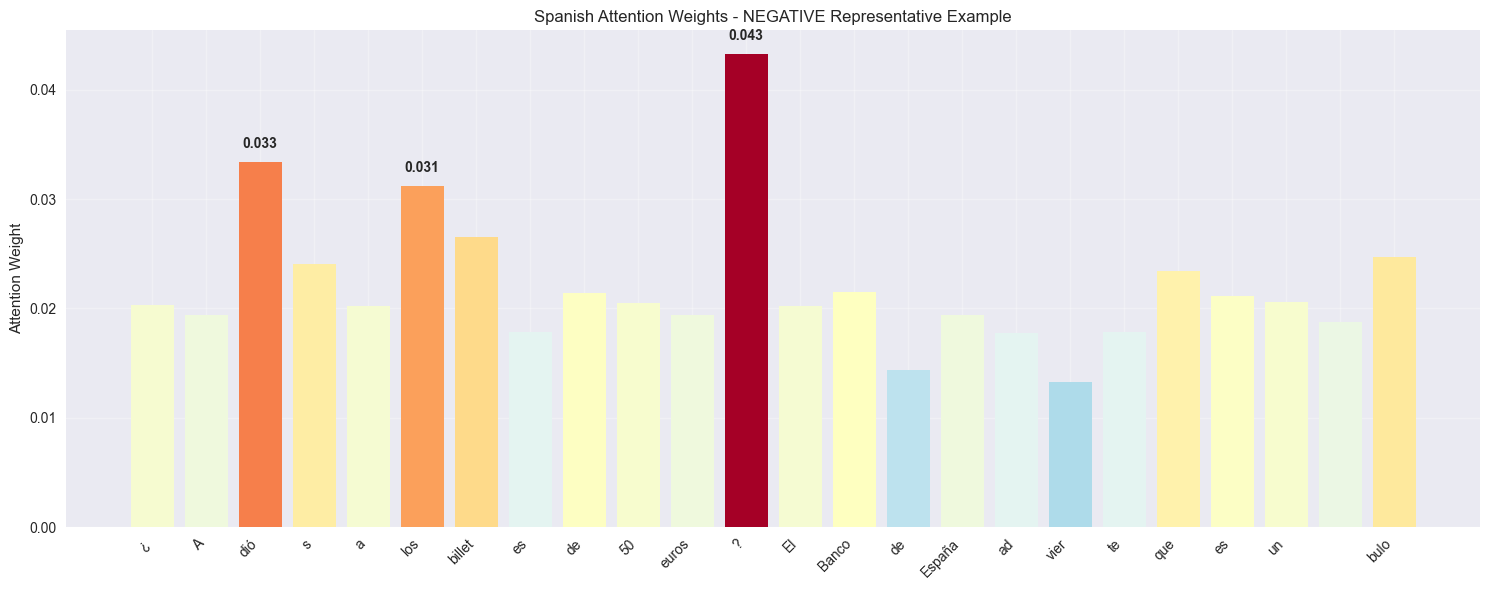


📋 SUMMARY OF REMAINING 9 NEGATIVE SENTENCES:

ID  Preview                                              Conf   Top Attended Words            
-----------------------------------------------------------------------------------------------
2   Confirmado por el Banco de España: estas son las r... 0.985  bloque, están, razones        
3   Habrá cierre masivo de cuentas bancarias en mayo p... 0.937  cierre, para, quienes         
4   Confirmado por el Banco de España: los bancos bloq... 0.971  bloque, los, que              
5   Hasta el Banco de España de Escrivá tumba el SMI d... 0.975  el, detecta, de               
6   El Banco de España alerta de un malware capaz de "... 0.938  malware, "., alerta           
7   Confirmado por el Banco de España: los bancos van ... 0.977  los, bloque, que              
8   El Banco de España desmiente los bulos sobre retir... 0.958  elimina, los, retirada        
9   El Banco de España constata el empobrecimiento de ... 0.990  constata, familias, españ

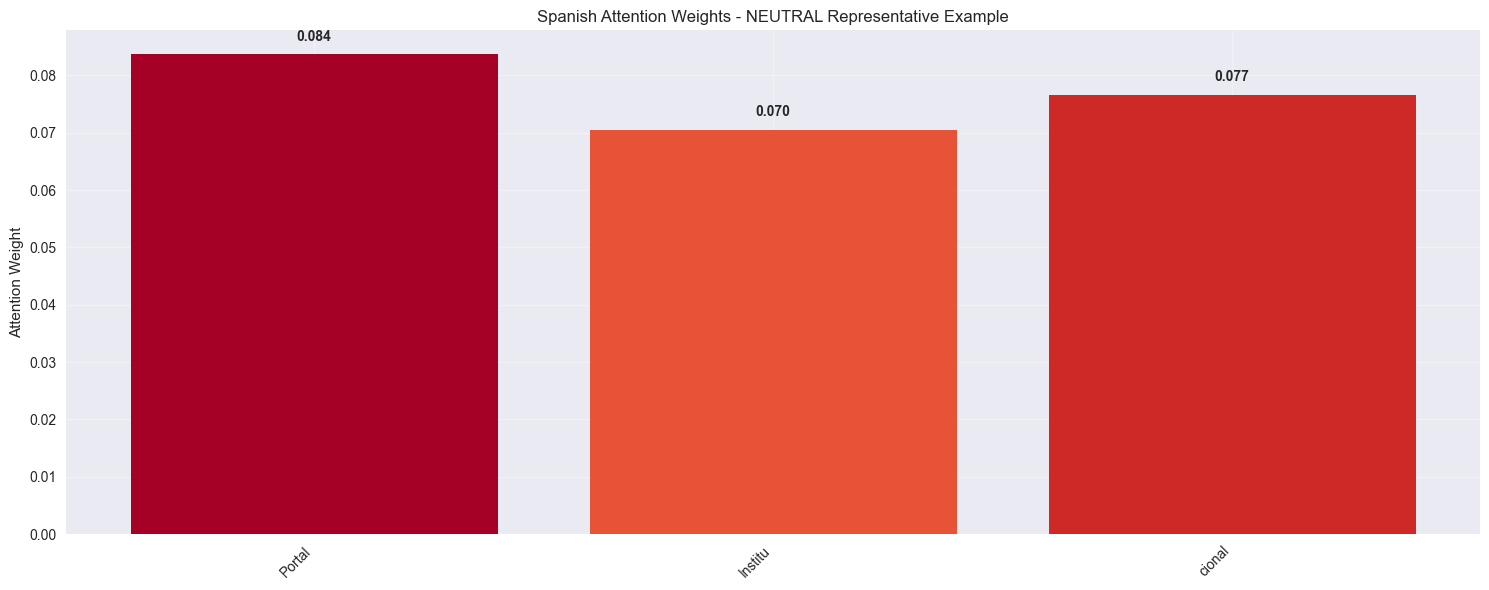


📋 SUMMARY OF REMAINING 9 NEUTRAL SENTENCES:

ID  Preview                                              Conf   Top Attended Words            
-----------------------------------------------------------------------------------------------
2   El Banco de España ultima un "proyecto estratégico... 0.939  estratégico, ultima, inspirado
3   BBVA instala 289 cargadores de vehículo eléctricos... 0.674  instala, 289, en              
4   El Banco de España aclara si los billetes de 50 eu... 0.788  si, desaparece, los           
5   Compañía Internacional convertirá el Banco de Espa... 0.545  convertir, Nacional, Centro   
6   La Biblioteca del Banco de España, con José Luis G... 0.999  Biblioteca, con, España       
7   Un 20% de las empresas españolas ya utiliza la int... 0.992  ya, utiliza, 20%              
8   Dónde es festivo en San Isidro: todas comunidades ... 0.997  todas, fiesta, festiv         
9   Estos son los billetes de 20 euros que no puedes u... 0.850  billet, que, los          

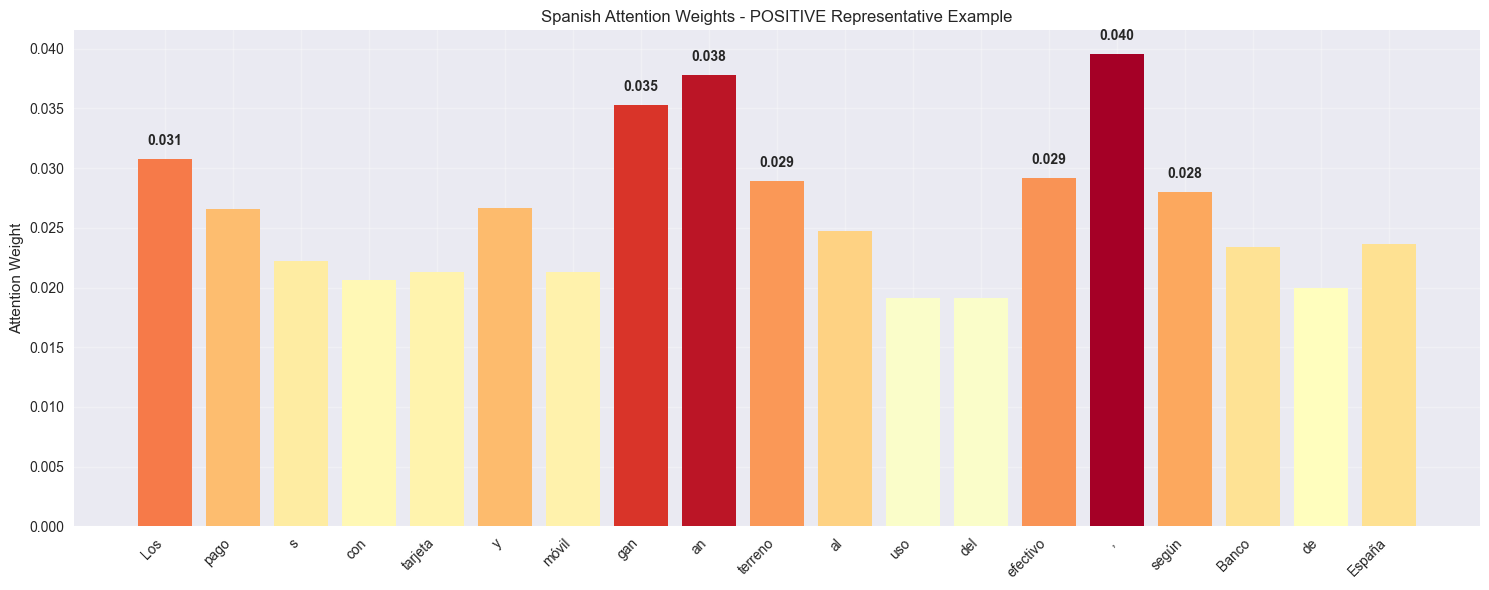


📋 SUMMARY OF REMAINING 9 POSITIVE SENTENCES:

ID  Preview                                              Conf   Top Attended Words            
-----------------------------------------------------------------------------------------------
2   BBVA abre en España su tercer hub de Banca Privada... 1.000  abre, España, de              
3   Banco de España y la CNMV se mantienen al margen d... 0.995  OPA, ndum, la                 
4   BBVA impulsa la educación financiera infantil en E... 0.999  impulsa, con, promoción       
5   CaixaBank, Mejor Banco en España y en Europa Occid... 1.000  Mejor, por, Banco             
6   BBVA, primer banco en España que facilita el pago ... 0.999  facilita, en, con             
7   BBVA permitirá por primera vez en España gestionar... 0.784  gestionar, permitirá, con     
8   El BBVA ofrecerá servicios de compraventa y custod... 0.996  ofrecer, bitcoin, España      
9   Mejores cuentas remuneradas sin comisiones de mayo... 0.999  Mejor, es, remunera      

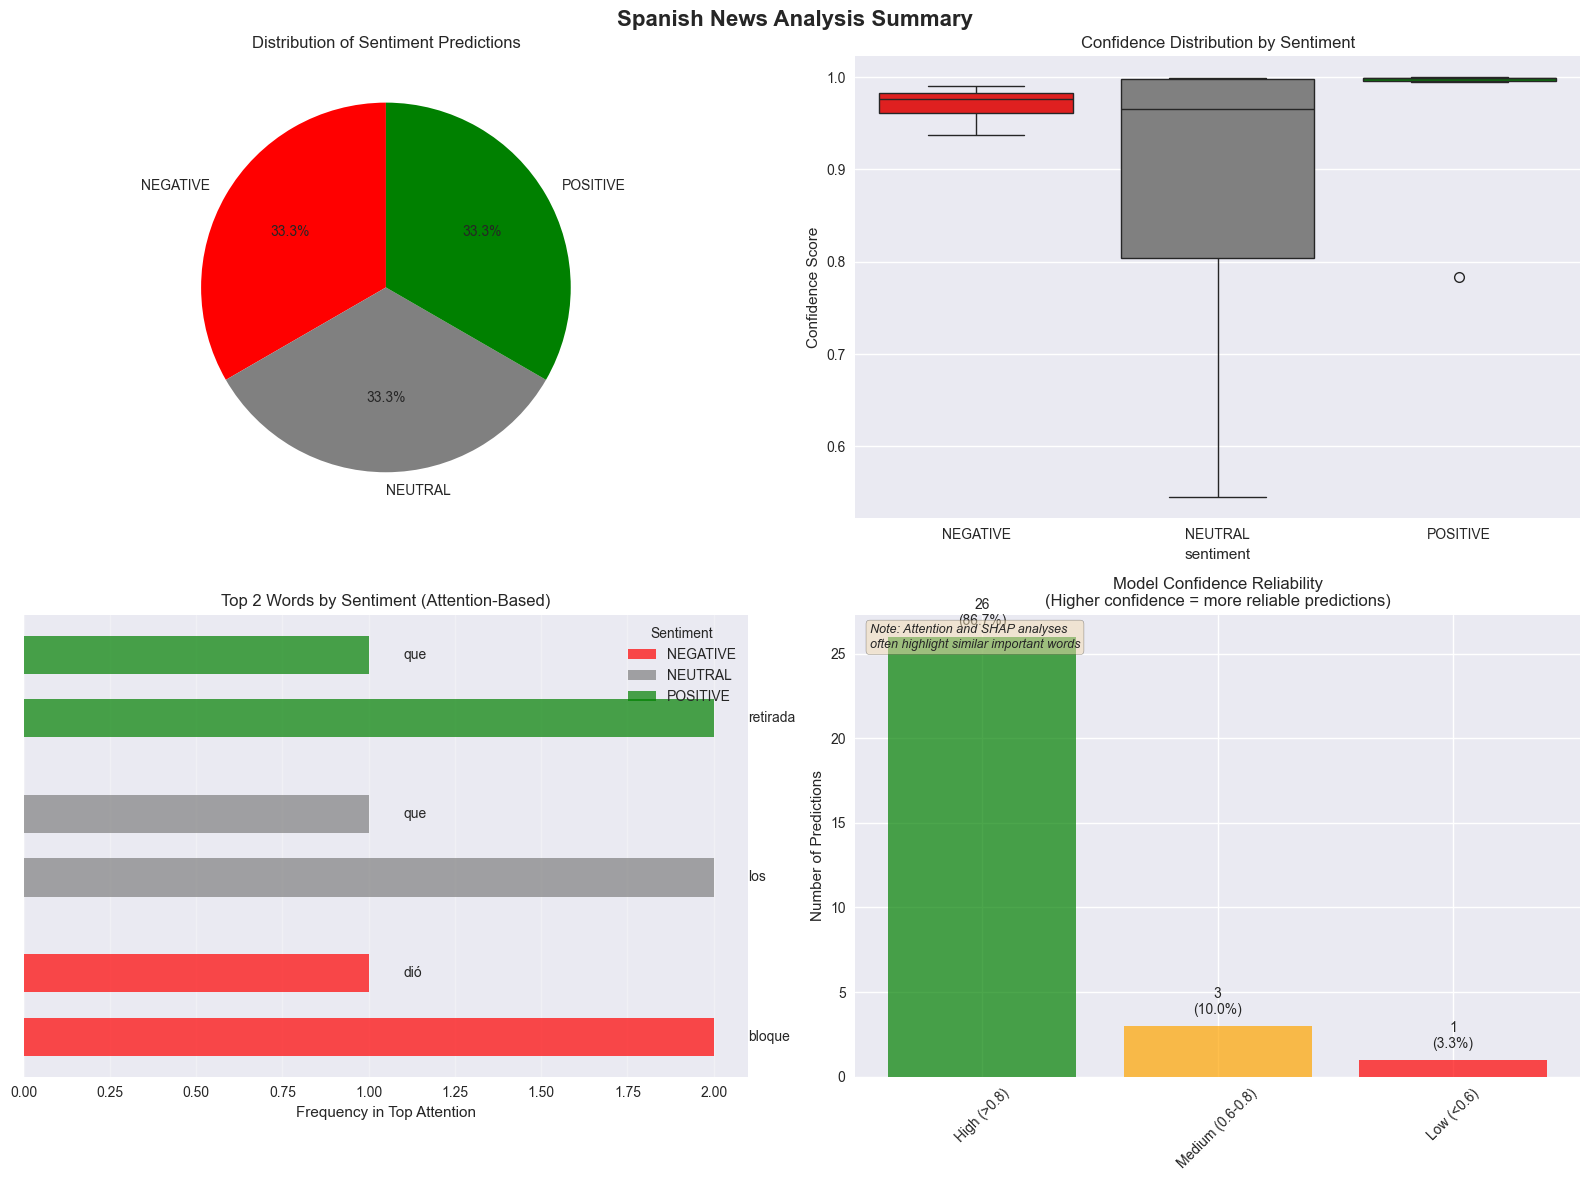


🔍 SPANISH KEY INSIGHTS BY SENTIMENT CATEGORY:

   NEGATIVE:
     • Average confidence: 0.969
     • Confidence range: 0.937 - 0.990
     • Top attended words: bloque, dió, los

   NEUTRAL:
     • Average confidence: 0.878
     • Confidence range: 0.545 - 0.999
     • Top attended words: los, que, el

   POSITIVE:
     • Average confidence: 0.977
     • Confidence range: 0.784 - 1.000
     • Top attended words: retirada, que, elimina

📈 SPANISH OVERALL STATS:
   • Average confidence: 0.941
   • Most common prediction: POSITIVE
   • Overall confidence range: 0.545 - 1.000
   • High confidence predictions (>0.8): 26/30 (86.7%)
   • Low confidence predictions (<0.6): 1/30 (3.3%)


In [10]:
# Analyze Spanish sentences using simplified approach (max 1 plot per sentiment)
analyses_es = analyze_language_sentences(
    random_sentences_es, "Spanish", pipe, tokenizer_detailed, model_detailed, label_to_sentiment, max_plots_per_sentiment=1)

# Create Spanish summary analysis using simplified function
spanish_summary = create_summary_analysis(analyses_es, "Spanish")


🔍 SHAP ANALYSIS FOR SPANISH

🔍 SHAP Analysis for Spanish NEGATIVE sentences:


  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:34, 34.84s/it]               




📈 Representative NEGATIVE example 1: ¿Adiós a los billetes de 50 euros? El Banco de España advierte que es un bulo...
🏆 Top SHAP contributors for NEGATIVE:
   '?': -0.2477
   'bulo': -0.2308
   's': -0.2233
   'de': -0.2123
   'El': 0.2013


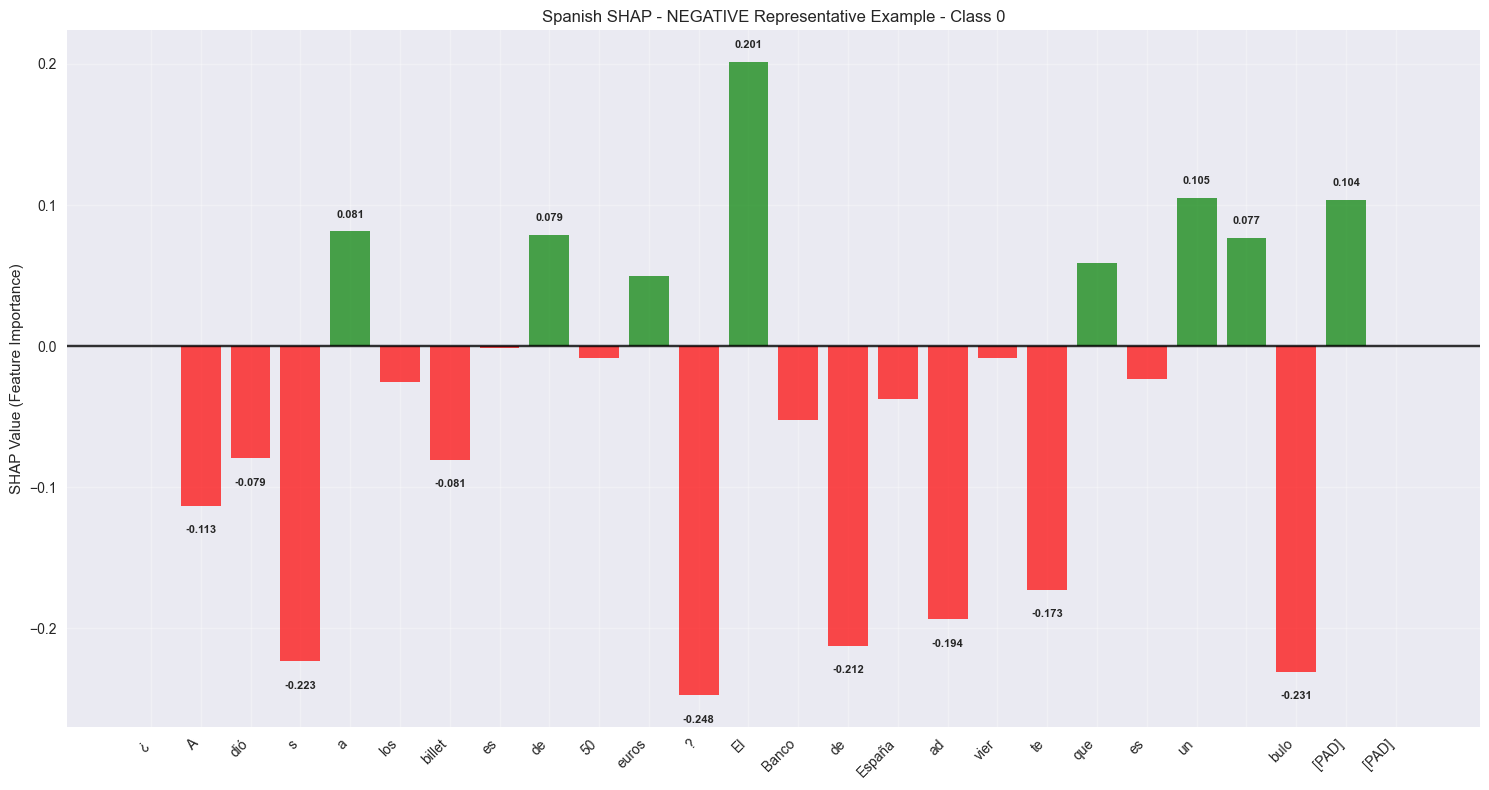

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:21, 21.95s/it]               



  0%|          | 0/420 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:15, 15.88s/it]               



  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:21, 21.32s/it]               



  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:19, 19.87s/it]               



  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:20, 20.17s/it]               



  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:21, 21.44s/it]               



  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:22, 22.27s/it]               



  0%|          | 0/380 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:13, 13.26s/it]               



  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:22, 22.76s/it]               




📋 SHAP Summary for remaining 9 NEGATIVE sentences:

ID  Preview                                              Top SHAP Words                
------------------------------------------------------------------------------------------
2   Confirmado por el Banco de España: estas son las r... ando, :, ar                   
3   Habrá cierre masivo de cuentas bancarias en mayo p... masiv, o, cierre              
4   Confirmado por el Banco de España: los bancos bloq... a, :, los                     
5   Hasta el Banco de España de Escrivá tumba el SMI d... el, vá, nici                  
6   El Banco de España alerta de un malware capaz de "... de, de, Mo                    
7   Confirmado por el Banco de España: los bancos van ... ar, :, van                    
8   El Banco de España desmiente los bulos sobre retir... es, te, los                   
9   El Banco de España constata el empobrecimiento de ... el, cimiento, obre            
10  El Banco de España anuncia la retirada de ciertos ..

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:21, 21.52s/it]               




📈 Representative NEUTRAL example 1: El Banco de España eleva la previsión de PIB al 2,7% pero no incluye el contexto...
🏆 Top SHAP contributors for NEUTRAL:
   'la': 0.3221
   'no': -0.2498
   'al': 0.1468
   '2': -0.1128
   'pero': -0.0877


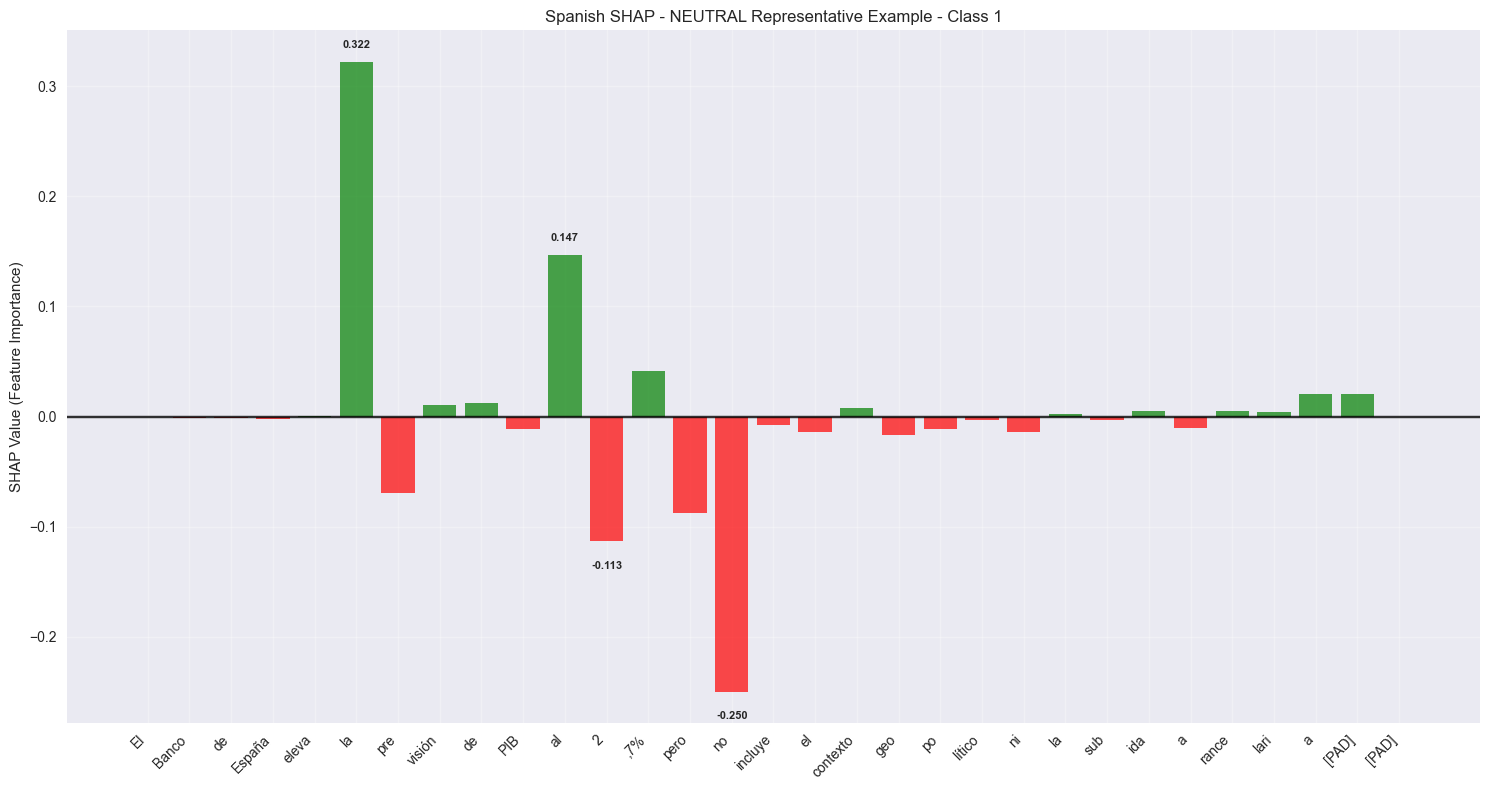

  0%|          | 0/420 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:14, 14.57s/it]               



  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:21, 21.29s/it]               



  0%|          | 0/380 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:17, 17.89s/it]               



  0%|          | 0/240 [00:00<?, ?it/s]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:17, 17.82s/it]               



  0%|          | 0/342 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:11, 11.41s/it]               



  0%|          | 0/342 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:15, 15.36s/it]               



  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:17, 17.50s/it]               




📋 SHAP Summary for remaining 9 NEUTRAL sentences:

ID  Preview                                              Top SHAP Words                
------------------------------------------------------------------------------------------
2   Estos son los billetes de 20 euros que no puedes u... puedes, que, es               
3   Dónde es festivo en San Isidro: todas comunidades ... :, es, dro                    
4   Un 20% de las empresas españolas ya utiliza la int... según, de, la                 
5   La Biblioteca del Banco de España, con José Luis G... José, del, Banco              
6   Compañía Internacional convertirá el Banco de Espa... á, añ, de                     
7   El Banco de España aclara si los billetes de 50 eu... n, desaparece, si             
8   BBVA instala 289 cargadores de vehículo eléctricos... VA, dores, instala            
9   El Banco de España ultima un "proyecto estratégico... en, bank, estratégico         
10  Portal Institucional                                 

  0%|          | 0/420 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:17, 17.03s/it]               




📈 Representative POSITIVE example 1: Los pagos con tarjeta y móvil ganan terreno al uso del efectivo, según Banco de ...
🏆 Top SHAP contributors for POSITIVE:
   'Banco': 0.1392
   'España': -0.0930
   '[PAD]': 0.0878
   'y': -0.0799
   'de': 0.0687


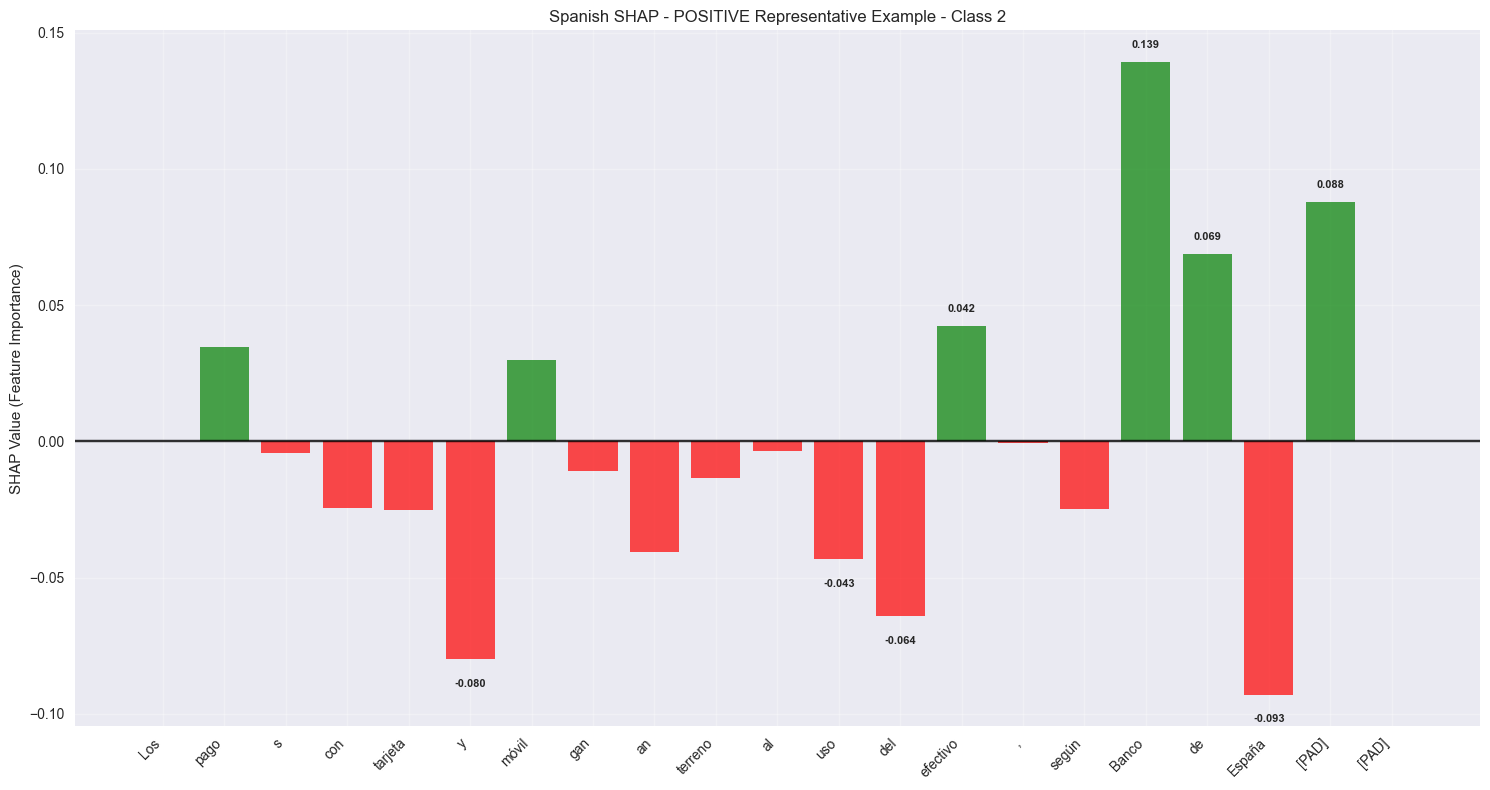

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:19, 19.22s/it]               



  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:25, 25.99s/it]               



  0%|          | 0/462 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:15, 15.25s/it]               



  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:21, 21.36s/it]               



  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:18, 18.58s/it]               



  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:20, 20.78s/it]               



  0%|          | 0/380 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:12, 12.29s/it]               



  0%|          | 0/182 [00:00<?, ?it/s]

  0%|          | 0/306 [00:00<?, ?it/s]


📋 SHAP Summary for remaining 9 POSITIVE sentences:

ID  Preview                                              Top SHAP Words                
------------------------------------------------------------------------------------------
2   BBVA abre en España su tercer hub de Banca Privada... EE, en, .                     
3   Banco de España y la CNMV se mantienen al margen d... por, zado, nada               
4   BBVA impulsa la educación financiera infantil en E... con, una, impulsa             
5   CaixaBank, Mejor Banco en España y en Europa Occid... con, por, su                  
6   BBVA, primer banco en España que facilita el pago ... TP, um, en                    
7   BBVA permitirá por primera vez en España gestionar... primera, por, vez             
8   El BBVA ofrecerá servicios de compraventa y custod... bitcoin, ther, á              
9   Mejores cuentas remuneradas sin comisiones de mayo... misiones, sin, de             
10  La Diputación negocia la compra del edificio de Co..

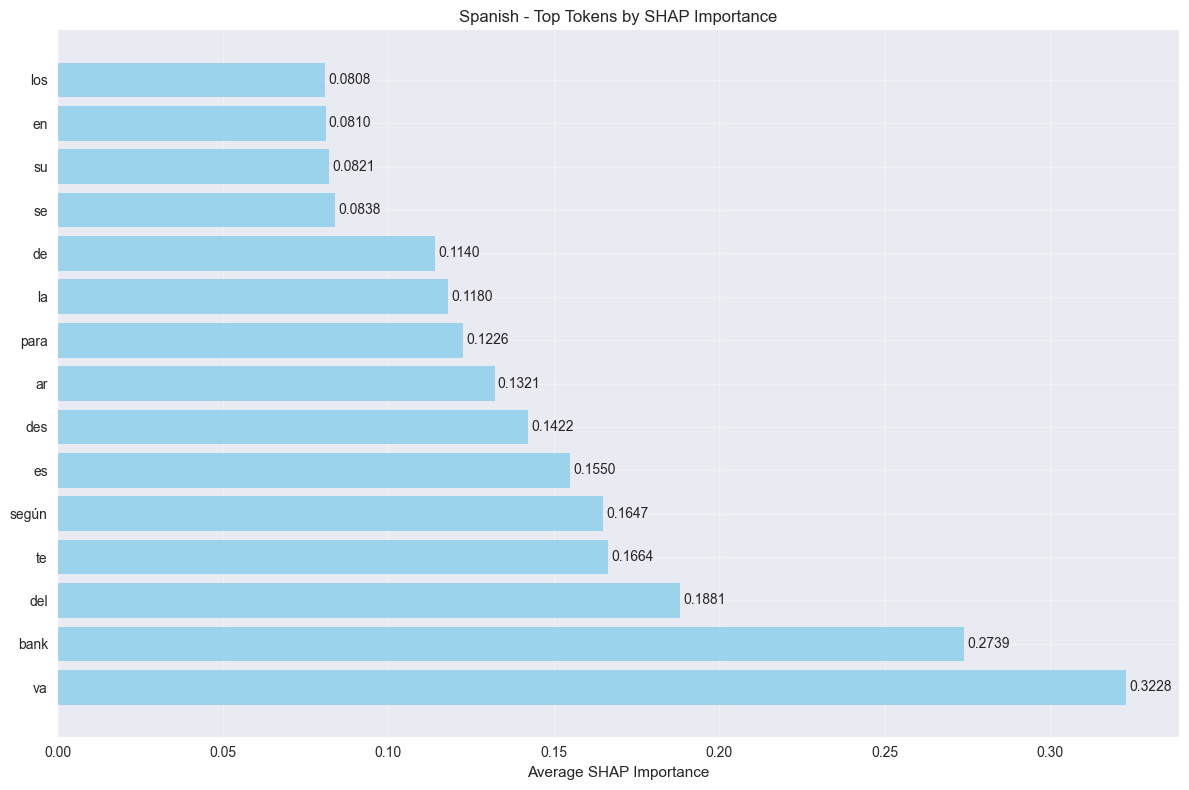


✅ Completed SHAP analysis for Spanish (30 successful analyses with 1 detailed plot(s) per sentiment)


In [11]:
# Perform simplified SHAP Analysis for Spanish (max 1 plot per sentiment)
spanish_shap_results = perform_shap_analysis_for_language(
    random_sentences_es, "Spanish", tokenizer_detailed, model_detailed, label_to_sentiment, max_plots_per_sentiment=1)

# English News Data Analysis (FTSE)

In [12]:
print(f"Total English news articles available: {len(news_df_en)}")

# Get balanced samples for English news using common function
random_sentences_en, sentiment_distribution_en = get_balanced_sentiment_samples(
    news_df_en, pipe, label_to_sentiment)

print(f"English sentiment distribution: {sentiment_distribution_en}")
print(f"Selected {len(random_sentences_en)} English sentences for analysis:")

Total English news articles available: 200
English sentiment distribution: {'NEGATIVE': 39, 'POSITIVE': 33, 'NEUTRAL': 28}
Selected 30 English sentences for analysis:
English sentiment distribution: {'NEGATIVE': 39, 'POSITIVE': 33, 'NEUTRAL': 28}
Selected 30 English sentences for analysis:


Analyzing English sentences by sentiment category with transformer...


🔴 ANALYZING ENGLISH NEGATIVE SENTENCES (10 found)

--------------------------------------------------------------------------------
ENGLISH REPRESENTATIVE NEGATIVE SENTENCE 1: How would Donald Trump’s tariffs on foreign films affect the UK industry?
--------------------------------------------------------------------------------

📊 PREDICTION: NEGATIVE (confidence: 0.978)

📈 CLASS PROBABILITIES:
   NEUTRAL: 0.022
   POSITIVE: 0.000
   NEGATIVE: 0.978

🔍 TOP ATTENDED WORDS:
   'Trump': 0.0388
   'affect': 0.0360
   'tarif': 0.0355
   'films': 0.0338
   'would': 0.0302


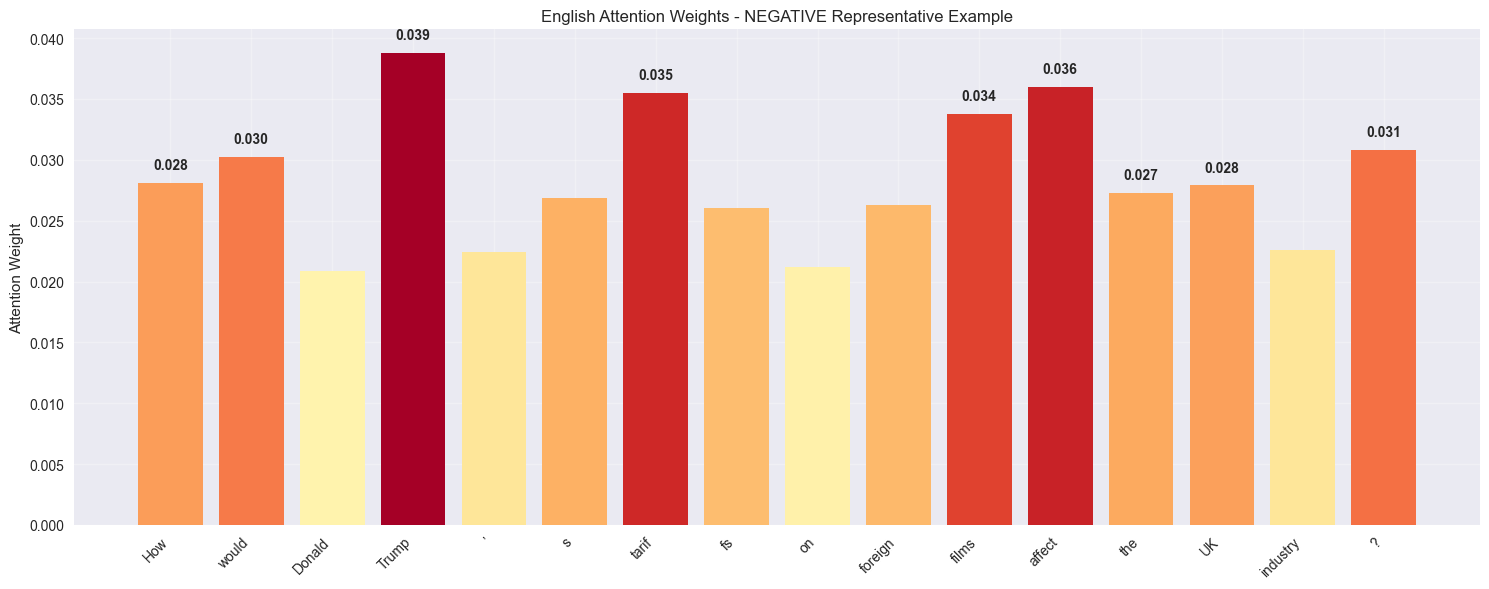


📋 SUMMARY OF REMAINING 9 NEGATIVE SENTENCES:

ID  Preview                                              Conf   Top Attended Words            
-----------------------------------------------------------------------------------------------
2   Interest rates tipped to be held as jobs market we... 0.998  as, rates, held               
3   Argentina central bank hikes key rate to 133% as i... 0.975  hi, as, Argentina             
4   Summers and Blanchard debate the future of interes... 0.985  debate, rates, and            
5   Sir Richard Branson criticises Donald Trump's tari... 0.998  Trump, critic, tarif          
6   The mystery of the shapeshifting crypto-VC profit    0.550  profit, mystery, crypto       
7   Wavering Government support for nature investment ... 0.994  scheme, support, could        
8   JD Sports shares plummet following dire profit war... 0.998  JD, following, profit         
9   Argentina’s economy exits recession in milestone f... 0.871  cession, Argentina, exit  

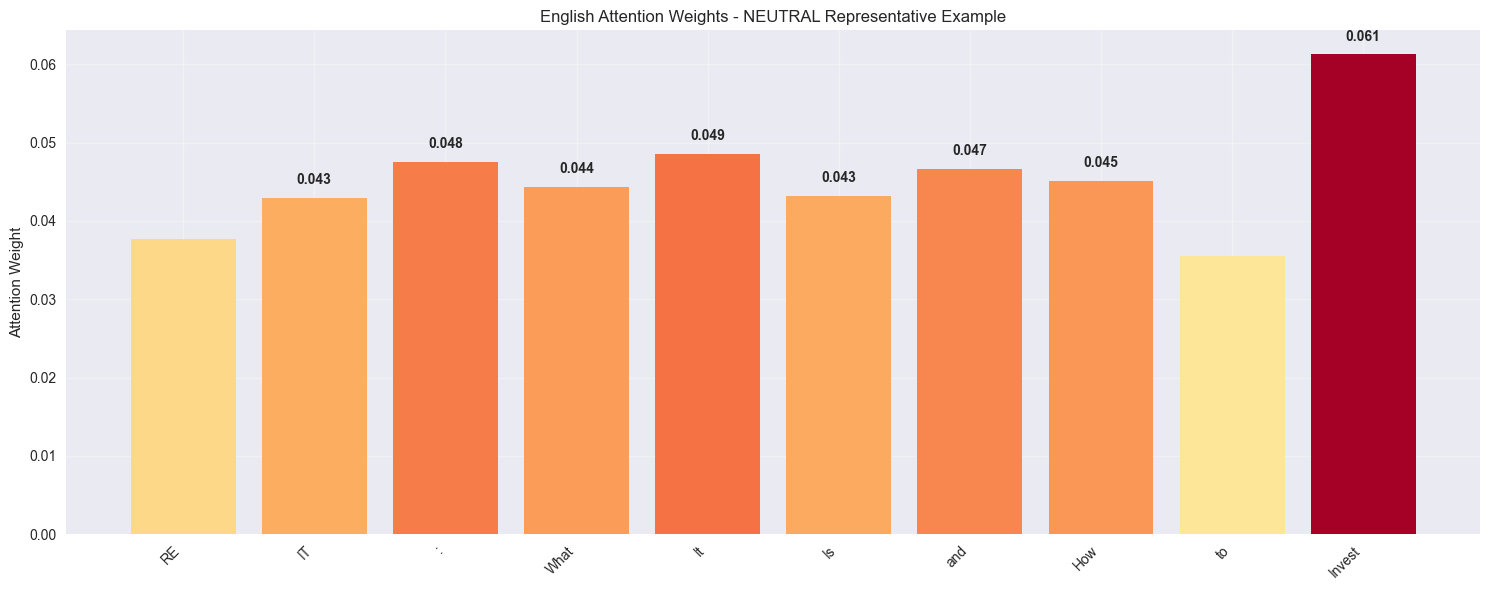


📋 SUMMARY OF REMAINING 9 NEUTRAL SENTENCES:

ID  Preview                                              Conf   Top Attended Words            
-----------------------------------------------------------------------------------------------
2   In Situ Forming of Nitric Oxide and Electric Stimu... 0.990  and, of, by                   
3   The life and possible death of low interest rates ... 0.844  low, of, death                
4   Why is Saudi Arabia spending so much on sport?       0.988  spending, Why, sport          
5   Practical guidance to scale blended finance          0.786  finance, scale, guidance      
6   Korea: Restrictive Monetary Policy and Fiscal Disc... 0.998  Essential, for, Korea         
7   Building a robust investment portfolio: 3 ideas fo... 0.868  robust, diversi, how          
8   What is the state of the UK economy in early 2024?   0.999  state, UK, economy            
9   The UK economy in the 1960s                          0.990  1960, UK, economy             

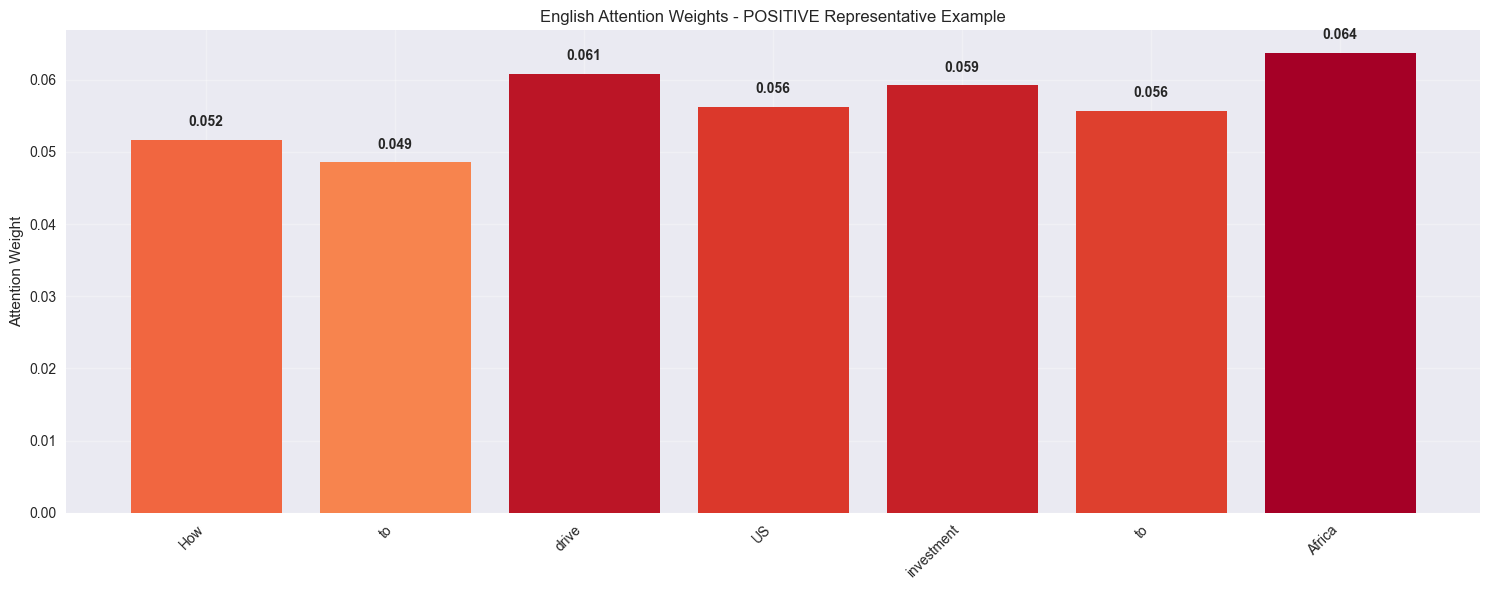


📋 SUMMARY OF REMAINING 9 POSITIVE SENTENCES:

ID  Preview                                              Conf   Top Attended Words            
-----------------------------------------------------------------------------------------------
2   Get real: Inflation-beating income |                 0.993  income, ating, real           
3   Turkey's central bank raises interest rates to 40%   0.642  raise, Turkey, bank           
4   Launch of WHO’s Investment Round and announcement ... 0.998  winner, WHO, and              
5   How to Awaken Europe's Private Sector and Boost Ec... 0.999  Europe, and, Boost            
6   Multi-million pound investment in artillery produc... 1.000  investment, 50, to            
7   Trump tariffs could be good for some countries, in... 1.000  good, Trump, could            
8   Tech and crypto groups rush to profit from stablec... 0.999  profit, from, groups          
9   FirstFT: Europe should co-operate with Trump on ta... 0.998  Trump, should, co          

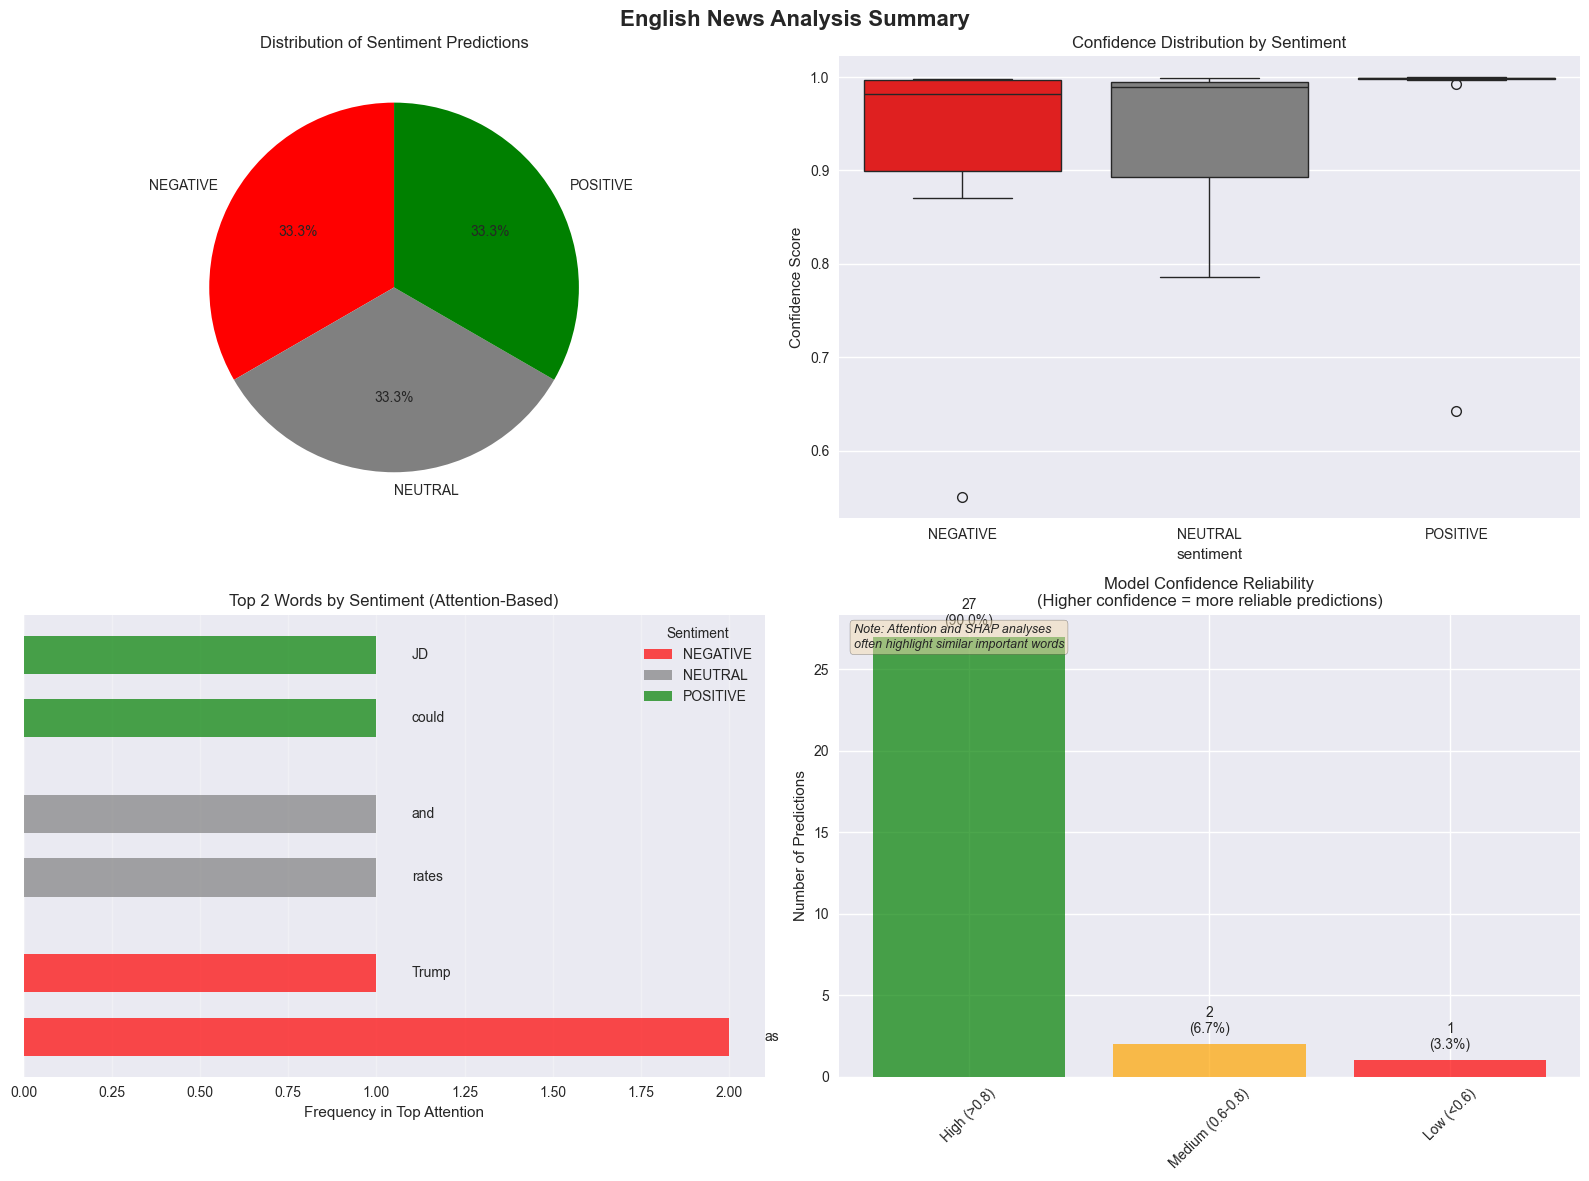


🔍 ENGLISH KEY INSIGHTS BY SENTIMENT CATEGORY:

   NEGATIVE:
     • Average confidence: 0.922
     • Confidence range: 0.550 - 0.998
     • Top attended words: as, Trump, affect

   NEUTRAL:
     • Average confidence: 0.943
     • Confidence range: 0.786 - 0.999
     • Top attended words: rates, and, Trump

   POSITIVE:
     • Average confidence: 0.963
     • Confidence range: 0.642 - 1.000
     • Top attended words: could, JD, following

📈 ENGLISH OVERALL STATS:
   • Average confidence: 0.943
   • Most common prediction: POSITIVE
   • Overall confidence range: 0.550 - 1.000
   • High confidence predictions (>0.8): 27/30 (90.0%)
   • Low confidence predictions (<0.6): 1/30 (3.3%)


In [13]:
# Analyze English sentences using common function
analyses_en = analyze_language_sentences(
    random_sentences_en, "English", pipe, tokenizer_detailed, model_detailed, label_to_sentiment)

# Create English summary analysis using common function
english_summary = create_summary_analysis(analyses_en, "English")


🔍 SHAP ANALYSIS FOR ENGLISH

🔍 SHAP Analysis for English NEGATIVE sentences:


  0%|          | 0/306 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:19, 19.20s/it]               


📈 Representative NEGATIVE example 1: How would Donald Trump’s tariffs on foreign films affect the UK industry?...
🏆 Top SHAP contributors for NEGATIVE:
   '’': -0.5418
   '[PAD]': 0.3774
   'the': -0.2571
   's': 0.2251
   'Trump': -0.1542


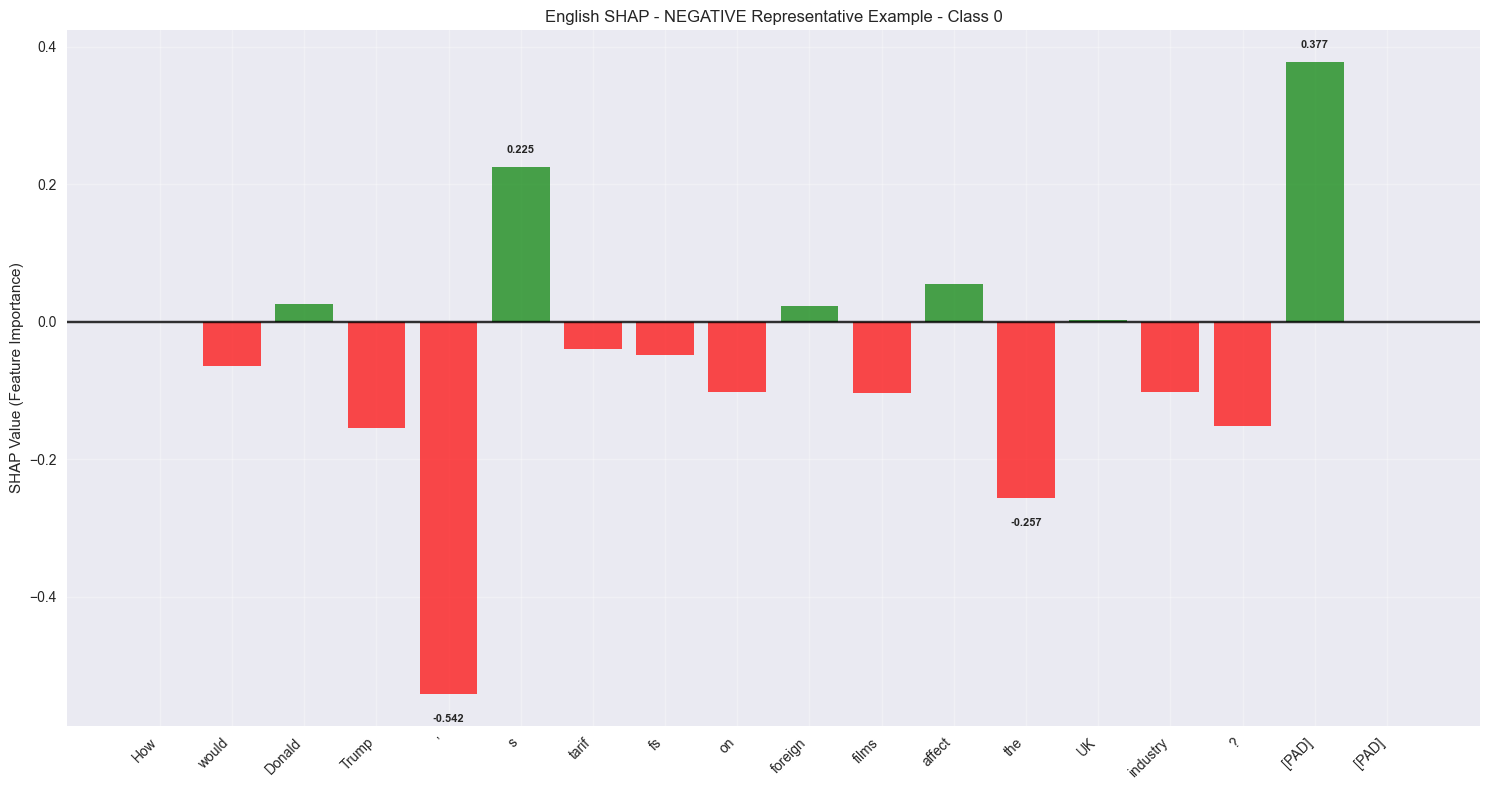

  0%|          | 0/240 [00:00<?, ?it/s]

  0%|          | 0/272 [00:00<?, ?it/s]

  0%|          | 0/156 [00:00<?, ?it/s]

  0%|          | 0/182 [00:00<?, ?it/s]

  0%|          | 0/182 [00:00<?, ?it/s]

  0%|          | 0/380 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:12, 12.42s/it]               



  0%|          | 0/210 [00:00<?, ?it/s]

  0%|          | 0/272 [00:00<?, ?it/s]

  0%|          | 0/420 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:13, 13.86s/it]               




📋 SHAP Summary for remaining 9 NEGATIVE sentences:

ID  Preview                                              Top SHAP Words                
------------------------------------------------------------------------------------------
2   Interest rates tipped to be held as jobs market we... ens, market, t                
3   Argentina central bank hikes key rate to 133% as i... as, hi, ns                    
4   Summers and Blanchard debate the future of interes... [PAD], s, interest            
5   Sir Richard Branson criticises Donald Trump's tari... fs, ises, '                   
6   The mystery of the shapeshifting crypto-VC profit    [PAD], shi, profit            
7   Wavering Government support for nature investment ... away, support, space          
8   JD Sports shares plummet following dire profit war... Sports, s, ning               
9   Argentina’s economy exits recession in milestone f... Javier, ’, for                
10  HMRC late payment interest rates to be revised aft...

  0%|          | 0/380 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:15, 15.92s/it]               




📈 Representative NEUTRAL example 1: What we know about Trump’s reciprocal tariffs – and what we don’t...
🏆 Top SHAP contributors for NEUTRAL:
   'al': 0.2977
   'fs': -0.2648
   'we': 0.1441
   'and': -0.1429
   '’': 0.1399


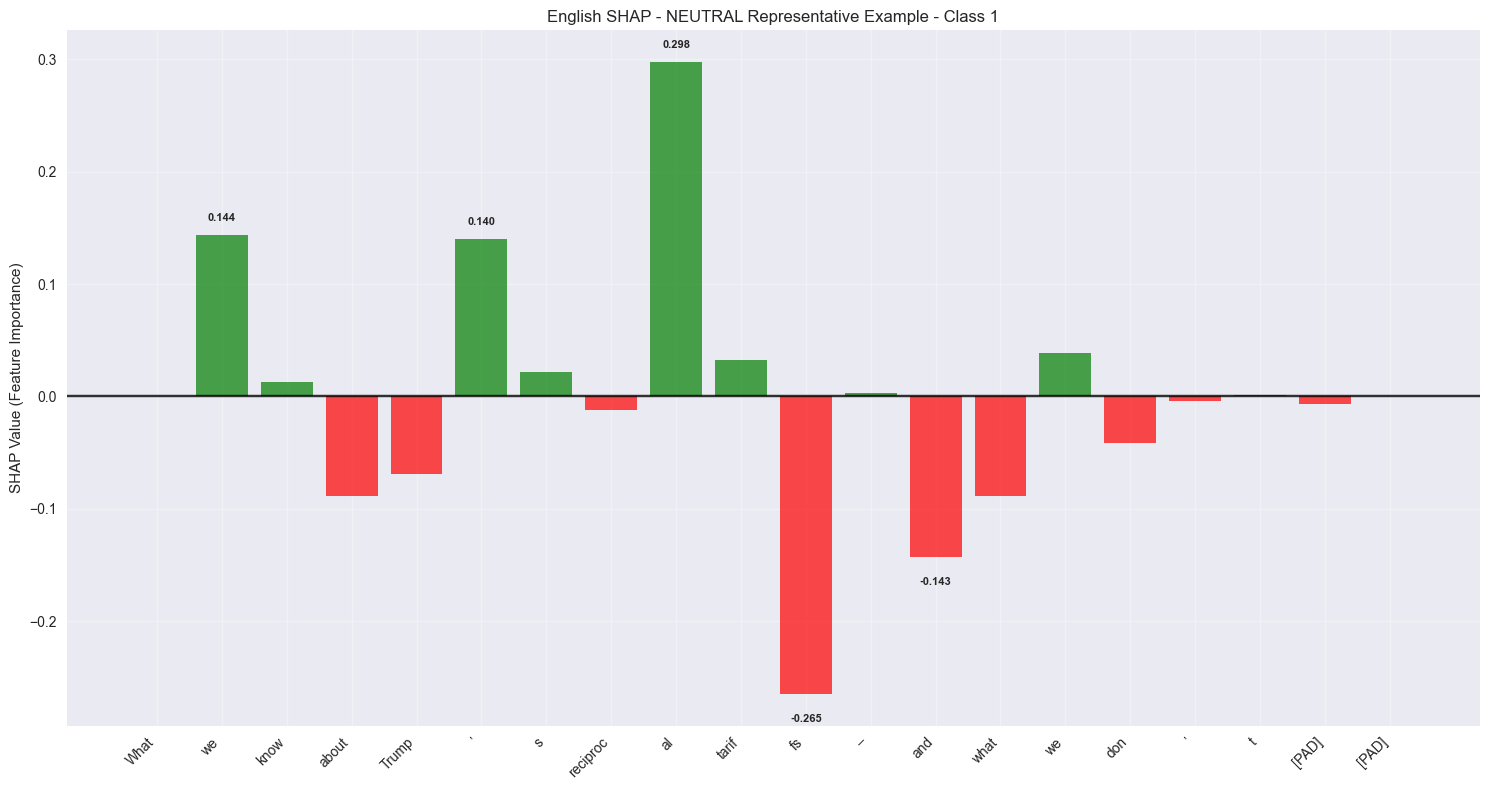

  0%|          | 0/210 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:13, 13.24s/it]               



  0%|          | 0/210 [00:00<?, ?it/s]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:22, 22.61s/it]               



  0%|          | 0/132 [00:00<?, ?it/s]

  0%|          | 0/182 [00:00<?, ?it/s]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:22, 22.31s/it]               




📋 SHAP Summary for remaining 9 NEUTRAL sentences:

ID  Preview                                              Top SHAP Words                
------------------------------------------------------------------------------------------
2   The UK economy in the 1960s                          s, in, UK                     
3   What is the state of the UK economy in early 2024?   in, [PAD], economy            
4   Building a robust investment portfolio: 3 ideas fo... investment, to, 3             
5   Korea: Restrictive Monetary Policy and Fiscal Disc... ive, Inf, Monet               
6   Practical guidance to scale blended finance          blend, scale, al              
7   Why is Saudi Arabia spending so much on sport?       is, [PAD], Saudi              
8   The life and possible death of low interest rates ... [PAD], Planet, Money          
9   In Situ Forming of Nitric Oxide and Electric Stimu... Nerv, able, by                
10  REIT: What It Is and How to Invest                   to, 

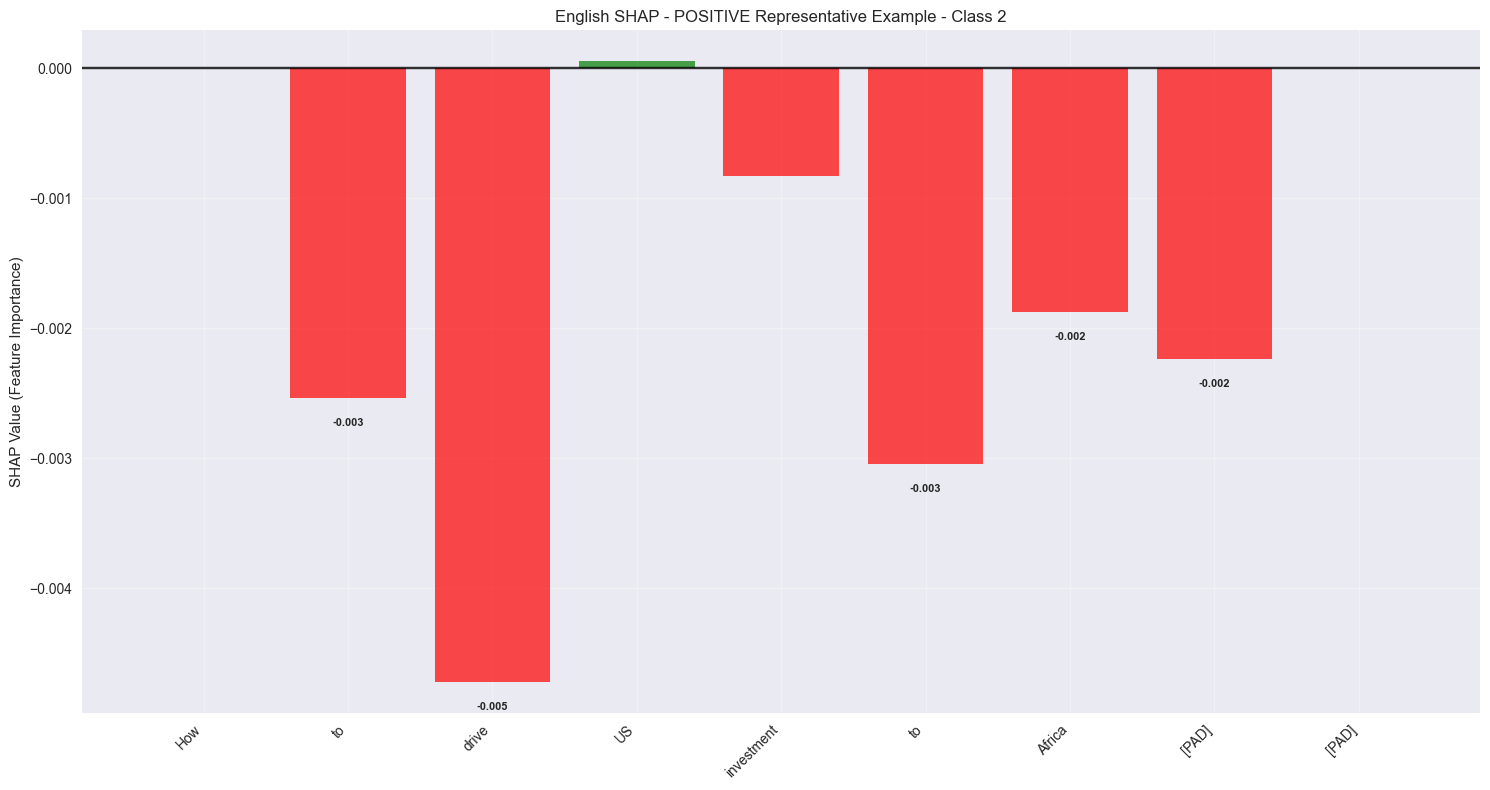

  0%|          | 0/156 [00:00<?, ?it/s]

  0%|          | 0/420 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:18, 18.46s/it]               



  0%|          | 0/240 [00:00<?, ?it/s]

  0%|          | 0/462 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:15, 15.88s/it]               



  0%|          | 0/210 [00:00<?, ?it/s]

  0%|          | 0/210 [00:00<?, ?it/s]

  0%|          | 0/380 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:17, 17.18s/it]               




📋 SHAP Summary for remaining 9 POSITIVE sentences:

ID  Preview                                              Top SHAP Words                
------------------------------------------------------------------------------------------
2   Get real: Inflation-beating income |                 lation, -, [PAD]              
3   Turkey's central bank raises interest rates to 40%   s, to, [PAD]                  
4   Launch of WHO’s Investment Round and announcement ... of, ’, WHO                    
5   How to Awaken Europe's Private Sector and Boost Ec... wak, en, Boost                
6   Multi-million pound investment in artillery produc... und, po, investment           
7   Trump tariffs could be good for some countries, in... for, fs, ,                    
8   Tech and crypto groups rush to profit from stablec... profit, to, rush              
9   FirstFT: Europe should co-operate with Trump on ta... -, ,, fs                      
10  Government confirms above inflation pay award for ... 

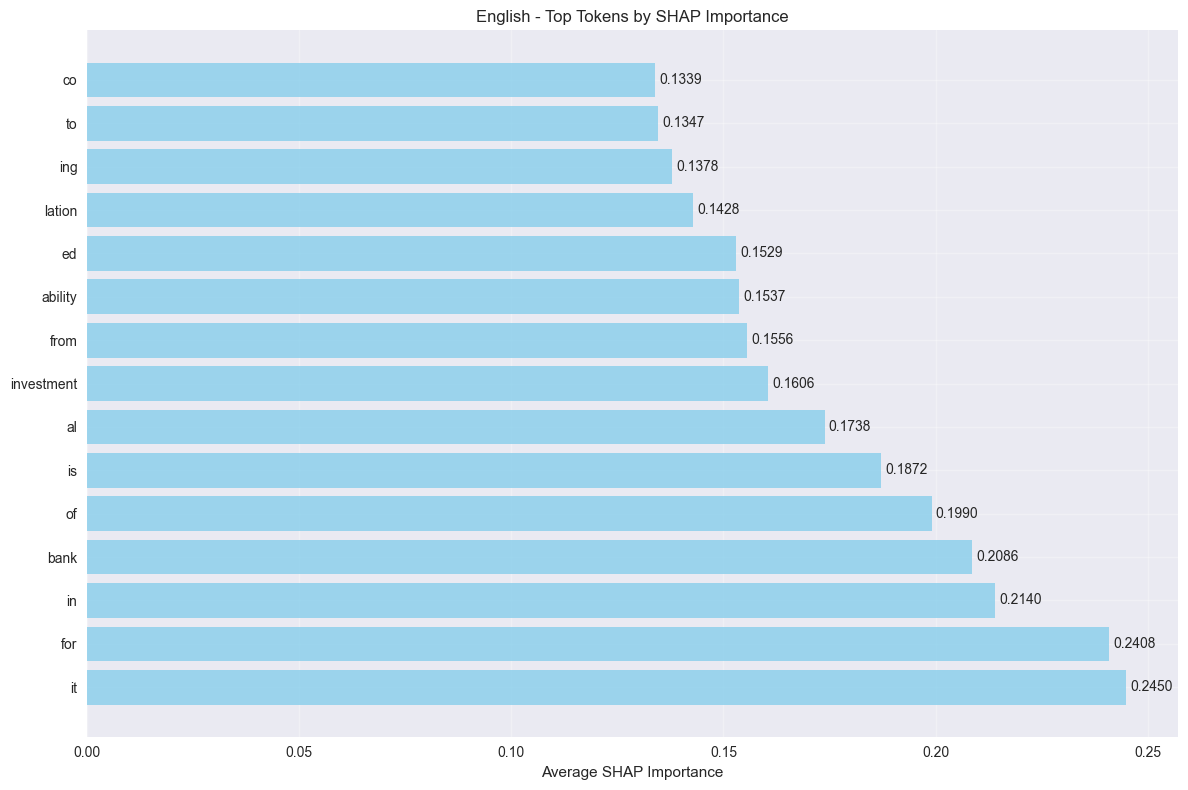


✅ Completed SHAP analysis for English (30 successful analyses with 1 detailed plot(s) per sentiment)


In [14]:
# Perform SHAP Analysis for English with limited plots per sentiment
english_shap_results = perform_shap_analysis_for_language(
    random_sentences_en, "English", tokenizer_detailed, model_detailed, label_to_sentiment, max_plots_per_sentiment=1)

# French News Data Analysis (CAC)

Analysis of French financial news from CAC 40 index.

In [15]:
# Load and process French news data (CAC)
print(f"Total French news articles available: {len(news_df_fr)}")

# Get balanced samples for French news using common function
random_sentences_fr, sentiment_distribution_fr = get_balanced_sentiment_samples(
    news_df_fr, pipe, label_to_sentiment)

print(f"French sentiment distribution: {sentiment_distribution_fr}")
print(f"Selected {len(random_sentences_fr)} French sentences for analysis:")

Total French news articles available: 200
French sentiment distribution: {'POSITIVE': 45, 'NEGATIVE': 34, 'NEUTRAL': 21}
Selected 30 French sentences for analysis:
French sentiment distribution: {'POSITIVE': 45, 'NEGATIVE': 34, 'NEUTRAL': 21}
Selected 30 French sentences for analysis:


Analyzing French sentences by sentiment category with transformer...


🔴 ANALYZING FRENCH NEGATIVE SENTENCES (10 found)

--------------------------------------------------------------------------------
FRENCH REPRESENTATIVE NEGATIVE SENTENCE 1: Ouest-France : « La France vit au-dessus de ses moyens depuis trop longtemps »
--------------------------------------------------------------------------------

📊 PREDICTION: NEGATIVE (confidence: 0.708)

📈 CLASS PROBABILITIES:
   NEUTRAL: 0.290
   POSITIVE: 0.002
   NEGATIVE: 0.708

🔍 TOP ATTENDED WORDS:
   'La': 0.0400
   'dessus': 0.0361
   'France': 0.0348
   'au': 0.0285
   'moyens': 0.0270


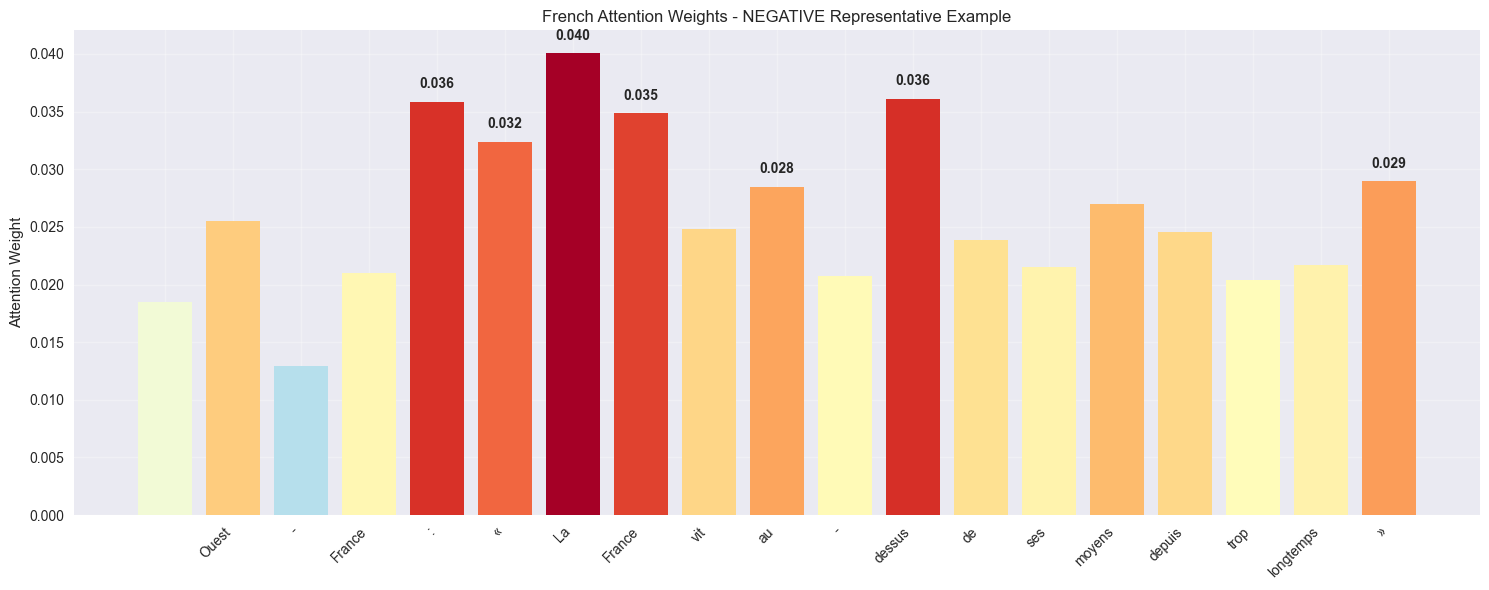


📋 SUMMARY OF REMAINING 9 NEGATIVE SENTENCES:

ID  Preview                                              Conf   Top Attended Words            
-----------------------------------------------------------------------------------------------
2   Votre fonds ESG pourrait devoir vendre ces actions   0.977  vendre, ces, fonds            
3   Pourquoi l'épisode inflationniste a laissé des tra... 0.958  Pourquoi, infla, les          
4   Du diplôme au chômage : les désillusions de la jeu... 0.929  podcast, illusion, chômage    
5   Le chômage en France repart à la hausse, à 7,4 % a... 0.997  chômage, Le, hausse           
6   Face à l’inflation, les hôpitaux crient à l’urgenc... 0.957  urgence, cri, inf             
7   Heatflation, Greenflation, Shrinkflation... Les de... 0.643  dessous, ..., fla             
8   L'Assurance-chômage reste dans le vert, mais ses e... 0.703  fort, vert, moins             
9   Inflation : payez-vous vos courses plus cher que d... 0.747  vous, ez, plus            

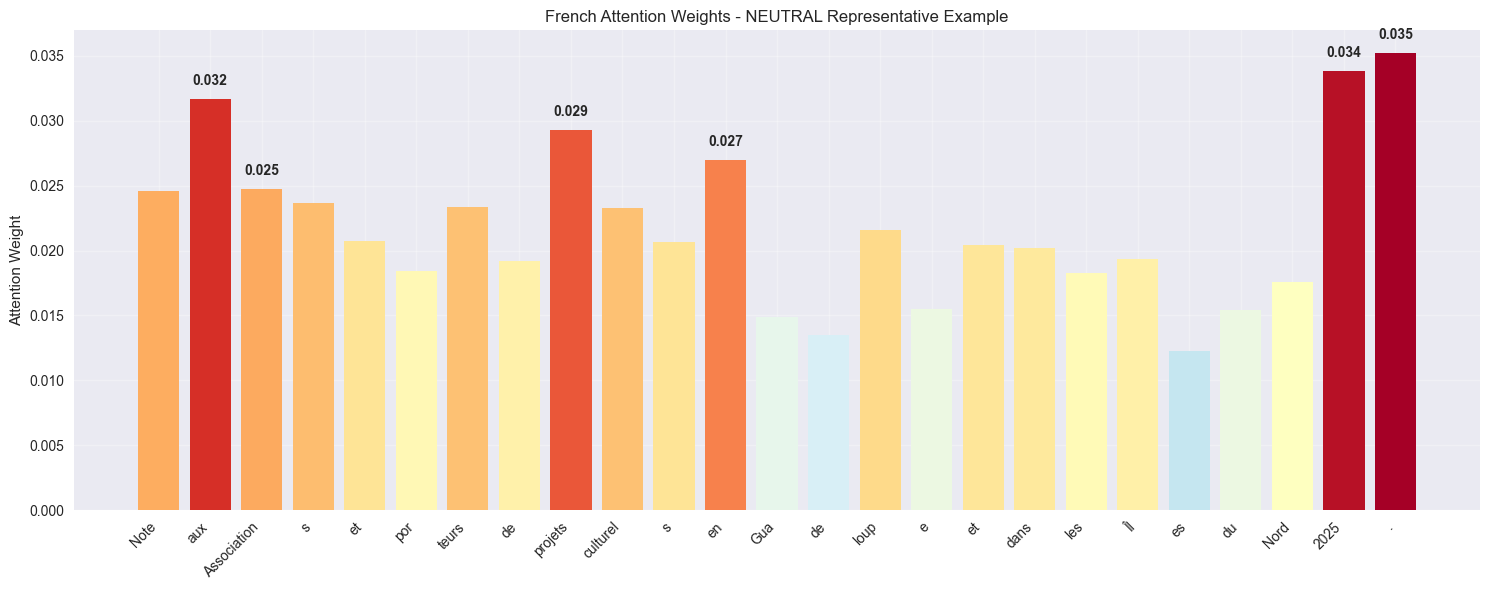


📋 SUMMARY OF REMAINING 9 NEUTRAL SENTENCES:

ID  Preview                                              Conf   Top Attended Words            
-----------------------------------------------------------------------------------------------
2   La Banque du Canada garde le cap sur une inflation... 0.993  infla, cap, garde             
3   Pourquoi la baisse du chômage n’a pas entraîné le ... 0.574  Pourquoi, pauvre, chômage     
4   L'État met 2,9 milliards d'euros dans l'usine de p... 0.985  dans, met, investissement     
5   Investissement média : les discounters sont les pl... 0.607  discount, sont, les           
6   Inflation : quel impact sur les marchés financiers... 0.992  impact, Inf, marché           
7   JO 2024. Tarifs, sports, régions : les secrets des... 0.998  secret, vendu, billet         
8   « L’interventionnisme en 2023 n’est pas une politi... 0.999  2023, intervention, politique 
9   Budget 2024 : les sénateurs augmentent la DGF, mai... 0.888  index, refuse, les        

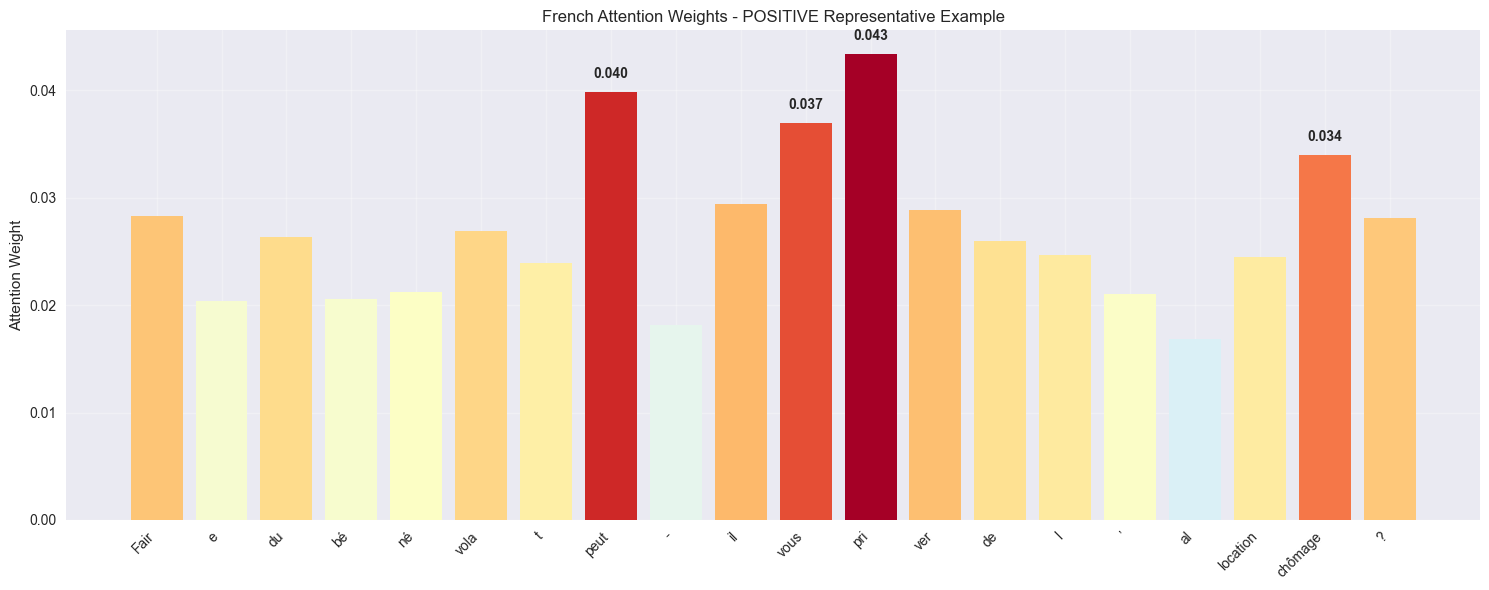


📋 SUMMARY OF REMAINING 9 POSITIVE SENTENCES:

ID  Preview                                              Conf   Top Attended Words            
-----------------------------------------------------------------------------------------------
2   CLASSEMENT RScE                                      0.962  EMENT, RS, CLA                
3   Placements : les sirènes du non-coté pour dynamise... 0.999  pour, les, son                
4   L’immigration : un atout pour le dynamisme économi... 1.000  immigration, pour, un         
5   « La BCE pourrait appliquer des taux d’intérêt moi... 0.707  moins, prêt, pourrait         
6   Mesurabilité & transparence de l’investissement à ... 0.853  notre, investissement, amélioration
7   De nouveaux logements et tarifs municipaux pour Ma... 0.993  nouveaux, pour, logement      
8   Dispositif Denormandie : les investisseurs bénéfic... 0.999  réduction, bénéficie, impôt   
9   Backblaze va encore augmenter ses tarifs : 9 $ par... 0.709  sauvegarde, pour, tar

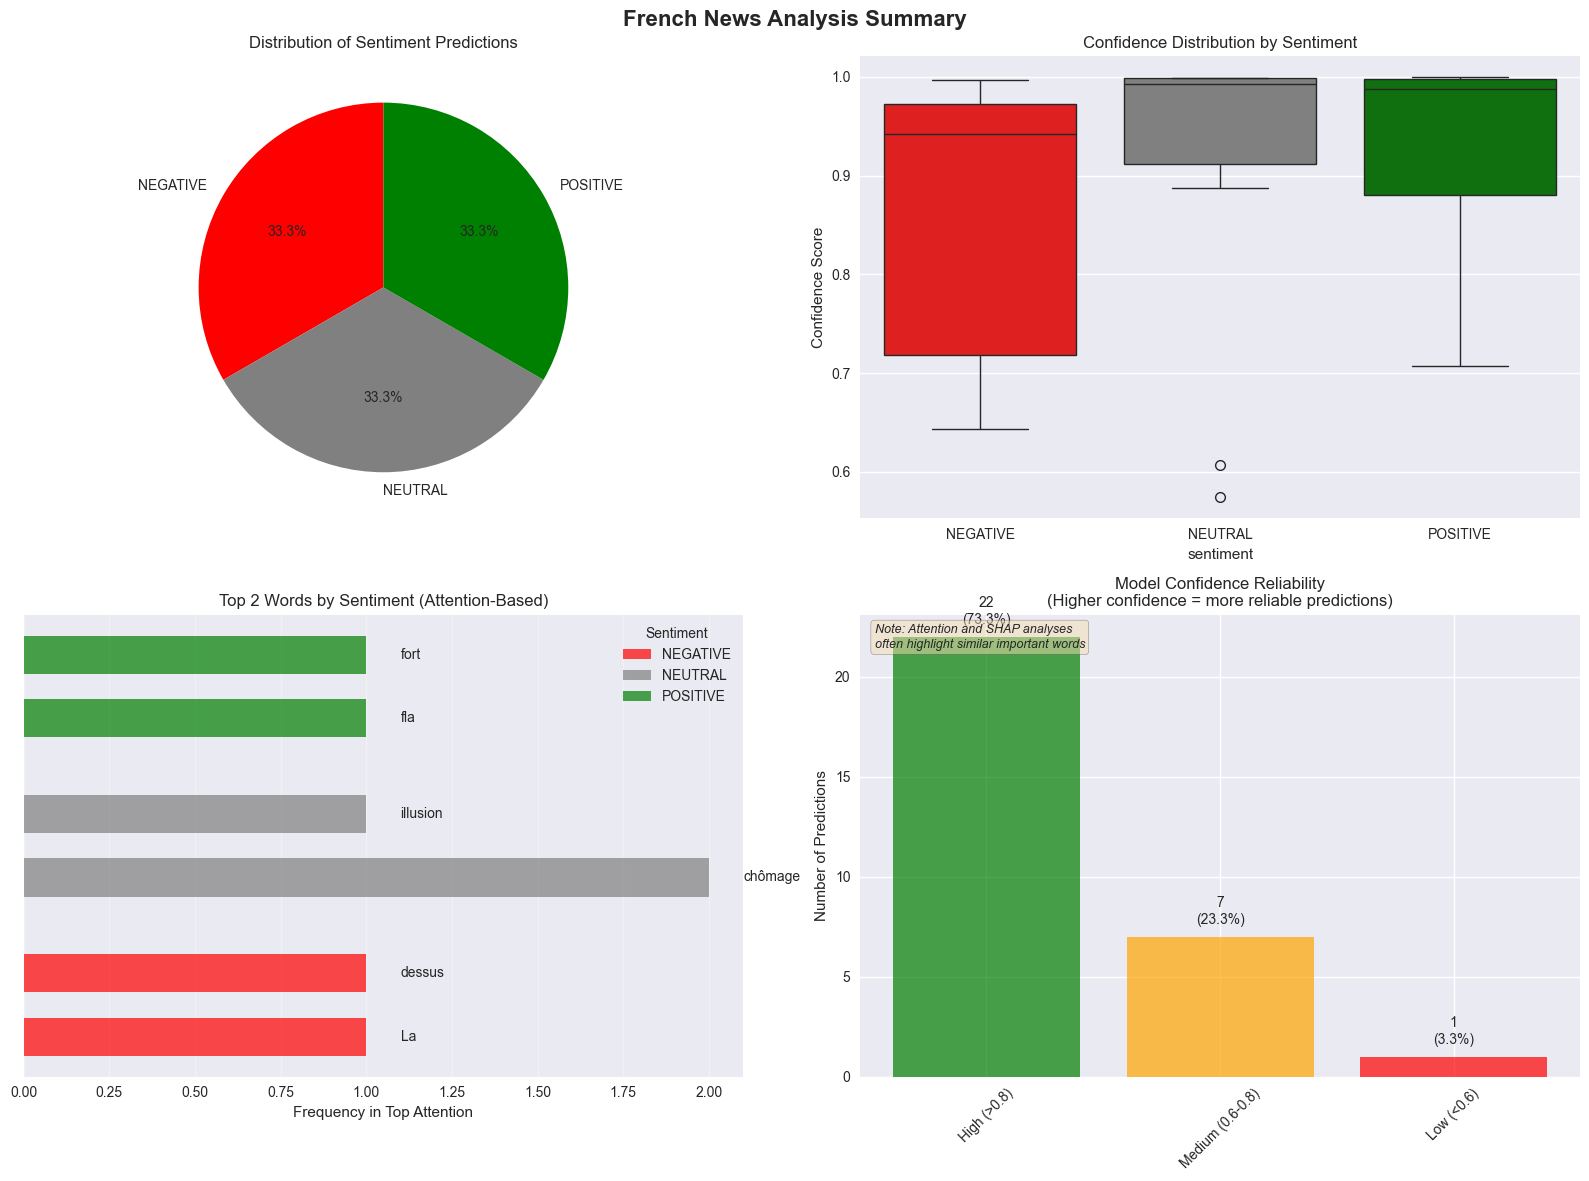


🔍 FRENCH KEY INSIGHTS BY SENTIMENT CATEGORY:

   NEGATIVE:
     • Average confidence: 0.862
     • Confidence range: 0.643 - 0.997
     • Top attended words: La, dessus, France

   NEUTRAL:
     • Average confidence: 0.903
     • Confidence range: 0.574 - 0.999
     • Top attended words: chômage, illusion, Le

   POSITIVE:
     • Average confidence: 0.920
     • Confidence range: 0.707 - 1.000
     • Top attended words: fla, fort, vert

📈 FRENCH OVERALL STATS:
   • Average confidence: 0.895
   • Most common prediction: POSITIVE
   • Overall confidence range: 0.574 - 1.000
   • High confidence predictions (>0.8): 22/30 (73.3%)
   • Low confidence predictions (<0.6): 1/30 (3.3%)


In [16]:
# Analyze French sentences using common function
analyses_fr = analyze_language_sentences(
    random_sentences_fr, "French", pipe, tokenizer_detailed, model_detailed, label_to_sentiment)

# Create French summary analysis using common function
french_summary = create_summary_analysis(analyses_fr, "French")


🔍 SHAP ANALYSIS FOR FRENCH

🔍 SHAP Analysis for French NEGATIVE sentences:


  0%|          | 0/420 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:14, 14.63s/it]               




📈 Representative NEGATIVE example 1: Ouest-France : « La France vit au-dessus de ses moyens depuis trop longtemps »...
🏆 Top SHAP contributors for NEGATIVE:
   'de': -0.3123
   'trop': -0.1641
   'La': -0.1372
   'longtemps': 0.1255
   'France': -0.1055


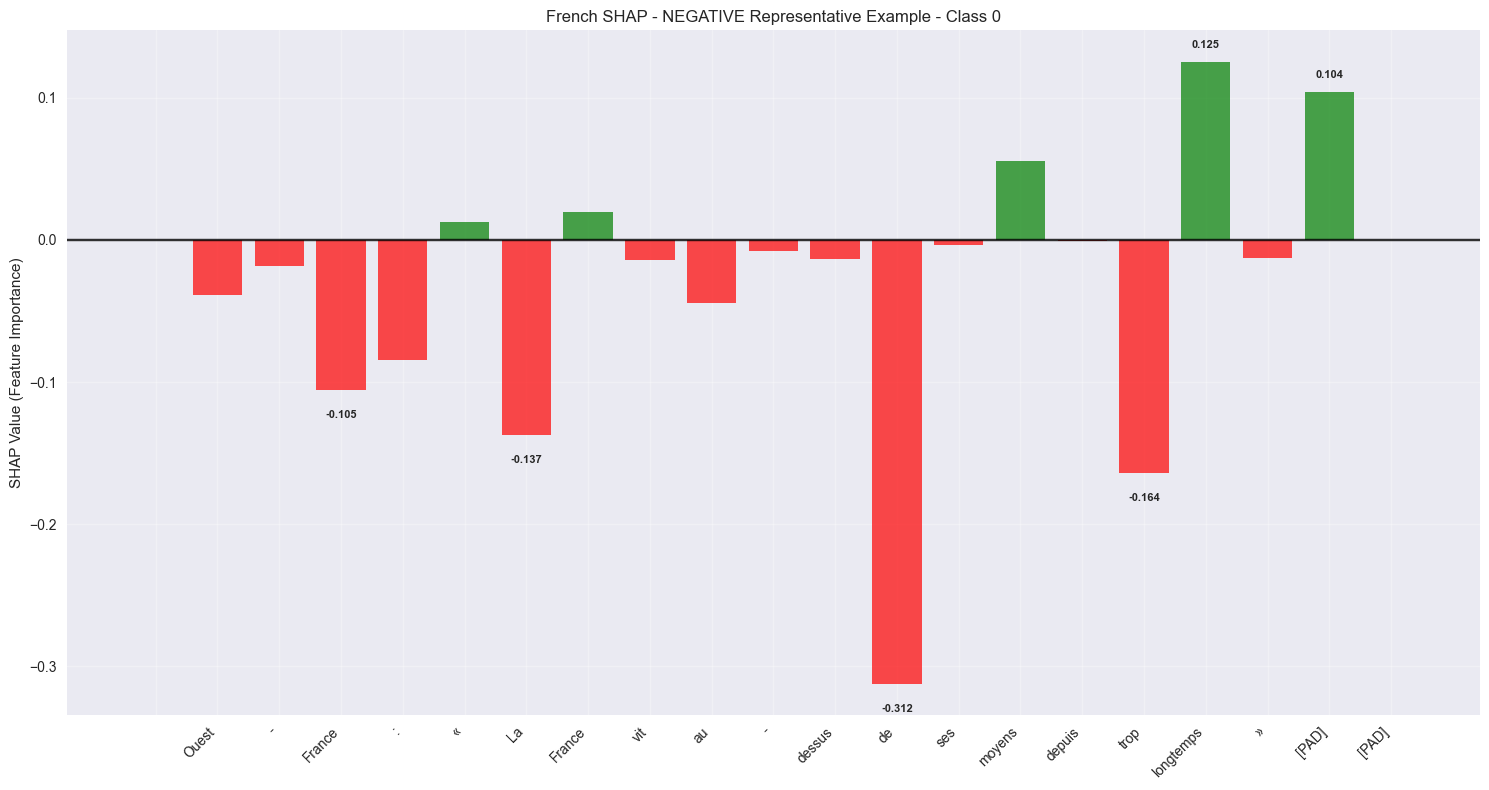

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:19, 19.98s/it]               



  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:20, 20.42s/it]               



  0%|          | 0/342 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:12, 12.94s/it]               



  0%|          | 0/342 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:12, 12.04s/it]               



  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:20, 20.13s/it]               



  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:20, 20.70s/it]               



  0%|          | 0/380 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:19, 19.83s/it]               



  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:19, 19.43s/it]               




📋 SHAP Summary for remaining 9 NEGATIVE sentences:

ID  Preview                                              Top SHAP Words                
------------------------------------------------------------------------------------------
2   Votre fonds ESG pourrait devoir vendre ces actions   vendre, devoir, fonds         
3   Pourquoi l'épisode inflationniste a laissé des tra... tion, les, l                  
4   Du diplôme au chômage : les désillusions de la jeu... :, illusion, s                
5   Le chômage en France repart à la hausse, à 7,4 % a... ,, en, [PAD]                  
6   Face à l’inflation, les hôpitaux crient à l’urgenc... ,, à, les                     
7   Heatflation, Greenflation, Shrinkflation... Les de... fla, Green, ,                 
8   L'Assurance-chômage reste dans le vert, mais ses e... ,, s, mais                    
9   Inflation : payez-vous vos courses plus cher que d... lation, [PAD], pay            
10  CAC 40, Nasdaq, Nikkei… Vers un krach de la Bourse...

  0%|          | 0/420 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:13, 13.08s/it]               


📈 Representative NEUTRAL example 1: Private equity : ce qu'il faut savoir sur l'investissement dans le non coté...
🏆 Top SHAP contributors for NEUTRAL:
   'dans': 0.3284
   'sur': -0.3082
   'ty': 0.1725
   'ce': -0.1607
   'il': 0.1276


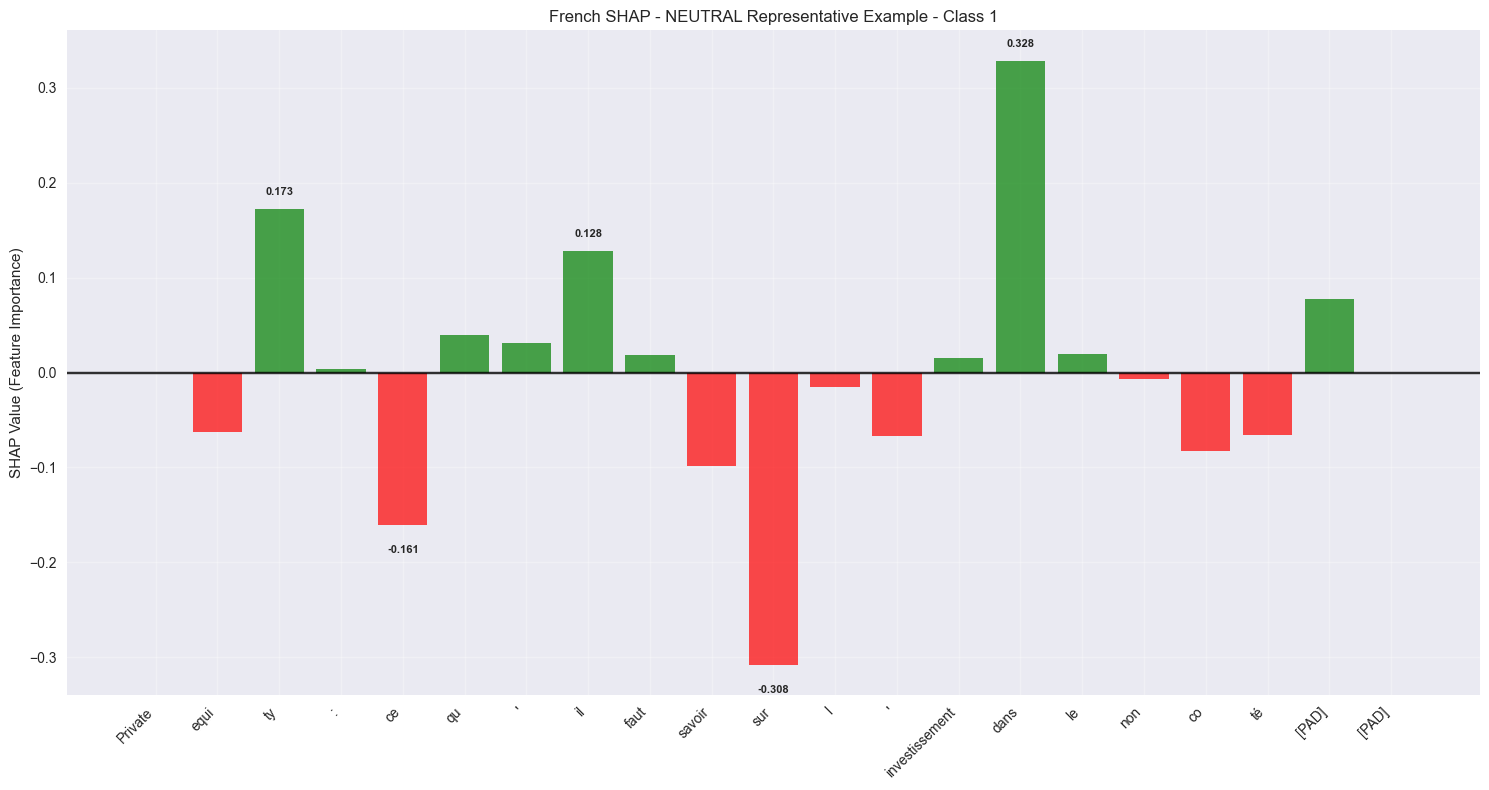

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:19, 19.82s/it]               



  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:20, 20.98s/it]               



  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:19, 19.74s/it]               



  0%|          | 0/182 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:10, 10.82s/it]               



  0%|          | 0/240 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:14, 14.58s/it]               



  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:24, 24.15s/it]               



  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:21, 22.00s/it]               



  0%|          | 0/240 [00:00<?, ?it/s]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:20, 20.61s/it]               




📋 SHAP Summary for remaining 9 NEUTRAL sentences:

ID  Preview                                              Top SHAP Words                
------------------------------------------------------------------------------------------
2   Budget 2024 : les sénateurs augmentent la DGF, mai... mente, ,, nt                  
3   « L’interventionnisme en 2023 n’est pas une politi... le, mais, ’                   
4   JO 2024. Tarifs, sports, régions : les secrets des... s, s, [PAD]                   
5   Inflation : quel impact sur les marchés financiers... s, s, sur                     
6   Investissement média : les discounters sont les pl... issement, les, dé             
7   L'État met 2,9 milliards d'euros dans l'usine de p... dans, de, no                  
8   Pourquoi la baisse du chômage n’a pas entraîné le ... té, né, de                    
9   La Banque du Canada garde le cap sur une inflation... Canada, sur, garde            
10  Note aux Associations et porteurs de projets cultu...

  0%|          | 0/462 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:20, 20.98s/it]               




📈 Representative POSITIVE example 1: Faire du bénévolat peut-il vous priver de l’allocation chômage ?...
🏆 Top SHAP contributors for POSITIVE:
   '[PAD]': -0.2282
   '-': 0.1132
   'chômage': 0.1057
   'ver': 0.1008
   'né': -0.0669


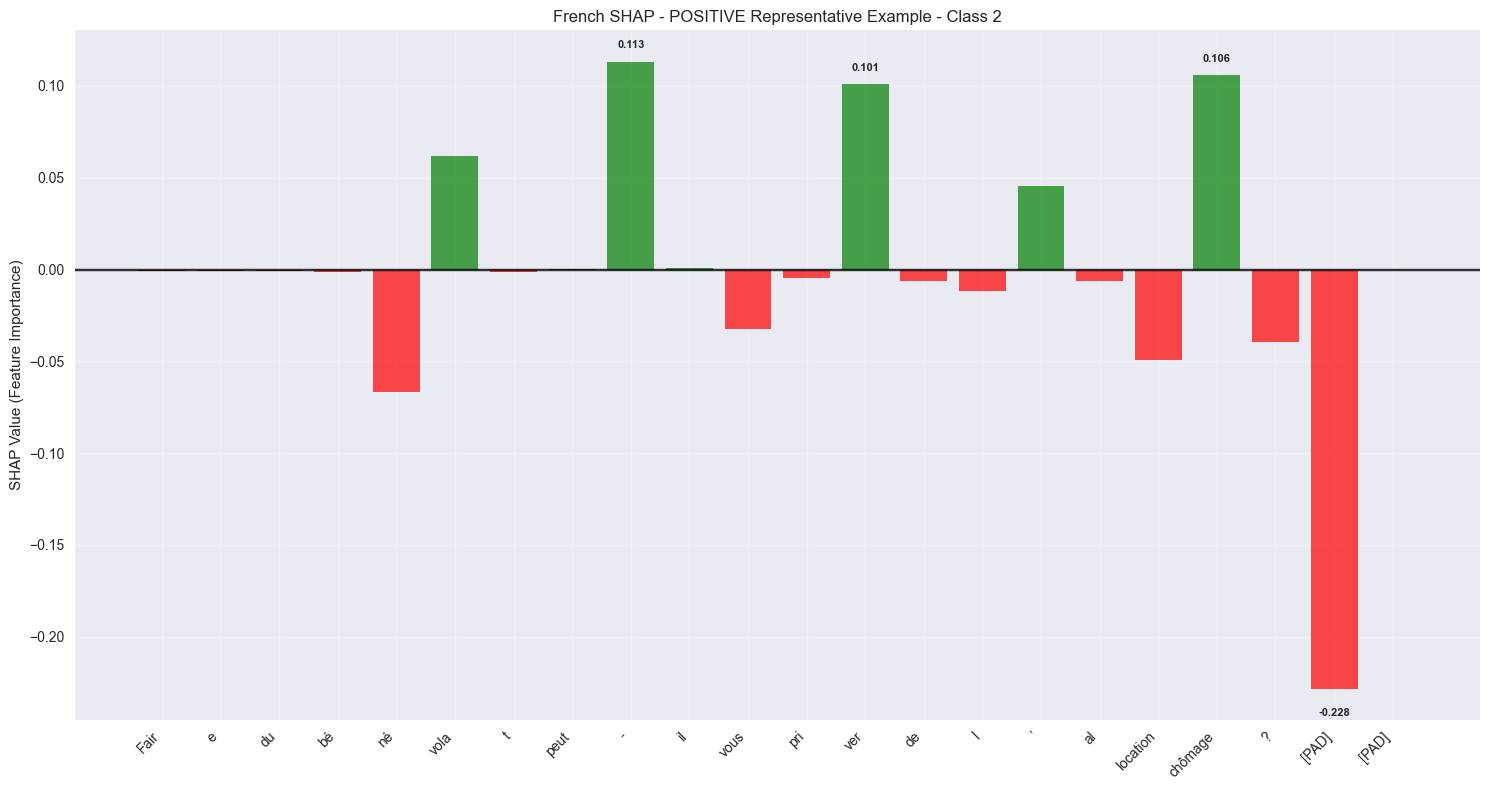

  0%|          | 0/380 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:12, 12.59s/it]               



  0%|          | 0/210 [00:00<?, ?it/s]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:22, 22.48s/it]               



  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:20, 20.34s/it]               



  0%|          | 0/240 [00:00<?, ?it/s]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:21, 21.45s/it]               



  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:20, 20.14s/it]               



  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:21, 21.65s/it]               




📋 SHAP Summary for remaining 9 POSITIVE sentences:

ID  Preview                                              Top SHAP Words                
------------------------------------------------------------------------------------------
2   CLASSEMENT RScE                                      c, [PAD], E                   
3   Placements : les sirènes du non-coté pour dynamise... mis, er, les                  
4   L’immigration : un atout pour le dynamisme économi... un, :, pour                   
5   « La BCE pourrait appliquer des taux d’intérêt moi... élevé, La, »                  
6   Mesurabilité & transparence de l’investissement à ... co, ence, à                   
7   De nouveaux logements et tarifs municipaux pour Ma... s, s, logement                
8   Dispositif Denormandie : les investisseurs bénéfic... s, d, nt                      
9   Backblaze va encore augmenter ses tarifs : 9 $ par... ment, ze, va                  
10  Consommation | Inflation très forte sur le rayon c...

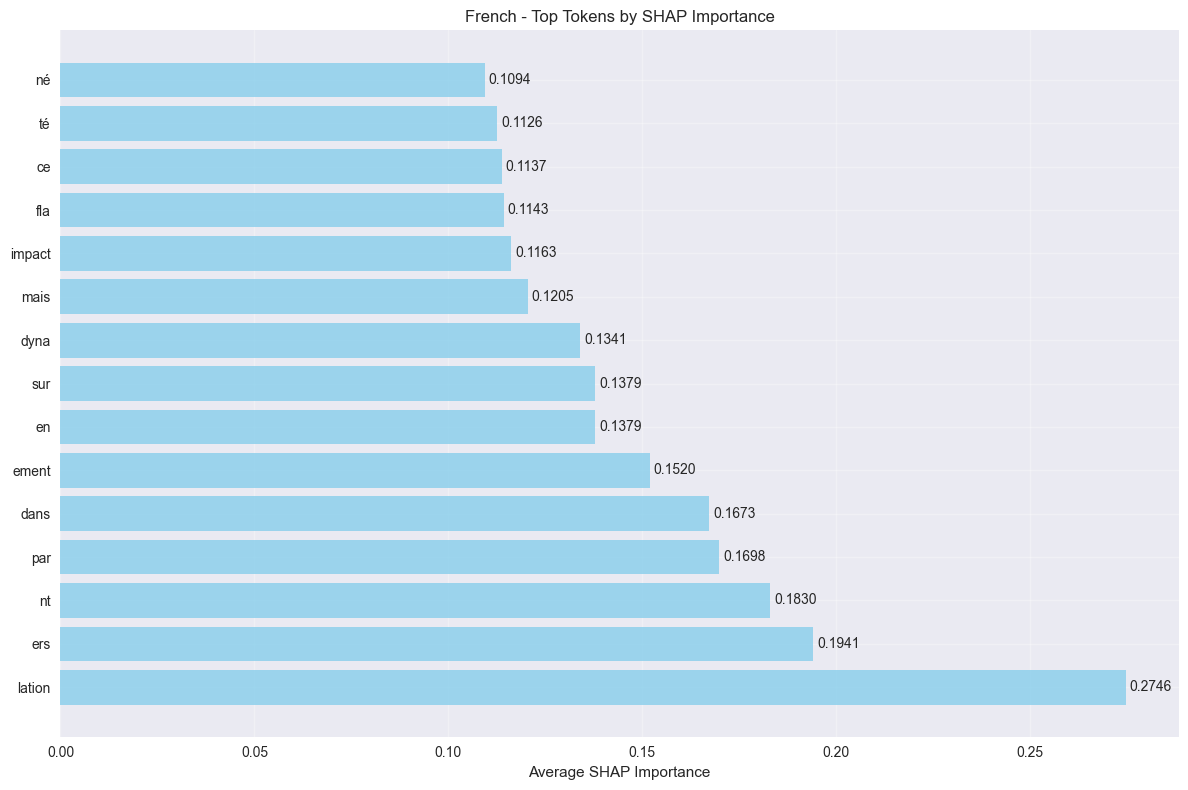


✅ Completed SHAP analysis for French (30 successful analyses with 1 detailed plot(s) per sentiment)


In [17]:
# Perform SHAP Analysis for French with limited plots per sentiment
french_shap_results = perform_shap_analysis_for_language(
        random_sentences_fr, "French", tokenizer_detailed, model_detailed, label_to_sentiment, max_plots_per_sentiment=1)

# German News Data Analysis (DAX)

Analysis of German financial news from DAX 40 index.


In [18]:
# Load and process German news data (DAX)
print(f"Total German news articles available: {len(news_df_de)}")

# Get balanced samples for German news using common function
random_sentences_de, sentiment_distribution_de = get_balanced_sentiment_samples(
    news_df_de, pipe, label_to_sentiment)

print(f"German sentiment distribution: {sentiment_distribution_de}")
print(f"Selected {len(random_sentences_de)} German sentences for analysis:")

Total German news articles available: 200
German sentiment distribution: {'NEGATIVE': 41, 'POSITIVE': 38, 'NEUTRAL': 21}
Selected 30 German sentences for analysis:
German sentiment distribution: {'NEGATIVE': 41, 'POSITIVE': 38, 'NEUTRAL': 21}
Selected 30 German sentences for analysis:


Analyzing German sentences by sentiment category with transformer...


🔴 ANALYZING GERMAN NEGATIVE SENTENCES (10 found)

--------------------------------------------------------------------------------
GERMAN REPRESENTATIVE NEGATIVE SENTENCE 1: EZB senkt Leitzinsen: Die Krux mit der Geldmenge
--------------------------------------------------------------------------------

📊 PREDICTION: NEGATIVE (confidence: 0.998)

📈 CLASS PROBABILITIES:
   NEUTRAL: 0.002
   POSITIVE: 0.000
   NEGATIVE: 0.998

🔍 TOP ATTENDED WORDS:
   'der': 0.0410
   'mit': 0.0408
   'Die': 0.0383
   'nkt': 0.0343
   'Geld': 0.0336


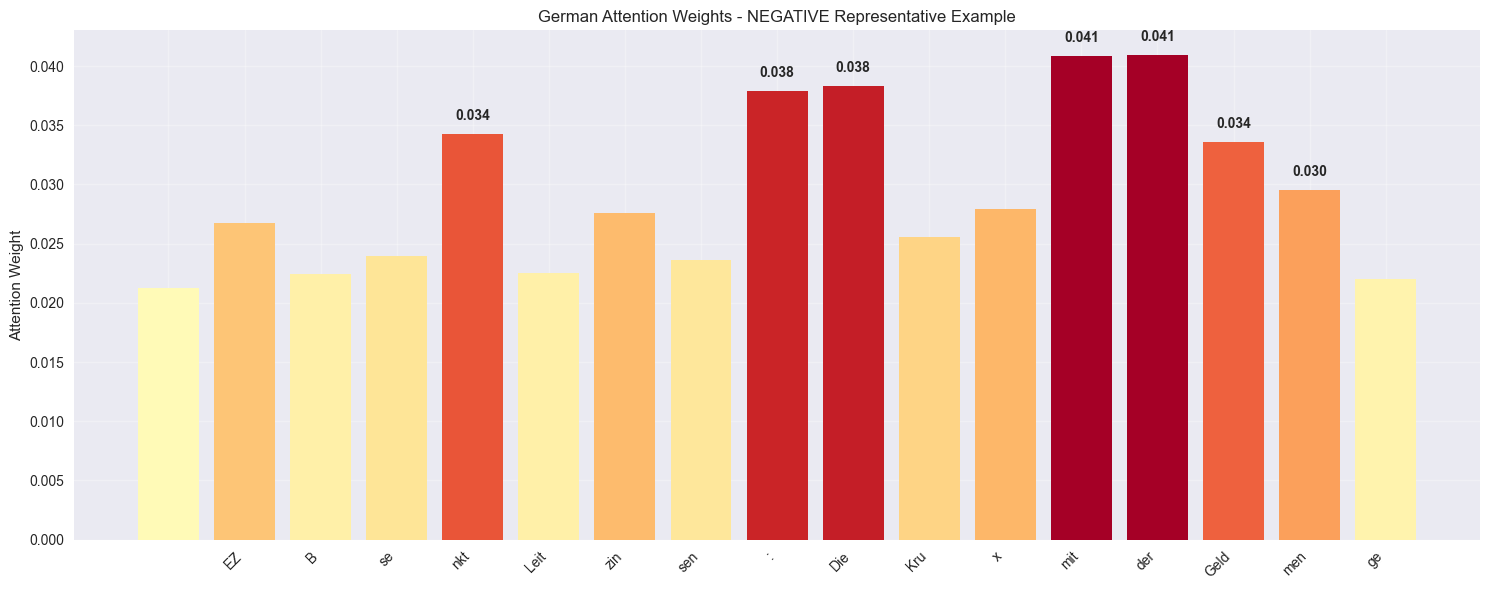


📋 SUMMARY OF REMAINING 9 NEGATIVE SENTENCES:

ID  Preview                                              Conf   Top Attended Words            
-----------------------------------------------------------------------------------------------
2   Dow und Nasdaq Kursrutsch nach Rekordhoch, Aktie v... 0.696  Tesla, nach, und              
3   99er-Inflation in FC 24: Wie EA SPORTS die Höchstw... 0.476  die, fla, wässer              
4   Deutschlands Wirtschaftskrise: Habeck prognostizie... 0.992  und, krise, Deutschland       
5   Doppelte Rezession: Deutschland steckt in einer hi... 0.996  Deutschland, Kris, Rez        
6   Krieg dämpft Israels Wirtschaftswachstum             0.982  Krieg, Israel, Wirtschafts    
7   Börse: Kurssturz bei Mercedes Aktie belastet VW, B... 0.998  und, belast, Mercedes         
8   Japans Zentralbank beendet Minuszinspolitik – nach... 0.986  politik, nach, Minu           
9   US-Zölle von 60 % würden Chinas Wachstumsrate laut... 0.997  Wachstum, halb, China     

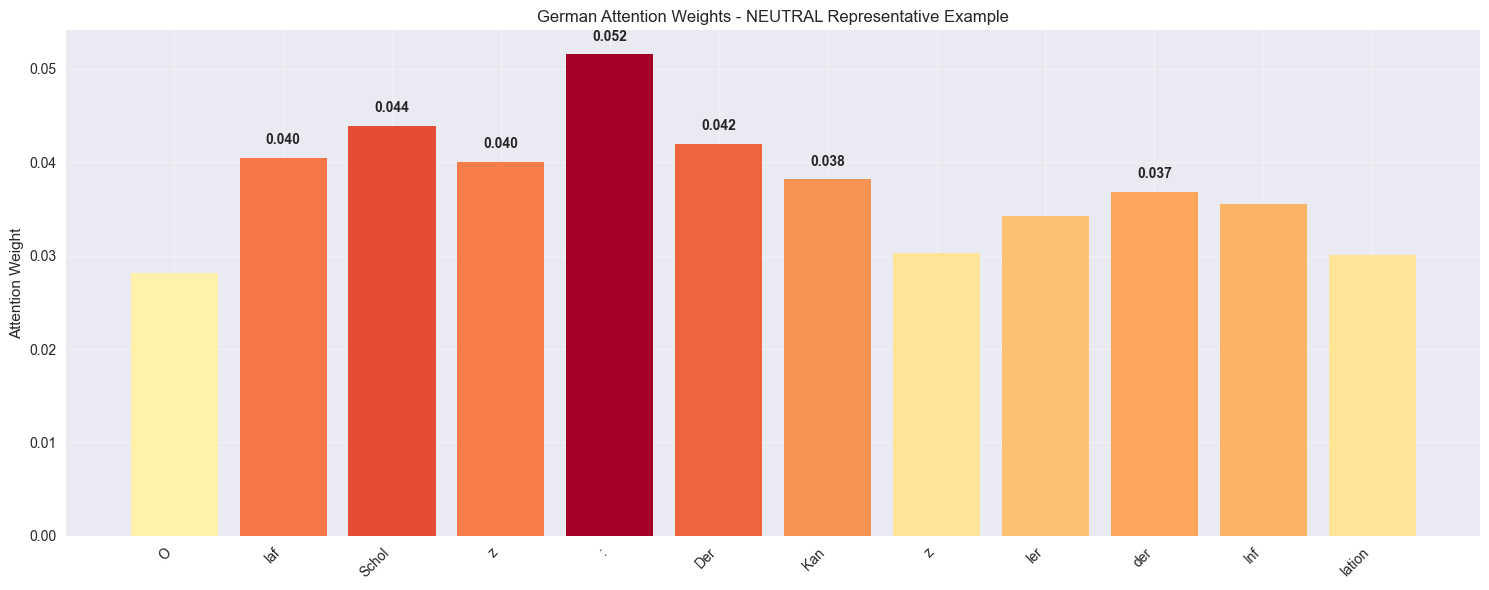


📋 SUMMARY OF REMAINING 9 NEUTRAL SENTENCES:

ID  Preview                                              Conf   Top Attended Words            
-----------------------------------------------------------------------------------------------
2   Wirtschaftsstandort | USA                            0.999  USA, ort, stand               
3   Von der Inflation zur Hyperinflation: Rückblick in... 0.893  1923, inf, zur                
4   Corona und das Abitur: Einser-Inflation beim Abitu... 0.915  fla, und, bitur               
5   425.000-Euro-Investition                             0.966  Invest, Euro, 5.000           
6   Darf’s ein bisschen weniger sein?                    0.990  weniger, Dar, sein            
7   SAP will Belegschaft in „Bringer“ und „Nicht-Bring... 0.902  in, teilen, und               
8   Trump-Zölle: Was sind "Strafzölle" und wie funktio... 0.947  funktionieren, und, Trump     
9   Dead Island 2: Expansion-Pass erhältlich, Preis, I... 0.955  erhältlich, Pass, 2:         

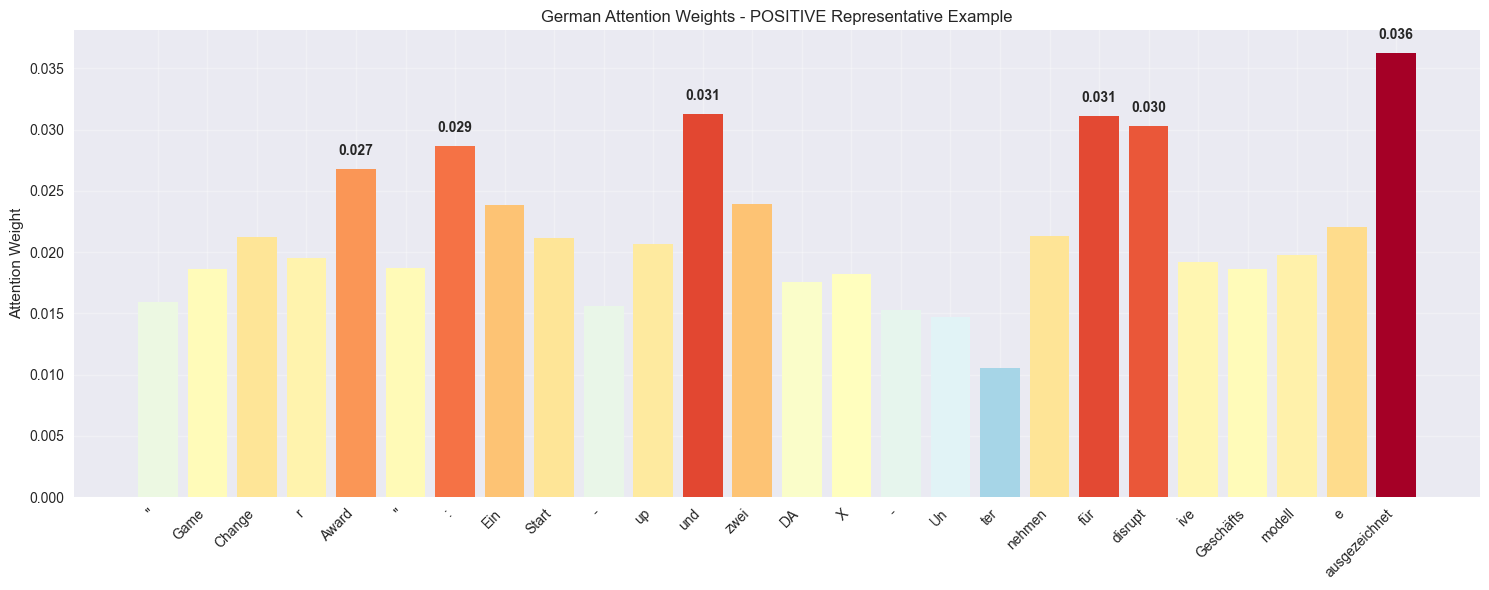


📋 SUMMARY OF REMAINING 9 POSITIVE SENTENCES:

ID  Preview                                              Conf   Top Attended Words            
-----------------------------------------------------------------------------------------------
2   DAX-Rekordhoch: Du wirst überrascht sein, was die ... 0.999  besten, was, überrascht       
3   Wie der Ölpreis die globale Wirtschaft vor einer R... 0.969  Wie, der, preis               
4   500 Prozent in zwei Jahren – Erdogans verrückter I... 0.999  Erdogan, Prozent, er          
5   BaFin verlangt höhere Versicherungsprämien           0.849  höhere, verlangt, in          
6   Inflation frisst Lohnsteigerungen 2023 auf           0.999  2023, steiger, friss          
7   Dax Rekordhoch über 19.400 Punkten, Kursrally an d... 1.000  über, ally, Rekord            
8   Paris: EU wird Strafzölle wegen neuer US-Zölle für... 0.807  hängen, Straf, wird           
9   Wegen Sondereffekt: Inflationsrate steigt deutlich... 0.999  steigt, Inf, Prozent       

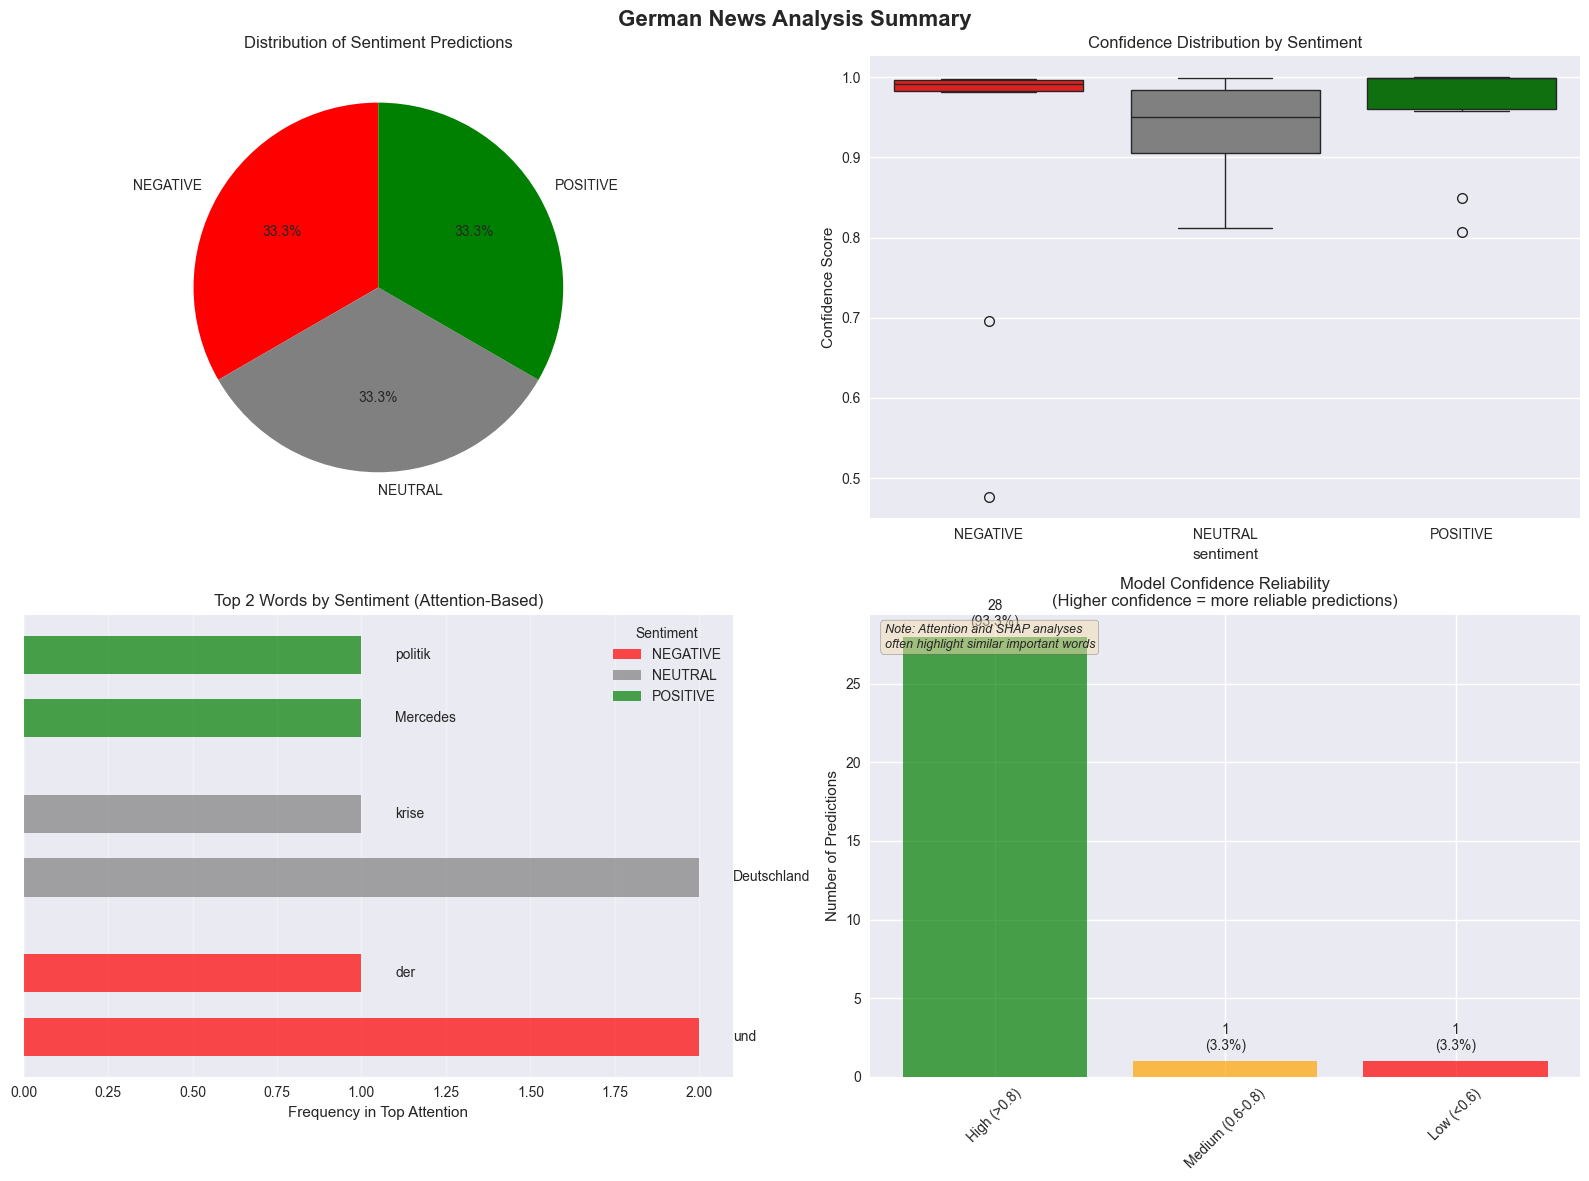


🔍 GERMAN KEY INSIGHTS BY SENTIMENT CATEGORY:

   NEGATIVE:
     • Average confidence: 0.911
     • Confidence range: 0.476 - 0.998
     • Top attended words: und, der, mit

   NEUTRAL:
     • Average confidence: 0.938
     • Confidence range: 0.812 - 0.999
     • Top attended words: Deutschland, krise, Kris

   POSITIVE:
     • Average confidence: 0.958
     • Confidence range: 0.807 - 1.000
     • Top attended words: Mercedes, politik, nach

📈 GERMAN OVERALL STATS:
   • Average confidence: 0.936
   • Most common prediction: POSITIVE
   • Overall confidence range: 0.476 - 1.000
   • High confidence predictions (>0.8): 28/30 (93.3%)
   • Low confidence predictions (<0.6): 1/30 (3.3%)


In [19]:
# Analyze German sentences using common function
analyses_de = analyze_language_sentences(
    random_sentences_de, "German", pipe, tokenizer_detailed, model_detailed, label_to_sentiment)

# Create German summary analysis using common function
german_summary = create_summary_analysis(analyses_de, "German")


🔍 SHAP ANALYSIS FOR GERMAN

🔍 SHAP Analysis for German NEGATIVE sentences:


  0%|          | 0/342 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:12, 12.32s/it]               


📈 Representative NEGATIVE example 1: EZB senkt Leitzinsen: Die Krux mit der Geldmenge...
🏆 Top SHAP contributors for NEGATIVE:
   'Leit': -0.2969
   'B': -0.2600
   'Die': 0.2486
   'der': -0.1476
   'se': -0.1318


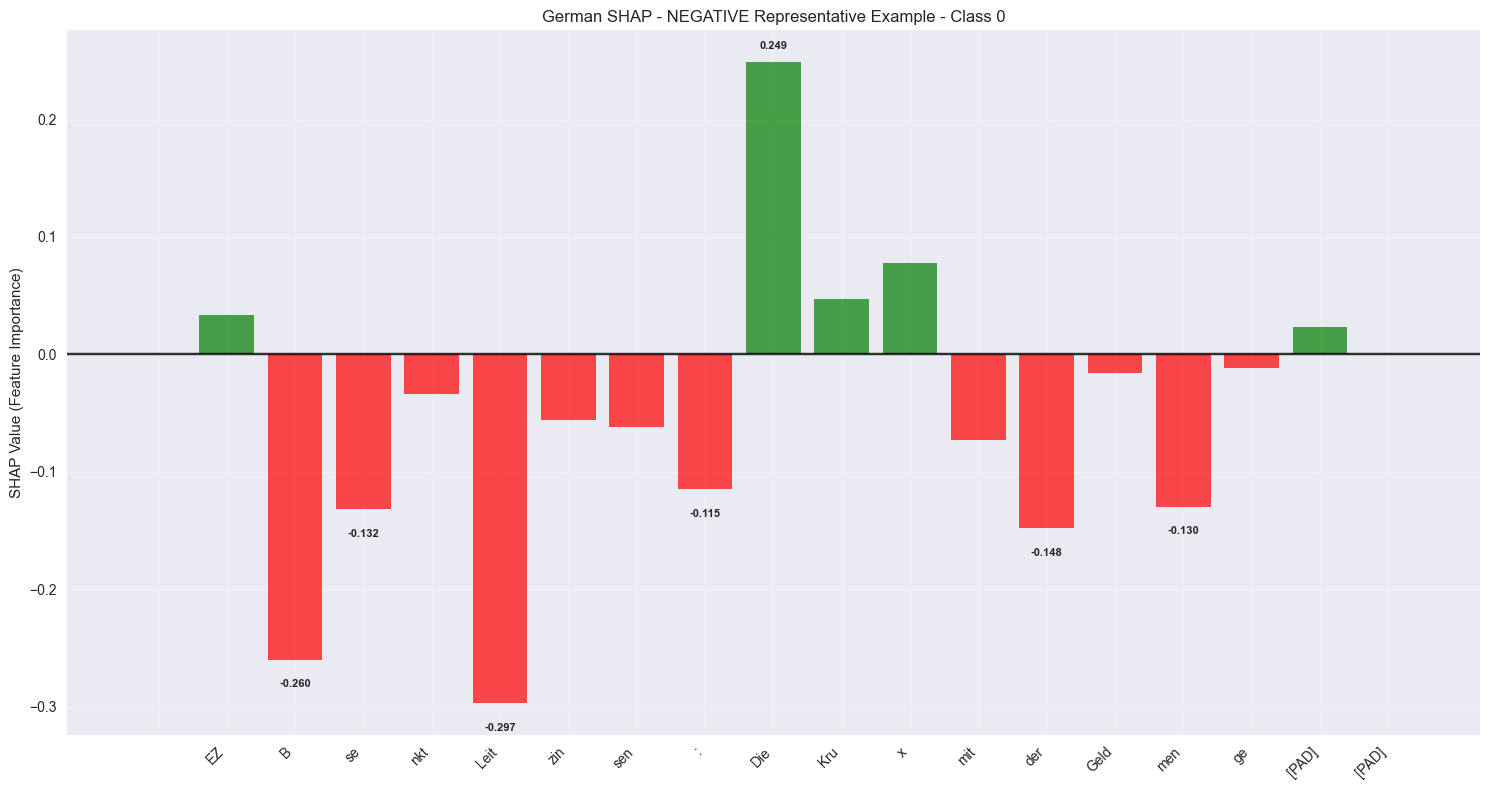

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:18, 18.03s/it]               



  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:19, 19.46s/it]               



  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:22, 22.10s/it]               



  0%|          | 0/240 [00:00<?, ?it/s]

  0%|          | 0/380 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:16, 16.40s/it]               



  0%|          | 0/240 [00:00<?, ?it/s]

  0%|          | 0/420 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:15, 15.51s/it]               



  0%|          | 0/380 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:12, 12.96s/it]               




📋 SHAP Summary for remaining 9 NEGATIVE sentences:

ID  Preview                                              Top SHAP Words                
------------------------------------------------------------------------------------------
2   Dow und Nasdaq Kursrutsch nach Rekordhoch, Aktie v... k, und, von                   
3   99er-Inflation in FC 24: Wie EA SPORTS die Höchstw... tion, ung, SPORT              
4   Deutschlands Wirtschaftskrise: Habeck prognostizie... :, wier, ige                  
5   Doppelte Rezession: Deutschland steckt in einer hi... e, te, :                      
6   Krieg dämpft Israels Wirtschaftswachstum             [PAD], , Israel               
7   Börse: Kurssturz bei Mercedes Aktie belastet VW, B... und, ,, BMW                   
8   Japans Zentralbank beendet Minuszinspolitik – nach... sz, s, 17                     
9   US-Zölle von 60 % würden Chinas Wachstumsrate laut... -, ieren, s                   
10  Global Risk: Frankreich droht eine Rezession – Mac...

  0%|          | 0/240 [00:00<?, ?it/s]


📈 Representative NEUTRAL example 1: Türkei: Zentralbankchefin Erkan soll Familie begünstigt haben...
🏆 Top SHAP contributors for NEUTRAL:
   't': 0.6028
   'in': -0.3433
   'soll': 0.3315
   'chef': -0.3076
   ':': 0.2858


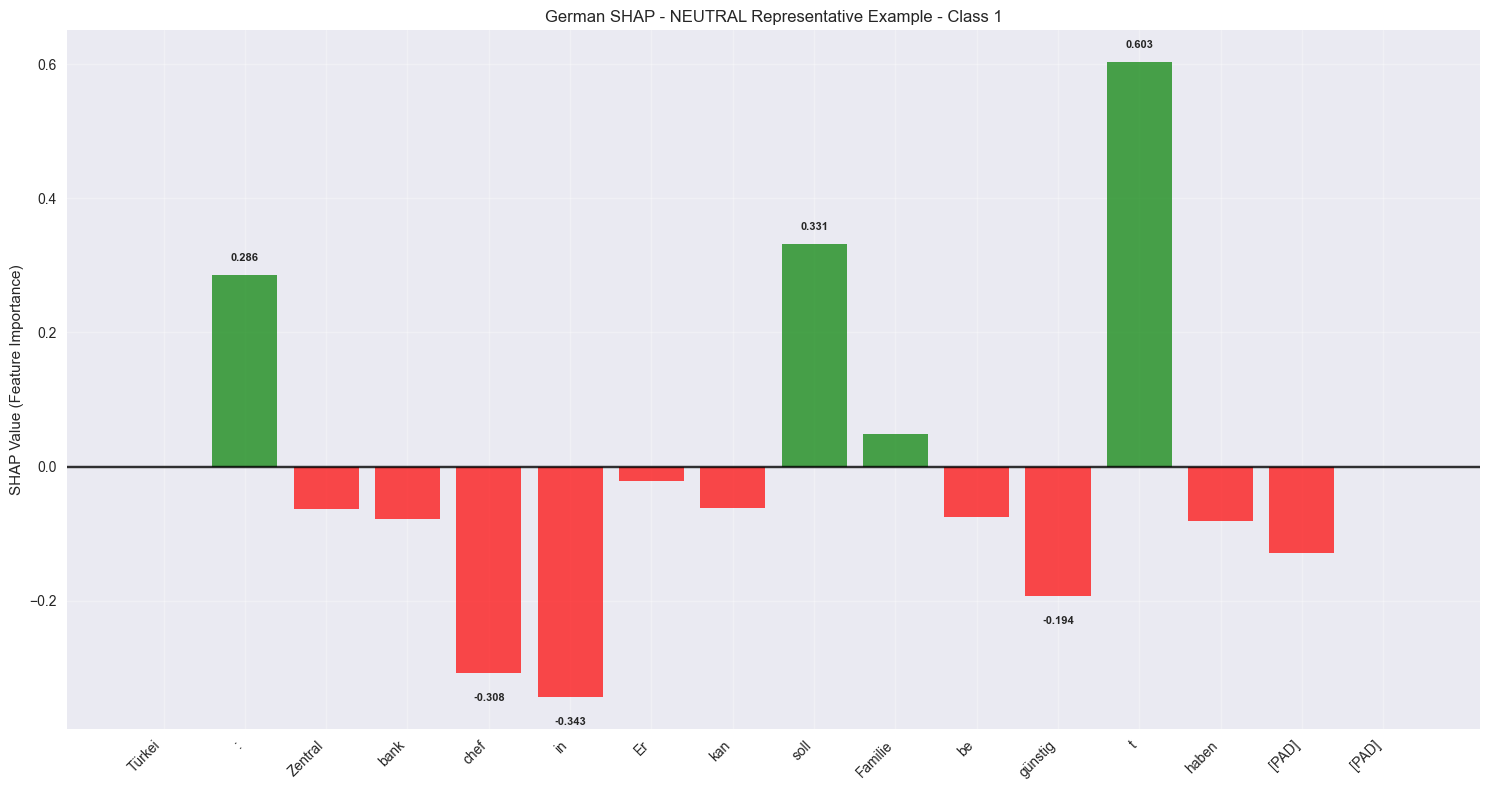

  0%|          | 0/380 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:13, 13.75s/it]               



  0%|          | 0/462 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:20, 20.14s/it]               



  0%|          | 0/462 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:14, 14.43s/it]               



  0%|          | 0/110 [00:00<?, ?it/s]

  0%|          | 0/272 [00:00<?, ?it/s]

  0%|          | 0/272 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:10, 10.92s/it]               



  0%|          | 0/182 [00:00<?, ?it/s]


📋 SHAP Summary for remaining 9 NEUTRAL sentences:

ID  Preview                                              Top SHAP Words                
------------------------------------------------------------------------------------------
2   Dead Island 2: Expansion-Pass erhältlich, Preis, I... und, an, ,                    
3   Trump-Zölle: Was sind "Strafzölle" und wie funktio... öl, -, [PAD]                  
4   SAP will Belegschaft in „Bringer“ und „Nicht-Bring... teilen, will, “               
5   Darf’s ein bisschen weniger sein?                    [PAD], f, bisschen            
6   425.000-Euro-Investition                             -, tion, -                    
7   Corona und das Abitur: Einser-Inflation beim Abitu... :, [PAD], In                  
8   Von der Inflation zur Hyperinflation: Rückblick in... zur, [PAD], Inf               
9   Wirtschaftsstandort | USA                            , ort, stand                  
10  Olaf Scholz: Der Kanzler der Inflation               laf

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:20, 20.08s/it]               




📈 Representative POSITIVE example 1: "Game Changer Award": Ein Start-up und zwei DAX-Unternehmen für disruptive Gesch...
🏆 Top SHAP contributors for POSITIVE:
   'nehmen': -0.0505
   'für': 0.0460
   'r': 0.0457
   '"': -0.0303
   'ive': 0.0243


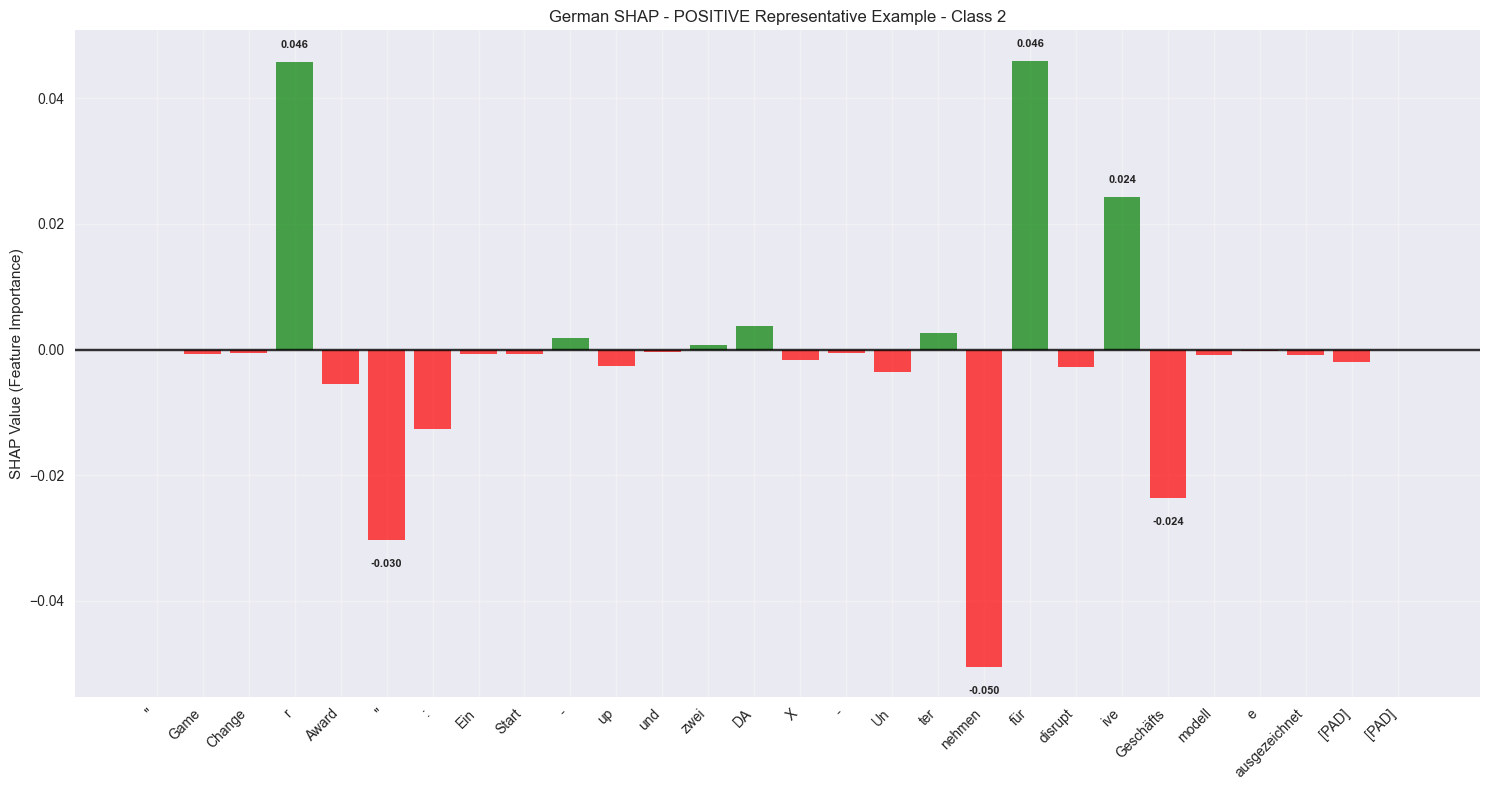

  0%|          | 0/462 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:17, 17.77s/it]               



  0%|          | 0/272 [00:00<?, ?it/s]

  0%|          | 0/272 [00:00<?, ?it/s]

  0%|          | 0/380 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:12, 12.39s/it]               



  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:15, 15.94s/it]               



  0%|          | 0/306 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:15, 15.15s/it]               



  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:20, 20.69s/it]               




📋 SHAP Summary for remaining 9 POSITIVE sentences:

ID  Preview                                              Top SHAP Words                
------------------------------------------------------------------------------------------
2   DAX-Rekordhoch: Du wirst überrascht sein, was die ... überrascht, sein, besten      
3   Wie der Ölpreis die globale Wirtschaft vor einer R... rt, es, wah                   
4   500 Prozent in zwei Jahren – Erdogans verrückter I... Erdogan, ver, Jahren          
5   BaFin verlangt höhere Versicherungsprämien           höhere, mien, Versicherungs   
6   Inflation frisst Lohnsteigerungen 2023 auf           ungen, lation, auf            
7   Dax Rekordhoch über 19.400 Punkten, Kursrally an d... an, r, ally                   
8   Paris: EU wird Strafzölle wegen neuer US-Zölle für... z, neuer, ver                 
9   Wegen Sondereffekt: Inflationsrate steigt deutlich... deutlich, effekt, steigt      
10  [PLUS] Geforce RTX 4090: Aufrüstbericht und PCGH-I... 

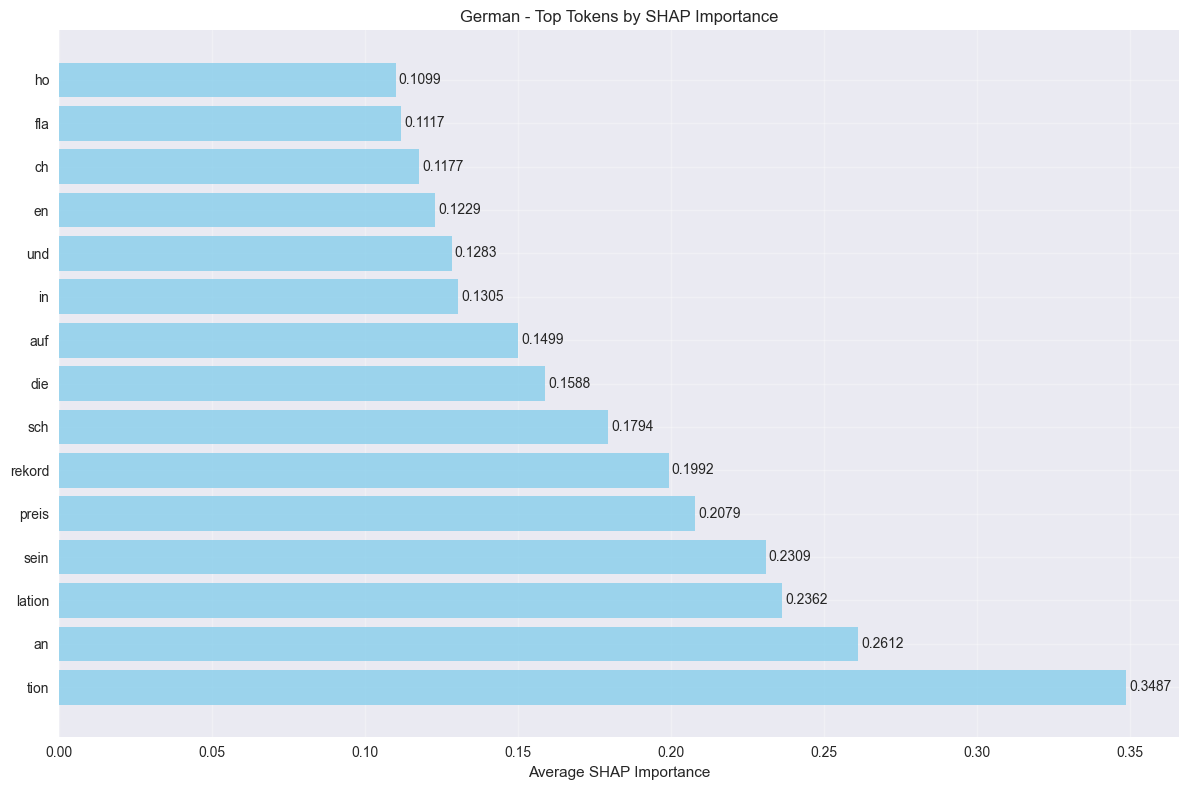


✅ Completed SHAP analysis for German (30 successful analyses with 1 detailed plot(s) per sentiment)


In [20]:
# Perform SHAP Analysis for German with limited plots per sentiment
german_shap_results = perform_shap_analysis_for_language(
        random_sentences_de, "German", tokenizer_detailed, model_detailed, label_to_sentiment, max_plots_per_sentiment=1)

# Cross-Language Comparative Analysis


🌍 CROSS-LANGUAGE TRANSFORMER INTERPRETATION COMPARISON


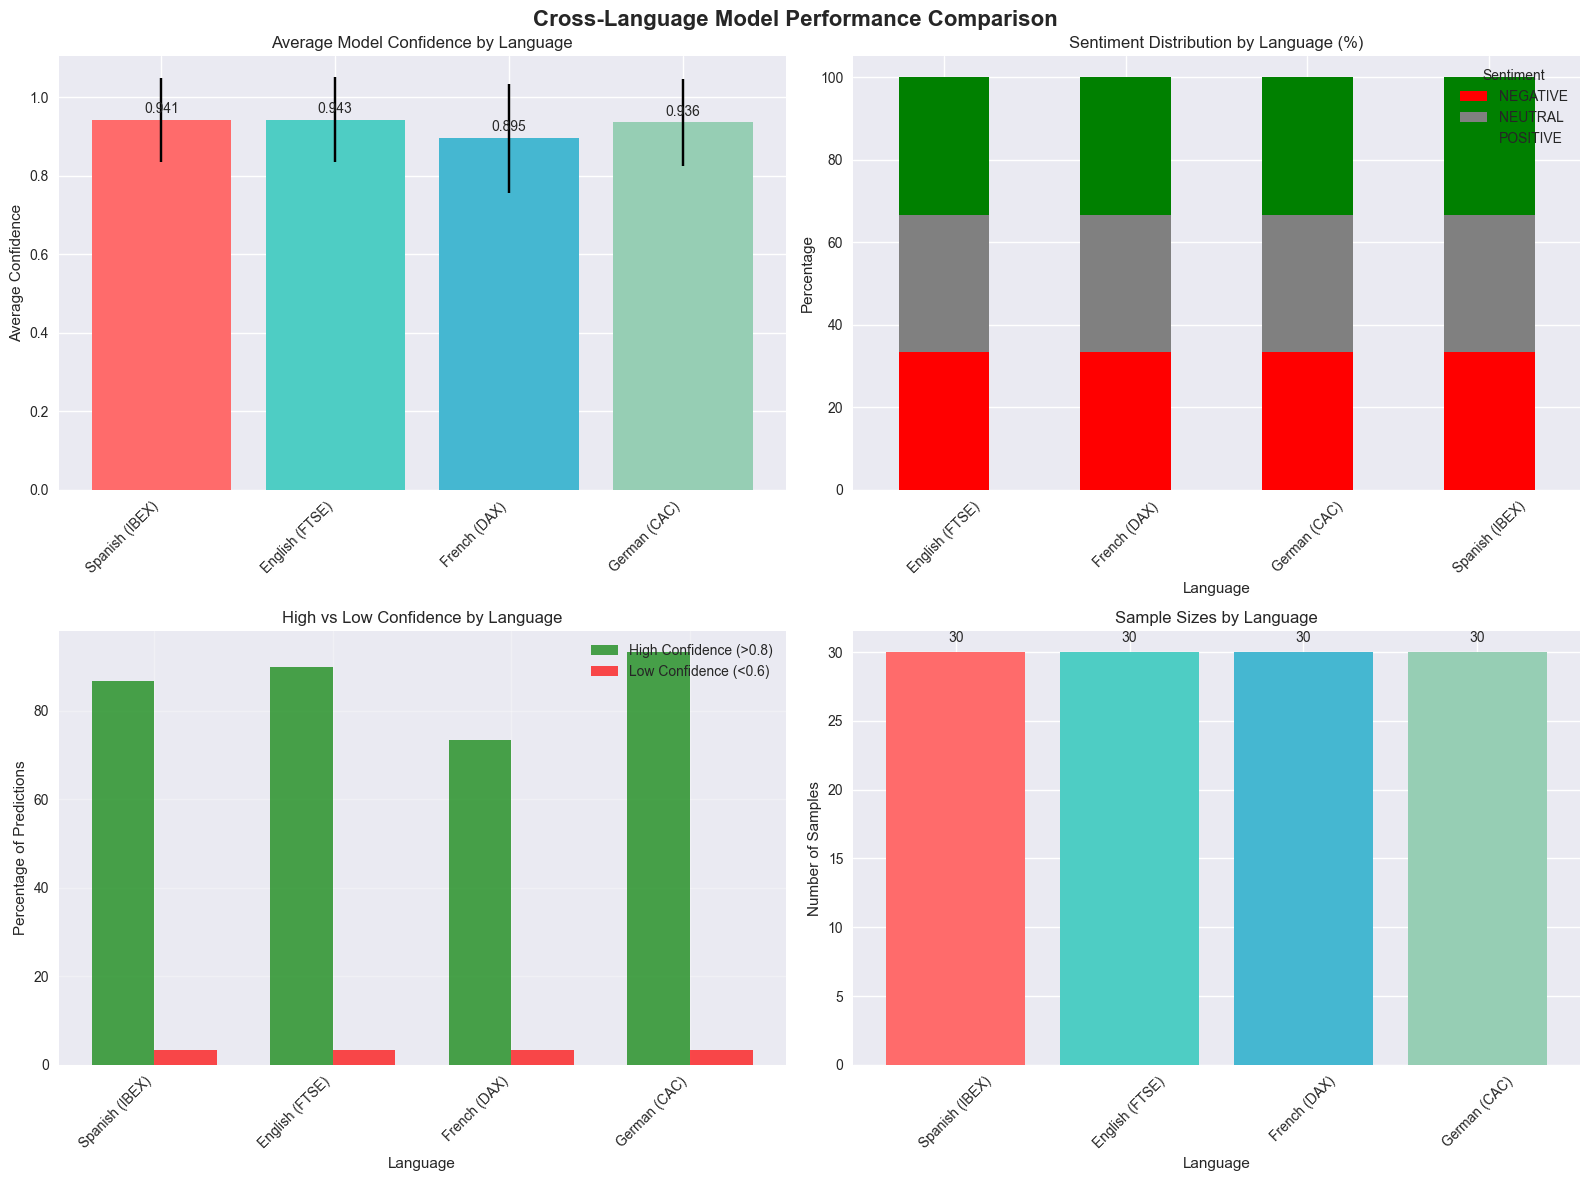


📊 COMPARATIVE STATISTICS:

Spanish (IBEX):
   • Sample size: 30
   • Average confidence: 0.941
   • Confidence std: 0.107
   • Sentiment distribution: {'NEGATIVE': 33.3, 'NEUTRAL': 33.3, 'POSITIVE': 33.3}
   • High confidence (>0.8): 26/30 (86.7%)
   • Low confidence (<0.6): 1/30 (3.3%)

English (FTSE):
   • Sample size: 30
   • Average confidence: 0.943
   • Confidence std: 0.109
   • Sentiment distribution: {'NEGATIVE': 33.3, 'NEUTRAL': 33.3, 'POSITIVE': 33.3}
   • High confidence (>0.8): 27/30 (90.0%)
   • Low confidence (<0.6): 1/30 (3.3%)

French (DAX):
   • Sample size: 30
   • Average confidence: 0.895
   • Confidence std: 0.140
   • Sentiment distribution: {'NEGATIVE': 33.3, 'NEUTRAL': 33.3, 'POSITIVE': 33.3}
   • High confidence (>0.8): 22/30 (73.3%)
   • Low confidence (<0.6): 1/30 (3.3%)

German (CAC):
   • Sample size: 30
   • Average confidence: 0.936
   • Confidence std: 0.112
   • Sentiment distribution: {'NEGATIVE': 33.3, 'NEUTRAL': 33.3, 'POSITIVE': 33.3}
   • High co

In [21]:
# Collect data from all languages
language_data = {
    'Spanish (IBEX)': {
        'analyses': analyses_es if 'analyses' in globals() else [],
        'predictions': spanish_summary['predictions'] if 'spanish_summary' in globals() and spanish_summary else [],
        'confidences': spanish_summary['confidences'] if 'spanish_summary' in globals() and spanish_summary else []
    },
    'English (FTSE)': {
        'analyses': analyses_en if 'analyses_en' in globals() else [],
        'predictions': english_summary['predictions'] if 'english_summary' in globals() and english_summary else [],
        'confidences': english_summary['confidences'] if 'english_summary' in globals() and english_summary else []
    },
    'French (DAX)': {
        'analyses': analyses_fr if 'analyses_fr' in globals() else [],
        'predictions': french_summary['predictions'] if 'french_summary' in globals() and french_summary else [],
        'confidences': french_summary['confidences'] if 'french_summary' in globals() and french_summary else []
    },
    'German (CAC)': {
        'analyses': analyses_de if 'analyses_de' in globals() else [],
        'predictions': german_summary['predictions'] if 'german_summary' in globals() and german_summary else [],
        'confidences': german_summary['confidences'] if 'german_summary' in globals() and german_summary else []
    }
}

# Create cross-language comparison using common function
comparison_results = create_cross_language_comparison(language_data)

In [22]:

print("\n" + "="*100)
print("🌍 CROSS-LANGUAGE TRANSFORMER INTERPRETATION COMPARISON")
print("="*100)
# Statistical significance tests (if scipy is available)
try:
    from scipy import stats
    print("\n🔬 STATISTICAL TESTS:")
    
    # Collect confidence data for languages with data
    lang_confidences = {}
    for lang, data in language_data.items():
        if data['confidences']:
            lang_confidences[lang] = data['confidences']
    
    # Pairwise t-tests between languages
    lang_pairs = list(lang_confidences.keys())
    if len(lang_pairs) >= 2:
        print("\nPairwise t-tests for confidence differences:")
        for i in range(len(lang_pairs)):
            for j in range(i+1, len(lang_pairs)):
                lang1, lang2 = lang_pairs[i], lang_pairs[j]
                if len(lang_confidences[lang1]) > 1 and len(lang_confidences[lang2]) > 1:
                    t_stat, p_value = stats.ttest_ind(lang_confidences[lang1], lang_confidences[lang2])
                    significance = "***" if p_value < 0.001 else "**" if p_value < 0.01 else "*" if p_value < 0.05 else "ns"
                    print(f"   {lang1} vs {lang2}: t={t_stat:.3f}, p={p_value:.4f} {significance}")
except ImportError:
    print("\n📝 Note: Install scipy for statistical significance tests")

print("\n\n✅ Cross-language comparative analysis completed!")


🌍 CROSS-LANGUAGE TRANSFORMER INTERPRETATION COMPARISON

🔬 STATISTICAL TESTS:

Pairwise t-tests for confidence differences:
   Spanish (IBEX) vs English (FTSE): t=-0.041, p=0.9675 ns
   Spanish (IBEX) vs French (DAX): t=1.419, p=0.1613 ns
   Spanish (IBEX) vs German (CAC): t=0.201, p=0.8410 ns
   English (FTSE) vs French (DAX): t=1.444, p=0.1542 ns
   English (FTSE) vs German (CAC): t=0.240, p=0.8115 ns
   French (DAX) vs German (CAC): t=-1.219, p=0.2277 ns


✅ Cross-language comparative analysis completed!



🔍 CROSS-LANGUAGE SHAP COMPARISON


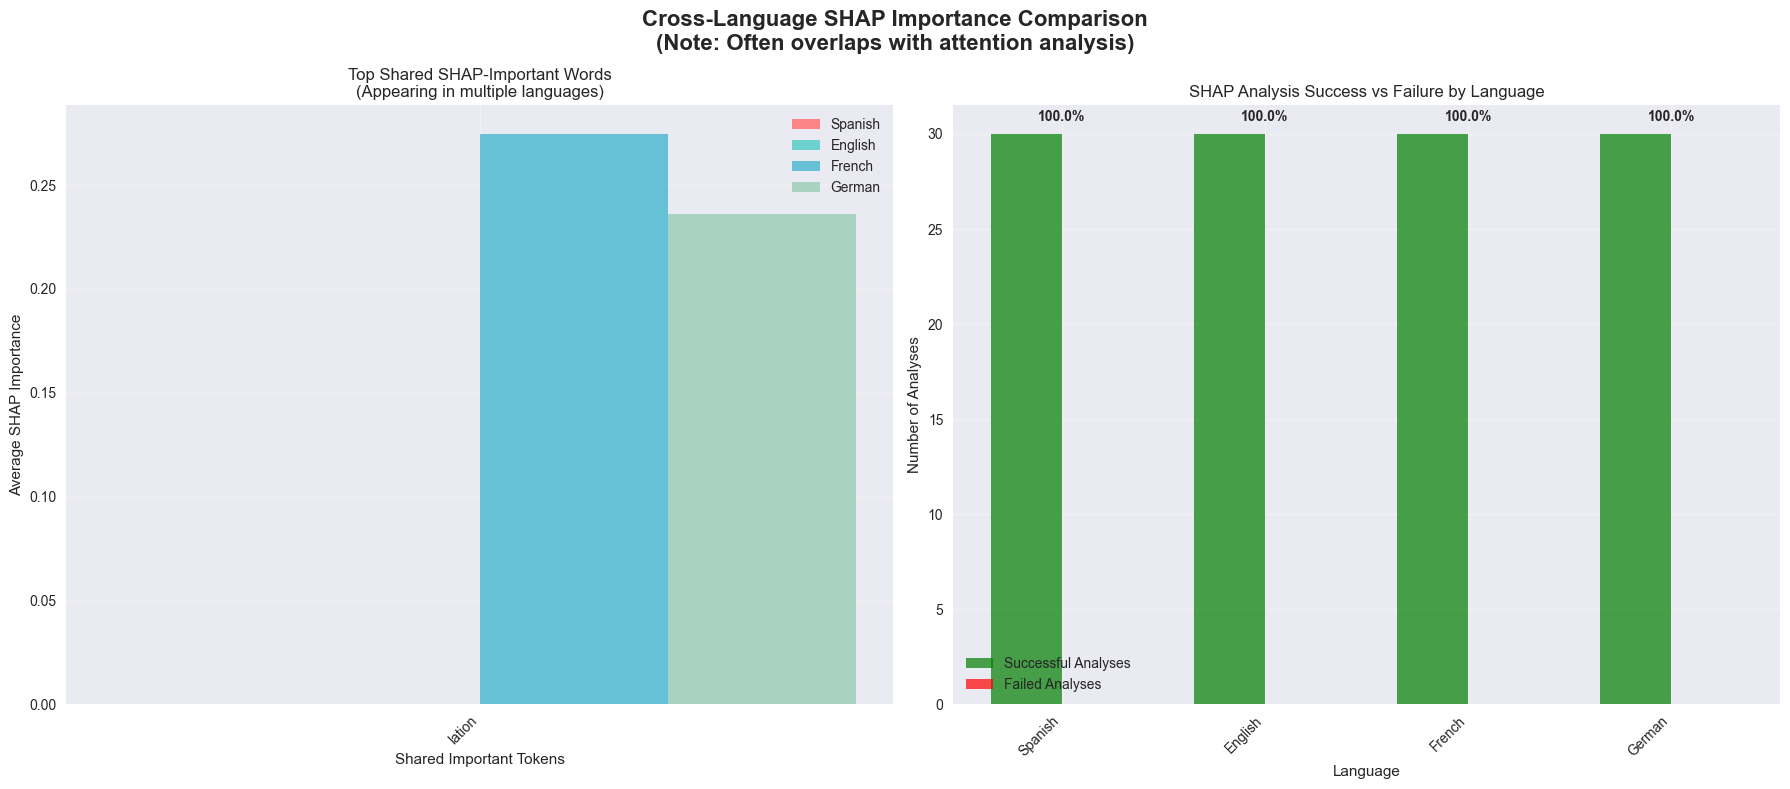


📊 CROSS-LANGUAGE SHAP INSIGHTS:

Spanish (IBEX):
   • SHAP analysis success: 30/30 (100.0%)
   • Top token importance range: 0.2739 - 0.3228

English (FTSE):
   • SHAP analysis success: 30/30 (100.0%)
   • Top token importance range: 0.2408 - 0.2450

French (DAX):
   • SHAP analysis success: 30/30 (100.0%)
   • Top token importance range: 0.1941 - 0.2746

German (CAC):
   • SHAP analysis success: 30/30 (100.0%)
   • Top token importance range: 0.2612 - 0.3487

🔍 KEY FINDINGS (Consider alongside attention analysis):
   • Highest SHAP success rate: Spanish (100.0%)
   • Tokens important across all analyzed languages: 0
   • Total unique important tokens found: 1
   • 💡 REDUNDANCY NOTE: Compare these SHAP results with attention analysis above
     - Similar patterns suggest robust feature importance
     - Differences may reveal attention vs. actual decision boundaries

✅ Cross-language SHAP comparison completed!
ℹ️  Consider this analysis as supplementary to attention weights for compre

In [23]:
# ===============================
# CROSS-LANGUAGE SHAP COMPARISON  
# ===============================

print("\n" + "="*100)
print("🔍 CROSS-LANGUAGE SHAP COMPARISON")
print("="*100)


# Collect SHAP results from all languages
all_shap_data = {
    'Spanish (IBEX)': spanish_shap_results if 'spanish_shap_results' in globals() else [],
    'English (FTSE)': english_shap_results if 'english_shap_results' in globals() else [],
    'French (DAX)': french_shap_results if 'french_shap_results' in globals() else [],
    'German (CAC)': german_shap_results if 'german_shap_results' in globals() else []
}

# Create simplified SHAP comparison plot (1x2 instead of complex subplots)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 8))
fig.suptitle('Cross-Language SHAP Importance Comparison\n(Note: Often overlaps with attention analysis)', fontsize=16, fontweight='bold')

# Left plot: Top shared important words across languages (condensed)
all_language_tokens = {}
for language, shap_results in all_shap_data.items():
    if not shap_results:
        continue
    
    # Collect token importance for this language
    token_importance = {}
    for result in shap_results:
        if result is not None:
            tokens = result['tokens']
            # Use values from the class with highest absolute sum
            class_sums = {}
            for class_idx, values in result['values_per_class'].items():
                class_sums[class_idx] = sum(abs(val) for val in values)
            predicted_class = max(class_sums.keys(), key=lambda k: class_sums[k])
            
            values = result['values_per_class'][predicted_class]
            for token, value in zip(tokens, values):
                clean_token = token.replace('▁', '').replace('Ġ', '').lower()
                if len(clean_token) > 1 and clean_token not in ['<s>', '</s>', '<pad>']:
                    if clean_token not in token_importance:
                        token_importance[clean_token] = []
                    token_importance[clean_token].append(abs(value))
    
    # Calculate average importance (only for tokens appearing multiple times)
    avg_importance = {}
    for token, values in token_importance.items():
        if len(values) >= 2:
            avg_importance[token] = np.mean(values)
    
    # Get top 3 tokens for this language (reduced from 5)
    top_tokens = sorted(avg_importance.items(), key=lambda x: x[1], reverse=True)[:3]
    if top_tokens:
        all_language_tokens[language] = dict(top_tokens)

# Create comparative bar plot (simplified)
lang_names = list(all_language_tokens.keys())
if lang_names:
    # Get all unique tokens that appear in multiple languages
    all_tokens = set()
    for tokens in all_language_tokens.values():
        all_tokens.update(tokens.keys())
    
    # Select only tokens that appear in at least 2 languages (reduce noise)
    token_frequency = {}
    for token in all_tokens:
        count = sum(1 for tokens in all_language_tokens.values() if token in tokens)
        if count >= 2:
            token_frequency[token] = count
    
    top_shared_tokens = sorted(token_frequency.items(), key=lambda x: x[1], reverse=True)[:6]  # Reduced from 8
    
    if top_shared_tokens:
        tokens_to_plot = [token for token, _ in top_shared_tokens]
        x = np.arange(len(tokens_to_plot))
        width = 0.8 / len(lang_names)
        
        colors = ['#ff6b6b', '#4ecdc4', '#45b7d1', '#96ceb4']
        
        for i, lang in enumerate(lang_names[:4]):  # Limit to 4 languages for clarity
            lang_values = [all_language_tokens[lang].get(token, 0) for token in tokens_to_plot]
            ax1.bar(x + i * width, lang_values, width, label=lang.split('(')[0].strip(), 
                   color=colors[i % len(colors)], alpha=0.8)
        
        ax1.set_xlabel('Shared Important Tokens')
        ax1.set_ylabel('Average SHAP Importance')
        ax1.set_title('Top Shared SHAP-Important Words\n(Appearing in multiple languages)')
        ax1.set_xticks(x + width * (len(lang_names) - 1) / 2)
        ax1.set_xticklabels(tokens_to_plot, rotation=45, ha='right')
        ax1.legend()
        ax1.grid(True, alpha=0.3)
    else:
        ax1.text(0.5, 0.5, 'No shared tokens found\nacross languages', 
                ha='center', va='center', transform=ax1.transAxes, fontsize=12)
        ax1.set_title('SHAP Token Sharing Across Languages')
else:
    ax1.text(0.5, 0.5, 'No SHAP data available\nfor comparison', 
            ha='center', va='center', transform=ax1.transAxes, fontsize=12)
    ax1.set_title('SHAP Analysis Status')

# Right plot: SHAP success rate and summary statistics
shap_summary = []
for language, shap_results in all_shap_data.items():
    successful_analyses = len([r for r in shap_results if r is not None])
    total_attempted = len(shap_results) if shap_results else 0
    
    shap_summary.append({
        'language': language.split('(')[0].strip(),
        'successful': successful_analyses,
        'total': total_attempted,
        'success_rate': (successful_analyses / total_attempted * 100) if total_attempted > 0 else 0
    })

if any(item['total'] > 0 for item in shap_summary):
    summary_df = pd.DataFrame([item for item in shap_summary if item['total'] > 0])
    
    # Create grouped bar chart showing both success count and rate
    x = np.arange(len(summary_df))
    width = 0.35
    
    bars1 = ax2.bar(x - width/2, summary_df['successful'], width, label='Successful Analyses', 
                   color='green', alpha=0.7)
    bars2 = ax2.bar(x + width/2, summary_df['total'] - summary_df['successful'], width, 
                   label='Failed Analyses', color='red', alpha=0.7)
    
    ax2.set_ylabel('Number of Analyses')
    ax2.set_xlabel('Language')
    ax2.set_title('SHAP Analysis Success vs Failure by Language')
    ax2.set_xticks(x)
    ax2.set_xticklabels(summary_df['language'], rotation=45, ha='right')
    ax2.legend()
    
    # Add percentage labels
    for i, (success, total, rate) in enumerate(zip(summary_df['successful'], summary_df['total'], summary_df['success_rate'])):
        ax2.text(i, total + 0.5, f'{rate:.1f}%', ha='center', va='bottom', fontweight='bold')
    
    ax2.grid(True, alpha=0.3)
else:
    ax2.text(0.5, 0.5, 'No SHAP analysis\ndata available', 
            ha='center', va='center', transform=ax2.transAxes, fontsize=12)
    ax2.set_title('SHAP Analysis Coverage')

plt.tight_layout()
plt.show()

# Print simplified comparative insights
print("\n📊 CROSS-LANGUAGE SHAP INSIGHTS:")
for language, shap_results in all_shap_data.items():
    if shap_results:
        successful_count = len([r for r in shap_results if r is not None])
        total_count = len(shap_results)
        print(f"\n{language}:")
        print(f"   • SHAP analysis success: {successful_count}/{total_count} ({successful_count/total_count*100:.1f}%)")
        
        if successful_count > 0 and language in all_language_tokens:
            top_importance = list(all_language_tokens[language].values())[:2]
            if top_importance:
                print(f"   • Top token importance range: {min(top_importance):.4f} - {max(top_importance):.4f}")
        else:
            print(f"   • No reliable SHAP importance data available")
    else:
        print(f"\n{language}: No SHAP analysis performed")

# Summary insights with redundancy note
print(f"\n🔍 KEY FINDINGS (Consider alongside attention analysis):")
if any(all_shap_data.values()):
    # Find most successful language
    best_lang = max([item for item in shap_summary if item['total'] > 0], 
                   key=lambda x: x['success_rate'], default=None)
    if best_lang:
        print(f"   • Highest SHAP success rate: {best_lang['language']} ({best_lang['success_rate']:.1f}%)")
    
    # Count shared important tokens
    if token_frequency:
        shared_count = len([t for t, freq in token_frequency.items() if freq >= len([l for l, d in all_shap_data.items() if d])])
        print(f"   • Tokens important across all analyzed languages: {shared_count}")
        print(f"   • Total unique important tokens found: {len(token_frequency)}")
    
    print(f"   • 💡 REDUNDANCY NOTE: Compare these SHAP results with attention analysis above")
    print(f"     - Similar patterns suggest robust feature importance")
    print(f"     - Differences may reveal attention vs. actual decision boundaries")
else:
    print("   • No SHAP analysis data available for cross-language comparison")
    print("   • Rely on attention analysis for feature importance insights")

print("\n✅ Cross-language SHAP comparison completed!")
print("ℹ️  Consider this analysis as supplementary to attention weights for comprehensive interpretation.")

In [24]:
# ===============================
# PLOT OPTIMIZATION SUMMARY
# ===============================

print("\n" + "="*100)
print("📈 TRANSFORMER EXPLAINABILITY ANALYSIS COMPLETE")
print("="*100)

# Count total analyses performed
total_attention_analyses = 0
total_shap_analyses = 0
total_languages = 0

language_summary = {}
for var_name in ['analyses_es', 'analyses_en', 'analyses_fr', 'analyses_de']:
    if var_name in globals():
        lang_name = var_name.split('_')[1].upper()
        lang_analyses = globals()[var_name]
        total_attention_analyses += len(lang_analyses)
        
        language_summary[lang_name] = {
            'attention_analyses': len(lang_analyses),
            'language_full': {
                'es': 'Spanish (IBEX)',
                'en': 'English (FTSE)', 
                'fr': 'French (CAC)',
                'de': 'German (DAX)'
            }.get(lang_name.lower(), lang_name)
        }
        total_languages += 1

for var_name in ['spanish_shap_results', 'english_shap_results', 'french_shap_results', 'german_shap_results']:
    if var_name in globals():
        lang_name = var_name.split('_')[0].upper()
        shap_results = globals()[var_name]
        successful_shap = len([r for r in shap_results if r is not None]) if shap_results else 0
        total_shap_analyses += successful_shap
        
        if lang_name in language_summary:
            language_summary[lang_name]['shap_analyses'] = successful_shap

print(f"📊 ANALYSIS SUMMARY:")
print(f"   • Languages analyzed: {total_languages}")
print(f"   • Total attention analyses: {total_attention_analyses}")
print(f"   • Total successful SHAP analyses: {total_shap_analyses}")

print(f"\n🌍 LANGUAGE BREAKDOWN:")
for lang_code, data in language_summary.items():
    lang_full = data['language_full']
    attention_count = data['attention_analyses']
    shap_count = data.get('shap_analyses', 0)
    print(f"   • {lang_full}: {attention_count} attention + {shap_count} SHAP analyses")

print(f"\n" + "="*100)
print("🎆 ANALYSIS COMPLETE - OPTIMIZED FOR CLARITY AND ACTIONABILITY")
print("="*100)


📈 TRANSFORMER EXPLAINABILITY ANALYSIS COMPLETE
📊 ANALYSIS SUMMARY:
   • Languages analyzed: 4
   • Total attention analyses: 120
   • Total successful SHAP analyses: 120

🌍 LANGUAGE BREAKDOWN:
   • Spanish (IBEX): 30 attention + 0 SHAP analyses
   • English (FTSE): 30 attention + 0 SHAP analyses
   • French (CAC): 30 attention + 0 SHAP analyses
   • German (DAX): 30 attention + 0 SHAP analyses

🎆 ANALYSIS COMPLETE - OPTIMIZED FOR CLARITY AND ACTIONABILITY
